# Libraries

In [1]:
import pandas as pd 
import numpy as np

# --- compatibility shim for NumPy ≥ 2.0 ---
if not hasattr(np, "unicode_"):
    np.unicode_ = np.str_       # restore alias expected by downstream libs

import plotly.express as px
from sklearn.neighbors import BallTree
import pathlib
from collections import defaultdict
import geopandas as gpd
import pygeohash as pgh
import folium
from shapely import wkt
from IPython.display import Image, display
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler  # من scikit-learn المسموح بها
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from plotly.io import kaleido
from shapely.geometry import Point
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


#! not allowed Libs 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# import plotly.offline as pyo
# pyo.init_notebook_mode(connected=True)

# In your plotting cells, replace fig.show() with:
# pyo.iplot(fig)  # For forecast plot
# pyo.iplot(comp_fig)  # For components plot

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load full data

In [24]:
# Main data 6M 
daily_rent = pd.read_parquet('data/raw/daily-rent.parquet')
# samples of the Main data 2M 
daily_rent_sampled = pd.read_parquet('data/raw/daily-rent-sampled.parquet')
# Stations name and id 
stations = pd.read_csv('data/raw/stations.csv')
# stations locations 
stations_locations = pd.read_csv('data/raw/Capital_Bikeshare_Locations.csv')
# metro stops
metro = pd.read_csv('data/raw/Metro_Bus_Stops.csv')
# bus stops
bus = pd.read_csv('data/raw/Shuttle_Bus_Stops.csv')
# weather data
weather_df = pd.read_csv('data/raw/Washington,DC,USA 2024-01-01 to 2024-12-31.csv')


#! geo data 
# center Business area geoJson 
central_business_area = gpd.read_file("data/raw/DDOT_Central_Business_District.geojson")
# residential Zones 
residential_zones  = gpd.read_file("data/raw/Residential_and_Visitor_Parking_Zones.geojson")

In [25]:
#! convert to CSV
#! daily_rent_sampled.to_csv("output.csv", index=False)

# 1. cleaning and integrated data

### group 1 fill the missing values

## A

# Select the Main Data we work on it. 

In [64]:
df_sampled= daily_rent_sampled

In [65]:
df = daily_rent

In [66]:
def align_dtypes(target: pd.DataFrame, reference: pd.DataFrame) -> pd.DataFrame:
    """
    Cast every column in `target` to the dtype it has in `reference`
    (only where dtypes differ).  Returns the re-typed DataFrame.
    """
    cast_map = {col: reference[col].dtype
                for col in target.columns
                if col in reference.columns and target[col].dtype != reference[col].dtype}
    if cast_map:
        target = target.astype(cast_map)
    return target


In [67]:
df = align_dtypes(df , df_sampled)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 606.4+ MB


In [12]:
print(df.shape)

(6114323, 13)


main info about the data

In [13]:
df.head(10)

ride_id  rideable_type          started_at            ended_at  \
0  748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59 2024-01-25 15:52:35   
1  75CBFD136F06305B   classic_bike 2024-01-02 16:44:58 2024-01-02 16:53:25   
2  0536C9720F87E04C   classic_bike 2024-01-24 15:40:15 2024-01-24 15:43:55   
3  9E17390C218783B5   classic_bike 2024-01-04 15:35:00 2024-01-04 15:37:35   
4  00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58 2024-01-05 12:35:40   
5  CFE1D1300DA4B471   classic_bike 2024-01-02 08:04:00 2024-01-02 08:20:06   
6  9645567A2A28DD0C   classic_bike 2024-01-03 08:30:20 2024-01-03 08:43:36   
7  33A3DDDBA995093F  electric_bike 2024-01-28 16:03:16 2024-01-28 16:10:47   
8  EC4E369AEB78721E  electric_bike 2024-01-28 12:54:01 2024-01-28 13:00:03   
9  80E3C3187C373418  electric_bike 2024-01-27 14:15:15 2024-01-27 14:27:40   

       start_station_name start_station_id  \
0           1st & O St NW            31519   
1           1st & O St NW            31519   
2           1st & O St NW            31519   
3           1st & O St NW            31519   
4           1st & O St NW            31519   
5           1st & O St NW            31519   
6           1st & O St NW            31519   
7       11th & Park Rd NW            31651   
8       11th & Park Rd NW            31651   
9  Wilson Blvd & N Oak St            31939   

                       end_station_name end_station_id  start_lat  start_lng  \
0                         1st & L St NW          31677  38.908643 -77.012365   
1                   4th & College St NW          31138  38.908643 -77.012365   
2                         1st & L St NW          31677  38.908643 -77.012365   
3                         1st & L St NW          31677  38.908643 -77.012365   
4                        10th & G St NW          31274  38.908690 -77.012317   
5  Washington & Independence Ave SW/HHS          31272  38.908643 -77.012365   
6  Washington & Independence Ave SW/HHS          31272  38.908643 -77.012365   
7                        15th & W St NW          31125  38.931437 -77.028228   
8                        15th & W St NW          31125  38.931390 -77.028129   
9                                  <NA>           <NA>  38.895017 -77.073763   

     end_lat    end_lng member_casual  
0  38.903819 -77.011987        member  
1  38.921233 -77.018135        member  
2  38.903819 -77.011987        member  
3  38.903819 -77.011987        member  
4  38.898243 -77.026235        casual  
5  38.886978 -77.013769        casual  
6  38.886978 -77.013769        casual  
7  38.919018 -77.034449        member  
8  38.919018 -77.034449        member  
9  38.910000 -77.060000        member

In [14]:
df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             6114323 non-null  object        
 1   rideable_type       6114323 non-null  object        
 2   started_at          6114323 non-null  datetime64[ns]
 3   ended_at            6114323 non-null  datetime64[ns]
 4   start_station_name  4923357 non-null  object        
 5   start_station_id    4923357 non-null  object        
 6   end_station_name    4878156 non-null  object        
 7   end_station_id      4876629 non-null  object        
 8   start_lat           6114323 non-null  float64       
 9   start_lng           6114323 non-null  float64       
 10  end_lat             6109673 non-null  float64       
 11  end_lng             6109673 non-null  float64       
 12  member_casual       6114323 non-null  object        
dtypes: datetime6

In [15]:
print(df.columns.to_list())

['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


In [16]:
df.describe()

started_at                       ended_at  \
count                        6114323                        6114323   
mean   2024-07-18 16:52:01.082998016  2024-07-18 18:43:22.552895744   
min              1970-01-01 00:00:00            2000-01-01 15:55:56   
25%       2024-05-03 10:55:45.500000     2024-05-03 11:15:35.500000   
50%    2024-07-26 11:27:16.340999936     2024-07-26 11:47:01.260000   
75%    2024-10-06 17:20:19.227500032  2024-10-06 17:41:45.916499968   
max       2024-12-31 23:54:46.421000            2030-01-01 00:00:00   
std                              NaN                            NaN   

          start_lat     start_lng       end_lat       end_lng  
count  6.114323e+06  6.114323e+06  6.109673e+06  6.109673e+06  
mean   3.890560e+01 -7.703176e+01  3.890488e+01 -7.703157e+01  
min   -8.960010e+01 -1.716215e+02 -8.839068e+01 -1.723373e+02  
25%    3.889287e+01 -7.704440e+01  3.889227e+01 -7.704442e+01  
50%    3.890550e+01 -7.703000e+01  3.890383e+01 -7.703000e+01  
75%    3.891902e+01 -7.701162e+01  3.891776e+01 -7.701082e+01  
max    8.582003e+01  5.993410e+01  8.957352e+01  5.730187e+01  
std    2.178356e-01  2.281848e-01  2.219262e-01  2.403994e-01

In [17]:
df.describe().columns

Index(['started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat',
       'end_lng'],
      dtype='object')

In [69]:
# Missing Values
missing = (df.isna()
             .sum()
             .to_frame("null_count")
             .assign(null_pct=lambda s: 100 * s.null_count / len(df))
             .query("null_count > 0")
             .sort_values("null_count", ascending=False))

display(missing)  

# duplicates
dup_rows = df.duplicated()             
print(f"Row duplicates : {dup_rows.sum()}  ({dup_rows.mean():.2%} from total)")

# we have unique column (ride_id)
if "ride_id" in df.columns:
    dup_ids = df["ride_id"].duplicated(keep=False)
    print(f"Rows have ride_id duplicates: {dup_ids.sum()}")

# show duplicates 
# df[dup_rows].head()


null_count   null_pct
end_station_id         1237694  20.242535
end_station_name       1236167  20.217561
start_station_id       1190966  19.478297
start_station_name     1190966  19.478297
end_lat                   4650   0.076051
end_lng                   4650   0.076051

Row duplicates : 0  (0.00% from total)
Rows have ride_id duplicates: 282


#### عدد السجلات التي يكون فيها تاريخ البداية أكبر من تاريخ النهاية

In [70]:
invalid_row = df[df['started_at'] > df['ended_at'] ]
print(f'num of invalid rows : {len(invalid_row)} ')

num of invalid rows : 336 


لاحظت أنه يكفي فقط عكس القيم أي انه تاريخ البداية يصبح النهاية والعكس صحيح بالنسبة لوقت البداية

In [71]:

mask = df['started_at'] > df['ended_at']

df.loc[mask, ['started_at', 'ended_at']] = df.loc[mask, ['ended_at', 'started_at']].values

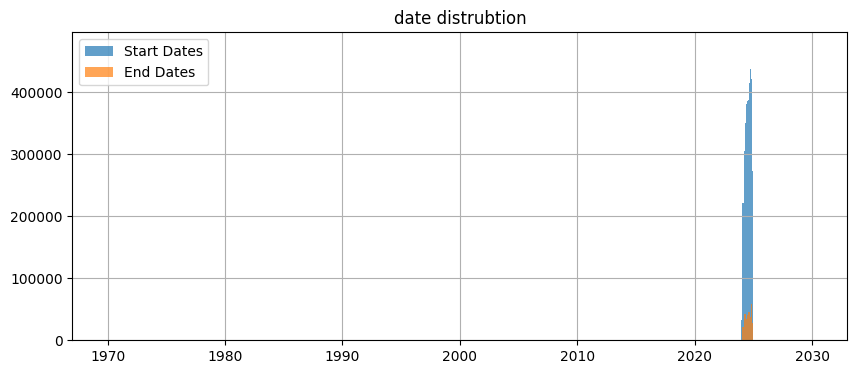

In [72]:
df['started_at'].hist(bins=1000, figsize=(10, 4), alpha=0.7, label="Start Dates")
df['ended_at'].hist(bins=1000, alpha=0.7, label="End Dates")
plt.legend()
plt.title("date distrubtion")
plt.show()

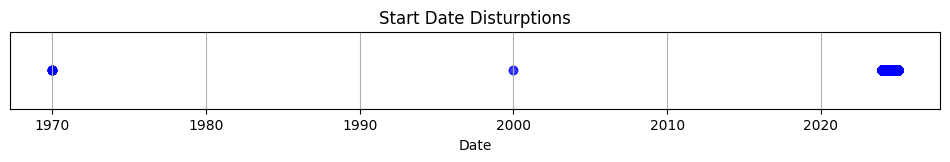

In [73]:
plt.figure(figsize=(12, 1))
plt.scatter(df['started_at'], [1]*len(df), alpha=0.3, color='blue')
plt.title("Start Date Disturptions")
plt.xlabel("Date")
plt.yticks([])  
plt.grid(True)
plt.show()

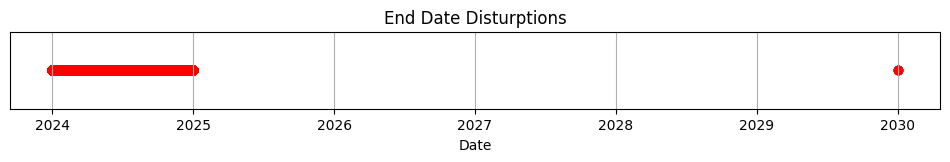

In [74]:
plt.figure(figsize=(12, 1))
plt.scatter(df['ended_at'], [1]*len(df), alpha=0.3, color='red')
plt.title("End Date Disturptions")
plt.xlabel("Date")
plt.yticks([])  # نخفي محور Y لأنه غير مهم هنا
plt.grid(True)
plt.show()

##### تحليل تواريخ البدء والنهاية وفهم الشذوذ التي به
- بما انه نعلم انه الداتا التي لدينا هي تدرس الرحلات لعام 2024 
-  فسنقوم بعد جميع السجلات التي تحت عام 2024 وأعلى من 2024 
- بعد ما نقوم بعدهم سنقوم بحذف هذه السجلات

In [75]:
# count the startDate < 2024
mask_start_befor_2024 = df['started_at'] < '2023-12-31'
print(f'num of startDate before 2024 = {mask_start_befor_2024.sum()}')
# count the endDate < 2024
mask_end_befor_2024 = df['ended_at'] < '2023-12-31'
print(f'num of endDate before 2024 = {mask_end_befor_2024.sum()}')
# count startDate > 2024
mask_start_after_2024 = df['started_at'] > '2025-01-01'
print(f'num of startDate after 2024 = {mask_start_after_2024.sum()}')
# count the EndDate > 2024
mask_end_after_2024 = df['ended_at'] > '2025-01-01'
print(f'num of endDate After 2024 = {mask_end_after_2024.sum()}')

num of startDate before 2024 = 24
num of endDate before 2024 = 0
num of startDate after 2024 = 0
num of endDate After 2024 = 20


In [76]:
df[df['started_at']< '2010-01-01']

ride_id  rideable_type          started_at  \
108561   5F77D8D8117FB777   classic_bike 1970-01-01 00:00:00   
270950   663F9863ABF1EB13  electric_bike 2000-01-01 15:55:56   
291934   EEF6B89A52F23627  electric_bike 1970-01-01 00:00:00   
322876   35371106DDFB3455  electric_bike 2000-01-02 14:59:43   
322877   D7DB0AED73360CA4  electric_bike 2000-01-02 14:40:08   
426822   E511F02C88572667  electric_bike 1970-01-01 00:00:00   
510715   71F374CCEAB766AD  electric_bike 2000-01-02 14:36:37   
1141762  13476AB90997906F  electric_bike 1970-01-01 00:00:00   
1313931  0AA773FAC9470065  electric_bike 1970-01-01 00:00:00   
1354488  A95282431CE234BF  electric_bike 1970-01-01 00:00:00   
1487116  E62661B5ED33E212   classic_bike 1970-01-01 00:00:00   
1828477  11A1CF8CC7CE3CFF   classic_bike 1970-01-01 00:00:00   
1904476  2B15A4F186B3F516  electric_bike 1970-01-01 00:00:00   
2415989  5FF152B8C27C58C7   classic_bike 1970-01-01 00:00:00   
2728944  05ACA5F58EC1C670  electric_bike 1970-01-01 00:00:00   
2868518  9E1FD016D28D44C2  electric_bike 1970-01-01 00:00:00   
3587644  E615BB122D7DED06   classic_bike 1970-01-01 00:00:00   
3694736  9897F32372CB266E  electric_bike 1970-01-01 00:00:00   
3818297  D7F48AAAEA2A62CF  electric_bike 1970-01-01 00:00:00   
4672313  A8394E869ED9A3EF   classic_bike 1970-01-01 00:00:00   
4699715  AC443BAAA7F889FD  electric_bike 1970-01-01 00:00:00   
4750734  DF5F85A0BCC968E0  electric_bike 1970-01-01 00:00:00   
5818905  1B9F7F1AFCDDCD36   classic_bike 1970-01-01 00:00:00   
5951849  DA0BE5328F09B50B  electric_bike 1970-01-01 00:00:00   

                       ended_at                        start_station_name  \
108561  2024-01-06 09:52:45.000               Adams Mill & Columbia Rd NW   
270950  2024-02-18 13:41:37.000                     2nd St & Seaton Pl NE   
291934  2024-02-20 10:52:36.000                          Hardy Rec Center   
322876  2024-02-19 12:52:04.000                                      <NA>   
322877  2024-02-19 12:36:18.000                                      <NA>   
426822  2024-02-09 14:03:42.000                             8th & H St NW   
510715  2024-02-19 12:30:53.000                             4th & W St NE   
1141762 2024-04-21 09:35:26.000                   Maine Ave & Water St SW   
1313931 2024-04-11 18:18:16.000                                      <NA>   
1354488 2024-04-06 20:28:15.000                                      <NA>   
1487116 2024-05-14 07:42:15.000                  Potomac Ave & Half St SW   
1828477 2024-05-19 20:46:32.000                         11th & Park Rd NW   
1904476 2024-05-20 11:10:35.000                            10th & K St NW   
2415989 2024-06-29 10:27:32.067                      4th & Florida Ave NE   
2728944 2024-07-01 21:36:47.626  10th & Quincy St NE / Turkey Thicket Rec   
2868518 2024-07-22 14:12:20.773                                      <NA>   
3587644 2024-08-11 21:23:38.566            C & O Canal & Wisconsin Ave NW   
3694736 2024-08-18 19:08:04.552                                      <NA>   
3818297 2024-09-22 11:33:42.541                    Crystal Dr & 15th St S   
4672313 2024-10-15 17:17:48.833             20th & O St NW / Dupont South   
4699715 2024-10-25 12:05:44.639               New York Ave & Hecht Ave NE   
4750734 2024-10-13 19:37:37.897                    10th St & Spring Rd NW   
5818905 2024-12-22 14:35:57.632             17th St & Rhode Island Ave NW   
5951849 2024-12-01 13:24:28.289                                      <NA>   

        start_station_id                                   end_station_name  \
108561             31104                       Georgia Ave & Fairmont St NW   
270950             31522                                               <NA>   
291934             31326                          Reservoir Rd & 38th St NW   
322876              <NA>                                               <NA>   
322877              <NA>                                               <NA>   
426822           

- منلاحظ انه السجلات التي يكون فيها تاريخ البداية اصغر من 2024 هي نفسها يلي عم يكون فيها تاريخ النهاية أكبر من 2024 
- سنقوم بحذف هذه السجلات الشاذة

In [77]:
# bike_simple = df.copy()
df = df[~mask_start_befor_2024]
df = df[~mask_end_after_2024]


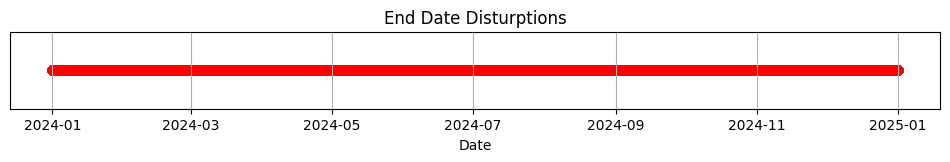

In [78]:
plt.figure(figsize=(12, 1))
plt.scatter(df['ended_at'], [1]*len(df), alpha=0.3, color='red')
plt.title("End Date Disturptions")
plt.xlabel("Date")
plt.yticks([])  # نخفي محور Y لأنه غير مهم هنا
plt.grid(True)
plt.show()

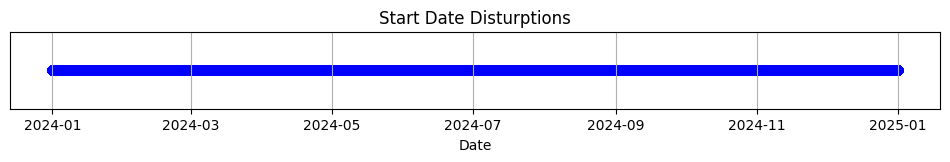

In [79]:
plt.figure(figsize=(12, 1))
plt.scatter(df['started_at'], [1]*len(df), alpha=0.3, color='blue')
plt.title("Start Date Disturptions")
plt.xlabel("Date")
plt.yticks([])  # نخفي محور Y لأنه غير مهم هنا
plt.grid(True)
plt.show()

In [80]:
SAVE_TO = "data/interim/trips_clean.parquet"

dupes = df['ride_id'].duplicated(keep=False)
print(f"Rows with duplicated ride_id: {dupes.sum():,}")


missing_geo = df['end_lat'].isna() | df['end_lng'].isna()
print(f"Rows missing end_lat or end_lng: {missing_geo.sum():,}")


clean_df = (
    df                             
    .loc[~dupes]                   
    .loc[~missing_geo]             
    .drop_duplicates('ride_id')    
)

print(f"Remaining rows: {len(clean_df):,}  (dropped {len(df) - len(clean_df):,})")

clean_df.to_parquet(SAVE_TO, index=False)
print(f"Saved cleaned dataframe → {SAVE_TO}")


Rows with duplicated ride_id: 282
Rows missing end_lat or end_lng: 4,650
Remaining rows: 6,109,373  (dropped 4,906)
Saved cleaned dataframe → data/interim/trips_clean.parquet


In [81]:
missing = (clean_df.isna()
             .sum()
             .to_frame("null_count")
             .assign(null_pct=lambda s: 100 * s.null_count / len(df))
             .query("null_count > 0")
             .sort_values("null_count", ascending=False))

display(missing)  

# duplicates
dup_rows = clean_df.duplicated()             
print(f"Row duplicates : {dup_rows.sum()}  ({dup_rows.mean():.2%} from total)")

# we have unique column (ride_id)
if "ride_id" in clean_df.columns:
    dup_ids = clean_df["ride_id"].duplicated(keep=False)
    print(f"Rows have ride_id duplicates: {dup_ids.sum()}")


null_count   null_pct
end_station_id         1232975  20.165501
end_station_name       1231448  20.140527
start_station_id       1190917  19.477636
start_station_name     1190917  19.477636

Row duplicates : 0  (0.00% from total)
Rows have ride_id duplicates: 0


# Start to fill the Stations name and ID 

In [82]:
stations.head(10)

id                                          name
0  30200                  9th St & Pennsylvania Ave NW
1  30201                                 9th & G St NW
2  31000                           Eads St & 15th St S
3  31002                        Crystal Dr & 20th St S
4  31003                        Crystal Dr & 15th St S
5  31004  Aurora Hills Cmty Ctr / 18th St & S Hayes St
6  31005    Pentagon City Metro / 12th St & S Hayes St
7  31006  Pentagon Row Plaza / Army Navy Dr & Joyce St
8  31007      Crystal City Metro / 18th St & S Bell St
9  31009                        Crystal Dr & 27th St S

In [83]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


### Fill missing station IDs / names using `stations` table

In [84]:

# 1) Build lookup dictionaries from the reference table
stations_clean = stations.copy()
stations_clean["name_clean"] = stations_clean["name"].str.strip().str.lower()

id_from_name  = stations_clean.set_index("name_clean")["id"].to_dict()
name_from_id  = stations_clean.set_index("id")["name"].to_dict()

# 2) Helper to print how many NaNs we have
def show_missing(df, prefix):
    print(
        f"{prefix.capitalize():5s}  "
        f"missing id: {df[f'{prefix}_station_id'].isna().sum():,}   |  "
        f"missing name: {df[f'{prefix}_station_name'].isna().sum():,}"
    )

print("# ---- BEFORE FILLING ----")
show_missing(clean_df, "start")
show_missing(clean_df, "end")
# clean_df.info()

# 3) Fill start-station gaps
mask = clean_df["start_station_id"].isna() & clean_df["start_station_name"].notna()
clean_df.loc[mask, "start_station_id"] = (
    clean_df.loc[mask, "start_station_name"].str.strip().str.lower().map(id_from_name)
)

mask = clean_df["start_station_name"].isna() & clean_df["start_station_id"].notna()
clean_df.loc[mask, "start_station_name"] = clean_df.loc[mask, "start_station_id"].map(name_from_id)

# 4) Fill end-station gaps
mask = clean_df["end_station_id"].isna() & clean_df["end_station_name"].notna()
clean_df.loc[mask, "end_station_id"] = (
    clean_df.loc[mask, "end_station_name"].str.strip().str.lower().map(id_from_name)
)

mask = clean_df["end_station_name"].isna() & clean_df["end_station_id"].notna()
clean_df.loc[mask, "end_station_name"] = clean_df.loc[mask, "end_station_id"].map(name_from_id)

print("\n# ---- AFTER FILLING ----")
show_missing(clean_df, "start")
show_missing(clean_df, "end")

# 5) Optional: count rows still missing BOTH id *and* name
both_start = (clean_df["start_station_id"].isna() & clean_df["start_station_name"].isna()).sum()
both_end   = (clean_df["end_station_id"].isna()   & clean_df["end_station_name"].isna()).sum()
print(f"\nRows still missing BOTH start-station fields: {both_start:,}")
print(f"Rows still missing BOTH end-station fields  : {both_end:,}")



# ---- BEFORE FILLING ----
Start  missing id: 1,190,917   |  missing name: 1,190,917
End    missing id: 1,232,975   |  missing name: 1,231,448

# ---- AFTER FILLING ----
Start  missing id: 1,190,917   |  missing name: 1,190,917
End    missing id: 1,231,448   |  missing name: 1,231,448

Rows still missing BOTH start-station fields: 1,190,917
Rows still missing BOTH end-station fields  : 1,231,448


***now start to use the locations from the "Capital_Bikeshare_Locations.csv" to fill the rest of the missing values***

* stations_locations = "Capital_Bikeshare_Locations.csv"

In [85]:
stations_locations.head(10)

X             Y                                            NAME  \
0 -8.577104e+06  4.705679e+06                                Lincoln Memorial   
1 -8.609481e+06  4.714716e+06    W&OD Trail/Sunset Hills Rd & Isaac Newton Sq   
2 -8.575867e+06  4.705657e+06                   17th St & Independence Ave SW   
3 -8.574188e+06  4.706622e+06                                   8th & D St NW   
4 -8.567161e+06  4.706864e+06  Anacostia Ave & Benning Rd NE / River Terrace    
5 -8.558021e+06  4.721718e+06                  Roosevelt Center & Crescent Rd   
6 -8.577479e+06  4.695147e+06                         Braddock Rd Metro North   
7 -8.573150e+06  4.706254e+06                Constitution Ave & 2nd St NW/DOL   
8 -8.581470e+06  4.698873e+06                    S Randolph St & Campbell Ave   
9 -8.559494e+06  4.722559e+06                          Crescent Rd & Ridge Rd   

  STATION_TYPE                            STATION_ID  STATION_STATUS  \
0      classic  08254284-1f3f-11e7-bf6b-3863bb334450             NaN   
1      classic  08263fbd-1f3f-11e7-bf6b-3863bb334450             NaN   
2      classic  082623bf-1f3f-11e7-bf6b-3863bb334450             NaN   
3      classic  08256ac9-1f3f-11e7-bf6b-3863bb334450             NaN   
4      classic  082518eb-1f3f-11e7-bf6b-3863bb334450             NaN   
5      classic  6922a398-ec20-493d-a832-5e337cf335f5             NaN   
6      classic  08253c6b-1f3f-11e7-bf6b-3863bb334450             NaN   
7      classic  08256d91-1f3f-11e7-bf6b-3863bb334450             NaN   
8      classic  0825e4d5-1f3f-11e7-bf6b-3863bb334450             NaN   
9      classic  10d57c0d-6f3c-45d1-8a12-eda5665e213c             NaN   

            LAST_REPORTED  NUM_DOCKS_AVAILABLE  NUM_DOCKS_DISABLED  \
0  2025/05/05 20:25:51+00                   17                   0   
1  2025/05/05 20:25:51+00                   15                   0   
2  2025/05/05 20:25:51+00                   10                   0   
3  2025/05/05 20:25:49+00                    0                   0   
4  2025/05/05 20:25:49+00                    4                   0   
5  2025/05/05 20:25:49+00                    6                   0   
6  2025/05/05 20:25:56+00                    5                   0   
7  2025/05/05 20:25:57+00                   11                   0   
8  2025/05/05 20:25:57+00                    2                   0   
9  2025/05/05 20:25:48+00                    3                   0   

   NUM_BIKES_AVAILABLE  ...  EIGHTD_HAS_KEY_DISPENSER  CAPACITY  \
0                    8  ...                        NO        25   
1                    3  ...                        NO        19   
2                    6  ...                        NO        19   
3                   24  ...                        NO        24   
4                   10  ...                        NO        15   
5                    6  ...                        NO        15   
6                   11  ...                        NO        16   
7                   12  ...                        NO        27   
8                   12  ...                        NO        15   
9                   11  ...                        NO        15   

   RENTAL_METHODS REGION_ID REGION_NAME GIS_ID   LATITUDE  LONGITUDE  \
0  KEY,CREDITCARD      42.0    DCA-CABI    NaN  38.888255 -77.049437   
1  KEY,CREDITCARD     104.0    DCA-CABI    NaN  38.951419 -77.340281   
2  KEY,CREDITCARD      42.0    DCA-CABI    NaN  38.888097 -77.038325   
3  KEY,CREDITCARD      42.0    DCA-CABI    NaN  38.894851 -77.023240   
4  KEY,CREDITCARD      42.0    DCA-CABI    NaN  38.896544 -76.960120   
5  KEY,CREDITCARD     133.0    DCA-CABI    NaN  39.000310 -76.878005   
6  KEY,CREDITCARD      40.0    DCA-CABI    NaN  38.814577 -77.052808   
7  KEY,CREDITCARD      42.0    DCA-CABI    NaN  38.892275 -77.013917   
8  KEY,CREDITCARD      41.0    DCA-CABI    NaN  38.840654 -77.088659   
9  KEY,CREDITCARD     133.0    DCA-CABI    NaN  39.006191 -76.891247   

        GIS_LAST_MOD_DTTM  

 * at first from this head we see the stations ID here not same as the stations ID from the main data so we fill it using the spacial matching and we will fix the issue will happen after that because of the mismatching ID or difference ID or difference Name.  

In [86]:
print(stations_locations.columns)

Index(['X', 'Y', 'NAME', 'STATION_TYPE', 'STATION_ID', 'STATION_STATUS',
       'LAST_REPORTED', 'NUM_DOCKS_AVAILABLE', 'NUM_DOCKS_DISABLED',
       'NUM_BIKES_AVAILABLE', 'NUM_EBIKES_AVAILABLE', 'NUM_BIKES_DISABLED',
       'IS_INSTALLED', 'IS_RETURNING', 'IS_RENTING', 'HAS_KIOSK', 'IOS',
       'ANDROID', 'ELECTRIC_BIKE_SURCHARGE_WAIVER', 'EIGHTD_HAS_KEY_DISPENSER',
       'CAPACITY', 'RENTAL_METHODS', 'REGION_ID', 'REGION_NAME', 'GIS_ID',
       'LATITUDE', 'LONGITUDE', 'GIS_LAST_MOD_DTTM', 'OBJECTID'],
      dtype='object')


In [87]:
stations_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

No missing value in the columns we need  **["STATION_ID", "NAME", "LATITUDE", "LONGITUDE"]**

* we reload the stations locations because we need just that four columns
* and here we use the **BallTree metric is haversine** algorithm  with the to fill the values because it much faster that spacial join and we can arrive to 10M without problems in time and resources in the sampled data it take (10.5s) to fill the whole values 

In [88]:

# 1 load reference stations_location and use just needed columns 
stations_location_uses_cols = pd.read_csv("data/raw/Capital_Bikeshare_Locations.csv",
                       usecols=["STATION_ID", "NAME", "LATITUDE", "LONGITUDE"]
                      ).dropna(subset=["LATITUDE", "LONGITUDE"])

# Prepare radians for BallTree
station_coords_rad = np.deg2rad(stations_location_uses_cols[["LATITUDE", "LONGITUDE"]].values)
tree = BallTree(station_coords_rad, metric="haversine")

# 2 select clean_df that need filling 
mask_start = (
    clean_df["start_station_id"].isna() &
    clean_df["start_station_name"].isna() &
    clean_df["start_lat"].notna() &
    clean_df["start_lng"].notna()
)

mask_end = (
    clean_df["end_station_id"].isna() &
    clean_df["end_station_name"].isna() &
    clean_df["end_lat"].notna() &
    clean_df["end_lng"].notna()
)

# 3 helper to fill either side
def fill_side(clean_df_df, mask, lat_col, lng_col, id_col, name_col):
    # coordinates of the problematic rows (radians)
    coords_rad = np.deg2rad(clean_df_df.loc[mask, [lat_col, lng_col]].values)

    # query BallTree (k=1 gives the nearest neighbour)
    dist, idx = tree.query(coords_rad, k=1)
    nearest = stations_location_uses_cols.iloc[idx.flatten()]

    # write back ID and name
    clean_df_df.loc[mask, id_col]   = nearest["STATION_ID"].values
    clean_df_df.loc[mask, name_col] = nearest["NAME"].values

#  4) apply to start & end 
fill_side(clean_df, mask_start, "start_lat", "start_lng",
          "start_station_id", "start_station_name")

fill_side(clean_df, mask_end, "end_lat", "end_lng",
          "end_station_id", "end_station_name")

#  5) quick sanity check --
def report(df, prefix):
    print(f"{prefix}  missing id: {df[f'{prefix}_station_id'].isna().sum():,}  |  "
          f"missing name: {df[f'{prefix}_station_name'].isna().sum():,}")

print("# After spatial fill")
report(clean_df, "start")
report(clean_df, "end")

#  6) save result --
# clean_df.to_parquet("data/interim/clean_df_filled_spatial.parquet", index=False)
# print("Saved → data/interim/clean_df_filled_spatial.parquet")


# After spatial fill
start  missing id: 0  |  missing name: 0
end  missing id: 0  |  missing name: 0


In [89]:
missing = (clean_df.isna()
             .sum()
             .to_frame("null_count")
             .assign(null_pct=lambda s: 100 * s.null_count / len(df))
             .query("null_count > 0")
             .sort_values("null_count", ascending=False))

missing 

# duplicates
dup_rows = clean_df.duplicated()             
print(f"Row duplicates : {dup_rows.sum()}  ({dup_rows.mean():.2%} from total)")

# we have unique column (ride_id)
if "ride_id" in clean_df.columns:
    dup_ids = clean_df["ride_id"].duplicated(keep=False)
    print(f"Rows have ride_id duplicates: {dup_ids.sum()}")

Row duplicates : 0  (0.00% from total)
Rows have ride_id duplicates: 0


**We filled the full missing values we had but we need to make sure is it correct or not**

In [90]:
clean_df['start_station_id']

0          31519
1          31519
2          31519
3          31519
4          31519
           ...  
6114318    31266
6114319    31266
6114320    31266
6114321    31266
6114322    31266
Name: start_station_id, Length: 6109373, dtype: object

* as we see here the IDs are not in the same formate some in new formate others in old 

**NOW we need to see if there is any Anomaly stations after we fill them**

## save the data in csv file before the feature engineering

In [91]:
# Cell-2 : save cleaned & enriched trips table to CSV

CLEAN_DF = clean_df 
out_path = pathlib.Path("data/interim/trips_clean_and_fill.csv")
CLEAN_DF.to_csv(out_path, index=False)
print(f"✅ Saved: {out_path.as_posix()}  ({out_path.stat().st_size/1_048_576:.2f} MB)")


✅ Saved: data/interim/trips_clean_and_fill.csv  (1170.20 MB)


In [92]:
CLEAN_DF

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6114318  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6114319  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6114320  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6114321  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6114322  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                       ended_at start_station_name start_station_id  \
0       2024-01-25 15:52:35.000      1st & O St NW            31519   
1       2024-01-02 16:53:25.000      1st & O St NW            31519   
2       2024-01-24 15:43:55.000      1st & O St NW            31519   
3       2024-01-04 15:37:35.000      1st & O St NW            31519   
4       2024-01-05 12:35:40.000      1st & O St NW            31519   
...                         ...                ...              ...   
6114318 2024-12-21 17:54:36.282     11th & M St NW            31266   
6114319 2024-12-07 10:52:42.706     11th & M St NW            31266   
6114320 2024-12-08 19:12:37.130     11th & M St NW            31266   
6114321 2024-12-26 11:57:38.459     11th & M St NW            31266   
6114322 2024-12-14 12:32:56.165     11th & M St NW            31266   

                  end_station_name                        end_station_id  \
0                    1st & L St NW                                 31677   
1              4th & College St NW                                 31138   
2                    1st & L St NW                                 31677   
3                    1st & L St NW                                 31677   
4                   10th & G St NW                                 31274   
...                            ...                                   ...   
6114318              8th & O St NW  08260549-1f3f-11e7-bf6b-3863bb334450   
6114319       14th & Belmont St NW                                 31119   
6114320  13th St & New York Ave NW  0824aa39-1f3f-11e7-bf6b-3863bb334450   
6114321  13th St & New York Ave NW  0824aa39-1f3f-11e7-bf6b-3863bb334450   
6114322             17th & P St NW  5e828067-2fd6-4168-b150-5409754e734c   

         start_lat  start_lng    end_lat    end_lng member_casual  
0        38.908643 -77.012365  38.903819 -77.011987        member  
1        38.908643 -77.012365  38.921233 -77.018135        member  
2        38.908643 -77.012365  38.903819 -77.011987        member  
3        38.908643 -77.012365  38.903819 -77.011987        member  
4        38.908690 -77.012317  38.898243 -77.026235        casual  
...            ...        ...        ...        ...           ...  
6114318  38.905578 -77.027313  38.910000 -77.020000        member  
6114319  38.905578 -77.027313  38.921074 -77.031887        member  
6114320  38.905578 -77.027313  38.900000 -77.030000        member  
6114321  38.905578 -77.027313  38.900000 -77.030000        member  
6114322  38.905589 -77.027304  38.910000 -77.040000        member  

[6109373 rows x 13 columns]

# Start building Features 

## B1

### استخراج سمات التاريخ البسيطة

In [93]:
CLEAN_DF['year'] = CLEAN_DF['started_at'].dt.year
CLEAN_DF['month'] = CLEAN_DF['started_at'].dt.month
CLEAN_DF['day'] = CLEAN_DF['started_at'].dt.day
CLEAN_DF['weekday'] = CLEAN_DF['started_at'].dt.day_name()

## B2

#### حساب مدة الرحلة 

In [94]:
CLEAN_DF['duration_minutes'] = (CLEAN_DF['ended_at'] - CLEAN_DF['started_at']).dt.total_seconds() / 60
CLEAN_DF['duration_minutes'] = CLEAN_DF['duration_minutes'].round(2)


In [95]:
CLEAN_DF

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6114318  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6114319  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6114320  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6114321  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6114322  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                       ended_at start_station_name start_station_id  \
0       2024-01-25 15:52:35.000      1st & O St NW            31519   
1       2024-01-02 16:53:25.000      1st & O St NW            31519   
2       2024-01-24 15:43:55.000      1st & O St NW            31519   
3       2024-01-04 15:37:35.000      1st & O St NW            31519   
4       2024-01-05 12:35:40.000      1st & O St NW            31519   
...                         ...                ...              ...   
6114318 2024-12-21 17:54:36.282     11th & M St NW            31266   
6114319 2024-12-07 10:52:42.706     11th & M St NW            31266   
6114320 2024-12-08 19:12:37.130     11th & M St NW            31266   
6114321 2024-12-26 11:57:38.459     11th & M St NW            31266   
6114322 2024-12-14 12:32:56.165     11th & M St NW            31266   

                  end_station_name                        end_station_id  \
0                    1st & L St NW                                 31677   
1              4th & College St NW                                 31138   
2                    1st & L St NW                                 31677   
3                    1st & L St NW                                 31677   
4                   10th & G St NW                                 31274   
...                            ...                                   ...   
6114318              8th & O St NW  08260549-1f3f-11e7-bf6b-3863bb334450   
6114319       14th & Belmont St NW                                 31119   
6114320  13th St & New York Ave NW  0824aa39-1f3f-11e7-bf6b-3863bb334450   
6114321  13th St & New York Ave NW  0824aa39-1f3f-11e7-bf6b-3863bb334450   
6114322             17th & P St NW  5e828067-2fd6-4168-b150-5409754e734c   

         start_lat  start_lng    end_lat    end_lng member_casual  year  \
0        38.908643 -77.012365  38.903819 -77.011987        member  2024   
1        38.908643 -77.012365  38.921233 -77.018135        member  2024   
2        38.908643 -77.012365  38.903819 -77.011987        member  2024   
3        38.908643 -77.012365  38.903819 -77.011987        member  2024   
4        38.908690 -77.012317  38.898243 -77.026235        casual  2024   
...            ...        ...        ...        ...           ...   ...   
6114318  38.905578 -77.027313  38.910000 -77.020000        member  2024   
6114319  38.905578 -77.027313  38.921074 -77.031887        member  2024   
6114320  38.905578 -77.027313  38.900000 -77.030000        member  2024   
6114321  38.905578 -77.027313  38.900000 -77.030000        member  2024   
6114322  38.905589 -77.027304  38.910000 -77.040000        member  2024   

         month  day    weekday  duration_minutes  
0            1   25   Thursday              2.60  
1            1    2    Tuesday              8.45  
2            1   24  Wednesday              3.67  
3            1    4   Thursday              2.58  
4            1    5     Friday              7.70  
...        ...  ...        ...               ...  
6114318     12   21   Saturday              3.42  
6114319     12    7   Saturday              8.28  
6114320     12    8     Sunday              3.14  
6114321     12   26   Th

In [96]:
CLEAN_DF['duration_minutes'].describe()

count    6.109373e+06
mean     1.525158e+01
std      3.139618e+01
min      0.000000e+00
25%      5.580000e+00
50%      9.740000e+00
75%      1.676000e+01
max      1.559930e+03
Name: duration_minutes, dtype: float64

#### ملاحظات على المعلومات الإحصائية
- نجد أن أغلب الرحلات تتراوح مدتها بين 5 إلى 16 الدقيقة 
- وأيضا سنقوم بعد مدة الرحلات التي قيمتها سالبة

In [97]:
print("عدد الرحلات ذات مدة سالبة:", (CLEAN_DF['duration_minutes'] < 0).sum())

عدد الرحلات ذات مدة سالبة: 0


## B3

### حساب التكلفة الإجمالية للرحلة

In [98]:
def calculate_cost(row):
    base_cost = 0
    extra_cost_per_minute = 0

    # هون بتم تحديد إذا العضو منتسب
    if row['member_casual'] == 'member':
        base_cost = 3.95
        if row['rideable_type'] == 'classic_bike':
            extra_cost_per_minute = 0.05
        elif row['rideable_type'] == 'electric_bike':
            extra_cost_per_minute = 0.1

        # ما بينضاف قيمة إضافية إلا إذا زاد عن ال 45 دقيقة
        extra_minutes = max(row['duration_minutes'] - 45, 0)
        total_cost = base_cost + (extra_minutes * extra_cost_per_minute)

    else:  # المستخدم يلي مو عضو
        base_cost = 1
        if row['rideable_type'] == 'classic_bike':
            extra_cost_per_minute = 0.05
        elif row['rideable_type'] == 'electric_bike':
            extra_cost_per_minute = 0.15

        # كل دقيقة تُحسب
        total_cost = base_cost + (row['duration_minutes'] * extra_cost_per_minute)

    # ضريبة تجاوز اليوم الكامل
    if row['duration_minutes'] > 1440:
        total_cost += 3

    return round(total_cost, 2)


In [99]:
CLEAN_DF['total_cost'] = CLEAN_DF.apply(calculate_cost, axis=1)


In [100]:
# تحميل المنطقة التجارية
cbd_polygon = central_business_area
cbd_area = cbd_polygon.geometry.iloc[0]

In [101]:
# Get Point of every start and end station to compare later 
# with the cbd_area if it is contain this points
bike_test2 = CLEAN_DF
bike_test2['start_point'] = gpd.points_from_xy(bike_test2['start_lng'], bike_test2['start_lat'])

bike_test2['end_point'] = gpd.points_from_xy(bike_test2['end_lng'], bike_test2['end_lat'])


In [102]:

gdf_start = gpd.GeoDataFrame(bike_test2, geometry=bike_test2['start_point'], crs="EPSG:4326")
bike_test2['start_in_cbd'] = gdf_start.within(cbd_area)

gdf_end = gpd.GeoDataFrame(bike_test2, geometry=bike_test2['end_point'], crs="EPSG:4326")
bike_test2['end_in_cbd'] = gdf_end.within(cbd_area)

In [103]:

bike_test2['cbd_fee'] = 0
bike_test2.loc[bike_test2['start_in_cbd'], 'cbd_fee'] += 0.5
bike_test2.loc[bike_test2['end_in_cbd'], 'cbd_fee'] += 0.5


bike_test2['total_cost'] += bike_test2['cbd_fee']



In [104]:
CLEAN_DF['total_cost'] = bike_test2['total_cost']


In [105]:
CLEAN_DF['total_cost'].describe()

count    6.109373e+06
mean     3.811198e+00
std      2.051569e+00
min      1.000000e+00
25%      3.370000e+00
50%      3.950000e+00
75%      4.040000e+00
max      1.002200e+02
Name: total_cost, dtype: float64

#### ماذا لاحظت من الكلفة الإجمالية
 - انه متوسط الكلف حوالي 3.8 دولار
 - أقل كلفة هي واحد دولار
 - حوالي ال 75% من الرحل تتراوح كلفتها بين 3.37 إلى 4.04 دولار
 - أعلى كلفة هي 82 دولار

## B6

#### الأن سننتقل إلى معرفة كل رحلة إن كانت مرت ضمن المنطقة التجارية
 - يقصد بالمرور انه انطلقت او انتهت

In [106]:
bike_test2['passed_through_cbd'] = (
    bike_test2['start_in_cbd'] | bike_test2['end_in_cbd']
).astype(int)


In [107]:
CLEAN_DF['passed_through_cbd'] = bike_test2['passed_through_cbd']

## B7

### حساب المسافة إلى المنطقة التجارية الرئيسية

##### إسقاط الإحداثيات  
 - convert from EPSG:4326 To EPSG:6933

In [108]:

gdf_end = gpd.GeoDataFrame(bike_test2.copy(), geometry=bike_test2['end_point'], crs="EPSG:4326")

gdf_end_m = gdf_end.to_crs(epsg=6933)
cbd_area_m = cbd_polygon.to_crs(epsg=6933).geometry.iloc[0]

gdf_end_m['distance_to_cbd'] = np.where(
    gdf_end_m['end_in_cbd'],
    np.nan,
    gdf_end_m.geometry.distance(cbd_area_m)
)


In [109]:

bike_test2['distance_to_cbd'] = gdf_end_m['distance_to_cbd']
CLEAN_DF['distance_to_cbd'] = bike_test2['distance_to_cbd']

##### الأن لنقوم بتحليل المسافات وذلك لكي نختار العتبة
 - سنرى إحصائيات عامة حول المتوسط وهكذا 
 - سنقوم برسم توزع المسافات مع عدد الرحلات 
 - boxplot وذلك لرؤية القيم المتطرفة

In [110]:
CLEAN_DF['distance_to_cbd'].describe()

count    5.007645e+06
mean     2.476263e+03
std      3.542924e+04
min      5.018761e+00
25%      6.140798e+02
50%      1.392944e+03
75%      2.922070e+03
max      1.506611e+07
Name: distance_to_cbd, dtype: float64

##### ماذا لاحظت
 - أجد بداية ان المتوسط قيمته 2407 متر وهذا يعطينا فكرة عامة عن المسافات ولكن لا يمكن الاعتماد عليها وذلك بسبب وجود قيم شاذة مثال قيمة العظمى
 - الانحراف المعياري = 21713 وهذا يشير إلى التشتت الكبير جداً في المسافات مما يعني أنه يوجد قيم شاذة ضخمة
 - نلاحظ من النسب (25 - 50 - 75) أن معظم الرحل تتراوح المسافات بين 614 إلى 2922 متر
 
 ###### لذلك يمكن القول أنه يمكننا أخذ قيمة 1300 أو 600 مثلاً كحد ولكن سندعم الدليل بمخططات

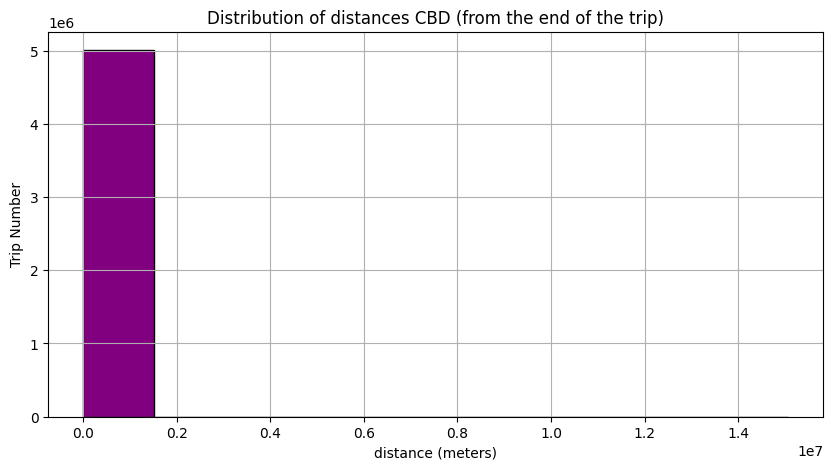

In [111]:

# نرسم فقط القيم غير الفارغة
plt.figure(figsize=(10, 5))
CLEAN_DF['distance_to_cbd'].dropna().hist(bins=10, color='purple', edgecolor='black',)
plt.title("Distribution of distances CBD (from the end of the trip)")
plt.xlabel("distance (meters)")
plt.ylabel("Trip Number")
plt.grid(True)
plt.show()

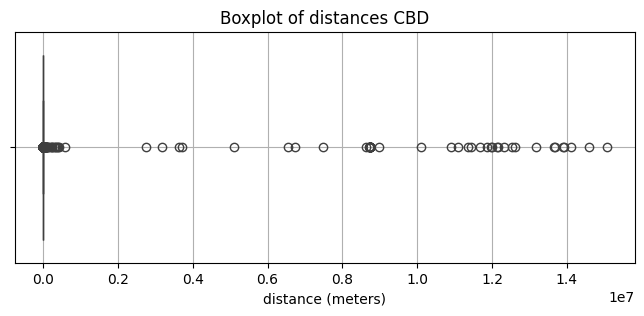

In [112]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=CLEAN_DF, x='distance_to_cbd')
plt.title("Boxplot of distances CBD")
plt.xlabel("distance (meters)")
plt.grid(True)
plt.show()

#### تحليل الرسم البياني
 - بسبب وجود قيم شاذة فلم يكن توزيع واضحا 
 - 
 لذلك سنرسم ولكن فقط الرحلات التي لم يتجاوز البعد 10 كيلومتر
 

In [113]:
reasonable_distances = CLEAN_DF['distance_to_cbd'][
    (CLEAN_DF['distance_to_cbd'] < 10000)
]


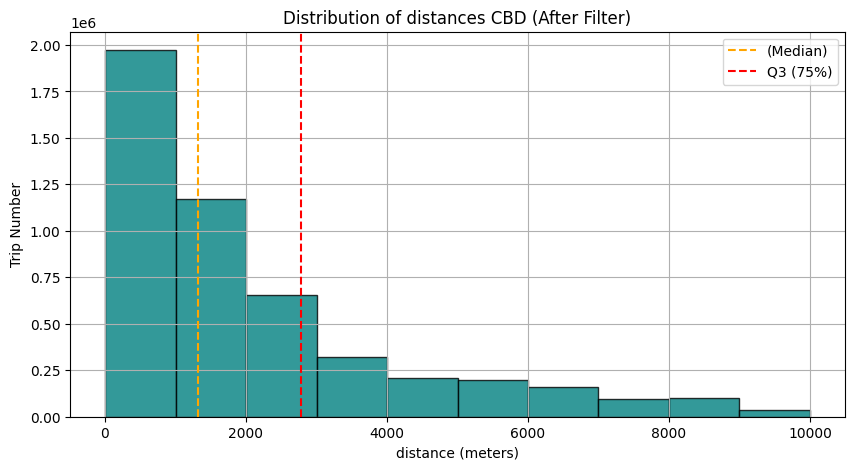

In [114]:
plt.figure(figsize=(10, 5))
plt.hist(reasonable_distances, bins=10, color='teal', edgecolor='black', alpha=0.8)

# خطوط الإحصاءات
plt.axvline(reasonable_distances.median(), color='orange', linestyle='--', label='(Median)')
plt.axvline(reasonable_distances.quantile(0.75), color='red', linestyle='--', label='Q3 (75%)')

plt.title("Distribution of distances CBD (After Filter)")
plt.xlabel("distance (meters)")
plt.ylabel("Trip Number")
plt.legend()
plt.grid(True)
plt.show()

#### تحليل التوزع 
 - كما نلاحظ ضمن الرسم أنه هناك قفزة عند قيمة ال 2000 متر 
 - ونلاحظ انخفاض ملحوظ بعدد الرحلات بدءاً من 3000 
 

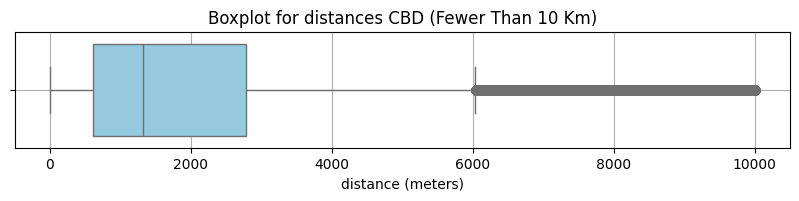

In [115]:
plt.figure(figsize=(10, 1.5))
sns.boxplot(x=reasonable_distances, color='skyblue')
plt.title("Boxplot for distances CBD (Fewer Than 10 Km)")
plt.xlabel("distance (meters)")
plt.grid(True)
plt.show()

#### BOXPlot
 - نلاحظ أن الجزء الأزرق حيث بدايته تعبر عن الربع الأول (25%) من الرحل ونهايته تعبر عن (75%) أي انه كما قلنا مسبقا انه حوالي ال 50% من الرحلات تتراوح بين 500 متر تقريبا إلى ال 2700 متر تقريبا


#### اختيار العتبة
سأقوم باختيار عتبة وهي 2000 وذلك كما نرى أنها قيمة ليست متسامحة كثيرا ولا صارمة 

In [116]:
def classify_proximity(distance):
    if pd.isna(distance):
        return np.nan  # Do not class the Trip end inside the CBD
    elif distance <= 2000:
        return 1  # Close
    else:
        return 0  # Far


CLEAN_DF['near_cbd'] = CLEAN_DF['distance_to_cbd'].apply(classify_proximity)

## B10

### Weather Bining TO 
 - Rain 
 - Sunny
 - Cloudy
 

<div dir="rtl">

تم ذلك حيث تم النظر إلى عامود الأيقونة وبناء عليها تم التصنيف حيث فيه حوالي 8 قيم 
 - تم تصنيف كل من قيم clear,sun  إلى قيمة sunny
 
 - وتم تصنيف كل من partly-cloudy, wind , cloudy إلى cloudy
 - وبقية القيم ضمن ال icon تم تصنيفها على أنها rainy 
 </div>

In [117]:
weather = weather_df

weather['datetime'] = pd.to_datetime(weather['datetime']).dt.date

In [118]:
bike_test2['ride_date'] = bike_test2['started_at'].dt.date

In [119]:

bike_with_weather = bike_test2.merge(weather[['datetime', 'icon']], 
                                              left_on='ride_date', 
                                              right_on='datetime', 
                                              how='left')


In [120]:
def classify_weather(icon):
    if pd.isna(icon):
        return 'unknown'
    icon = icon.lower()
    if 'rain' in icon or 'snow' in icon or 'drizzle' in icon or 'thunder' in icon:
        return 'rainy'
    elif 'cloud' in icon or 'overcast' in icon or 'wind' in icon :
        return 'cloudy'
    elif 'clear' in icon or 'sun' in icon:
        return 'sunny'
    else:
        return 'err' 

In [121]:
bike_with_weather['weather_bin'] = bike_with_weather['icon'].apply(classify_weather)


In [122]:
CLEAN_DF = bike_with_weather

## B11

### بناء سلسلة زمنية للإيرادات اليومية مع حالة الطقس

In [123]:
# Step 1: create payment day (the End date)
CLEAN_DF['payment_day'] = CLEAN_DF['ended_at'].dt.date

# Step 2: Revenue collection by payment day  
daily_revenue = CLEAN_DF.groupby('payment_day')['total_cost'].sum().reset_index()
daily_revenue.rename(columns={'total_cost': 'daily_total_revenue'}, inplace=True)

# Step 3: Extract Weather for every day

daily_weather = CLEAN_DF.groupby('payment_day')['weather_bin'].first().reset_index()


# Step 4 : merge daily revenu with weather state

daily_summary = daily_revenue.merge(daily_weather, on='payment_day')


In [124]:
daily_summary

payment_day  daily_total_revenue weather_bin
0    2024-01-01             18411.19       rainy
1    2024-01-02             31661.97      cloudy
2    2024-01-03             35331.36      cloudy
3    2024-01-04             32900.37      cloudy
4    2024-01-05             31850.22      cloudy
..          ...                  ...         ...
361  2024-12-27             35002.20      cloudy
362  2024-12-28             20978.72       rainy
363  2024-12-29             40344.04       rainy
364  2024-12-30             52948.77      cloudy
365  2024-12-31             46036.37       rainy

[366 rows x 3 columns]

In [74]:
OUT_PARQ = 'data/final_stage_results/daily_summary.parquet'

pathlib.Path(OUT_PARQ).parent.mkdir(parents=True, exist_ok=True)
daily_summary.to_parquet(OUT_PARQ, index=False)
print(f"saved → {OUT_PARQ}")

saved → data/final_stage_results/daily_summary.parquet


## B4

### capacity feature

* Here I see the range of capacity I have 

In [75]:
stations_locations['CAPACITY'].describe()

count    794.000000
mean      17.234257
std        5.712581
min        8.000000
25%       15.000000
50%       15.000000
75%       19.000000
max       55.000000
Name: CAPACITY, dtype: float64

* i will draw the capacity histogram of all stations i have in Stations locations data 

Capacity summary:
 count     794.000000
mean       17.234257
std         5.712581
min         8.000000
Q1         15.000000
Median     15.000000
Q3         19.000000
max        55.000000
Name: CAPACITY, dtype: float64 



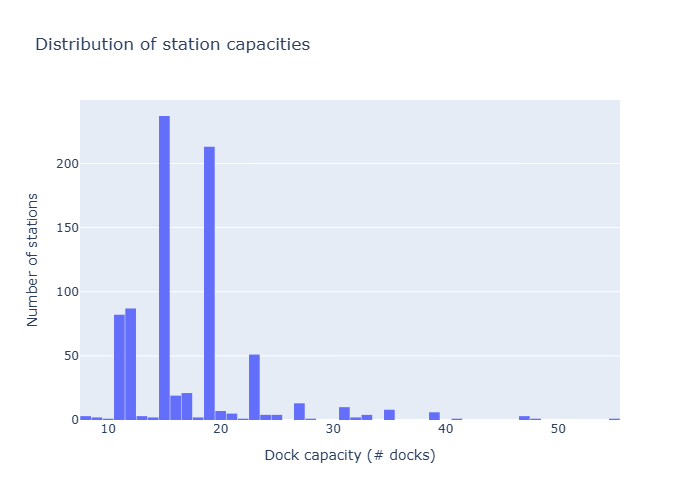

In [125]:



ST = stations_locations.copy()       
CAPACITY_COL = "CAPACITY"             
#! NBINS = 15                           


desc = (ST[CAPACITY_COL]
        .describe(percentiles=[0.25, 0.5, 0.75])
        .rename(index={"25%":"Q1", "50%":"Median", "75%":"Q3"}))
print("Capacity summary:\n", desc, "\n")


fig = px.histogram(
    ST, x=CAPACITY_COL,
    #! nbins=NBINS,
    labels={CAPACITY_COL: "Number of docks"},
    title="Distribution of station capacities",
    
)
fig.update_layout(
    xaxis_title="Dock capacity (# docks)",
    yaxis_title="Number of stations",
    bargap=0.05,
    
)
# fig.show()


* After this i decide to make the between 1 to 14 -> small , 15 to 25 Median and up 25 is large.

### I find there is problem in the Stations name and IDs i have after fill so i need fix this problem by mapping with the stations data

* normalize station names (lower-case), remap IDs from `stations.csv`

In [77]:

TRIPS        = CLEAN_DF.copy()                     
ST_REF       = stations   
OUT_PATH     = pathlib.Path("data/interim/trips_clean_names_ids.csv")


def clean_name(series: pd.Series) -> pd.Series:
    """strip, lower, normalise whitespace, replace & with 'and'."""
    return (
        series
        .astype("string")
        .str.strip()
        .str.lower()
        .str.replace("&", "and", regex=False)
        .str.replace(r"\s+", " ", regex=True)
    )

# 1 prepare reference table 
ST_REF["name_clean"] = clean_name(ST_REF["name"])

ST_REF = ST_REF.drop_duplicates("name_clean", keep="first")

name2id   = ST_REF.set_index("name_clean")["id"].to_dict()
id2name   = ST_REF.set_index("id")["name"].to_dict()

# 2) harmonise trip table 
for side in ("start", "end"):
    id_col, name_col = f"{side}_station_id", f"{side}_station_name"

    # a) normalise the trip names
    TRIPS[f"{name_col}_clean"] = clean_name(TRIPS[name_col])

    # b) where a name exists, overwrite/assign numeric ID from reference
    mask_name = TRIPS[f"{name_col}_clean"].notna()
    TRIPS.loc[mask_name, id_col] = TRIPS.loc[mask_name, f"{name_col}_clean"].map(name2id)

    # c) where numeric ID exists, overwrite name 
    mask_id = TRIPS[id_col].notna()
    TRIPS.loc[mask_id, name_col] = TRIPS.loc[mask_id, id_col].map(id2name)

# remove helper cols
TRIPS.drop(columns=["start_station_name_clean", "end_station_name_clean"], inplace=True)

# enforce nullable integer dtype
TRIPS[["start_station_id", "end_station_id"]] = TRIPS[["start_station_id", "end_station_id"]].astype("Int64")

# 3) - quick validation -
before_ids = CLEAN_DF[["start_station_id", "start_station_name"]].nunique()
after_ids  = TRIPS[["start_station_id", "start_station_name"]].nunique()

print("Before  | IDs:", before_ids.start_station_id, " Names:", before_ids.start_station_name)
print("After   | IDs:",  after_ids.start_station_id,  " Names:",  after_ids.start_station_name)

missing_names = TRIPS["start_station_name"].isna().sum() + TRIPS["end_station_name"].isna().sum()
print(f"Total rows still lacking a station *name*: {missing_names:,}")

# 4) save to disk
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
TRIPS.to_csv(OUT_PATH, index=False)
print(f"✅ Clean trips written to: {OUT_PATH.as_posix()}")


Before  | IDs: 1205  Names: 828
After   | IDs: 802  Names: 812
Total rows still lacking a station *name*: 0
✅ Clean trips written to: data/interim/trips_clean_names_ids.csv


In [78]:
TRIPS

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6109368  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6109369  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6109370  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6109371  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6109372  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                       ended_at start_station_name  start_station_id  \
0       2024-01-25 15:52:35.000      1st & O St NW             31519   
1       2024-01-02 16:53:25.000      1st & O St NW             31519   
2       2024-01-24 15:43:55.000      1st & O St NW             31519   
3       2024-01-04 15:37:35.000      1st & O St NW             31519   
4       2024-01-05 12:35:40.000      1st & O St NW             31519   
...                         ...                ...               ...   
6109368 2024-12-21 17:54:36.282     11th & M St NW             31266   
6109369 2024-12-07 10:52:42.706     11th & M St NW             31266   
6109370 2024-12-08 19:12:37.130     11th & M St NW             31266   
6109371 2024-12-26 11:57:38.459     11th & M St NW             31266   
6109372 2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6109368              8th & O St NW           31281  38.905578 -77.027313  ...   
6109369       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6109370  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6109371  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6109372             17th & P St NW           31330  38.905589 -77.027304  ...   

         end_in_cbd  cbd_fee passed_through_cbd  distance_to_cbd  near_cbd  \
0             False      0.0                  0       479.504566       1.0   
1             False      0.0                  0      1861.047871       1.0   
2             False      0.0                  0       479.504566       1.0   
3             False      0.0                  0       479.504566       1.0   
4              True      0.5                  1              NaN       NaN   
...             ...      ...                ...              ...       ...   
6109368       False      0.0                  0       727.931467       1.0   
6109369       False      0.0                  0      1425.439170       1.0   
6109370        True      0.5                  1              NaN       NaN   
6109371        True      0.5                  1              NaN       NaN   
6109372       False      0.0                  0       145.122207       1.0   

          ride_date    datetime               icon  weather_bin payment_day  
0        2024-01-25  2024-01-25               rain        rainy  2024-01-25  
1        2024-01-02  2024-01-02  partly-cloudy-day       cloudy  2024-01-02  
2        2024-01-24  2024-01-24             cloudy       cloudy  2024-01-24  
3        2024-01-04  2024-01-04  partly-cloudy-day       cloudy  2024-01-04  
4        2024-01-05  2024-01-05  par

## test the misteach names and IDs  

In [79]:

def missing_id_report(df, side="start", n=20):
    id_col, name_col = f"{side}_station_id", f"{side}_station_name"
    mask = df[id_col].isna() & df[name_col].notna()
    print(f"{mask.sum():,} rows where {id_col} is NA but {name_col} exists")
    return (
        df.loc[mask, name_col]
          .value_counts()
          .head(n)
    )

print(missing_id_report(TRIPS, "start"))
print("-"*40)
print(missing_id_report(TRIPS, "end"))


1,184 rows where start_station_id is NA but start_station_name exists
start_station_name
Martha Custis Dr & Lyons Ln             517
Witter Field                            156
Rock Creek Pkwy & Pkwy Dr NW            117
 Scotts Crossing Rd & Spring Gate Dr     89
N Shore Dr & Charter Oak Ct              76
Reston Cmty Ctr/Hunters Woods Plaza      73
Crabbs Branch Avenue & Gramercy Blvd     66
Motiva Greenbelt                         60
Herndon Metro South                      27
Monroe St & E Park Dr                     3
Name: count, dtype: int64
----------------------------------------
1,286 rows where end_station_id is NA but end_station_name exists
end_station_name
Martha Custis Dr & Lyons Ln             538
Witter Field                            164
Rock Creek Pkwy & Pkwy Dr NW            149
 Scotts Crossing Rd & Spring Gate Dr     91
N Shore Dr & Charter Oak Ct              80
Reston Cmty Ctr/Hunters Woods Plaza      76
Motiva Greenbelt                         70
Crabbs Branch

* drop trips with missing station IDs

In [80]:

# TRIPS is the dataframe you’ve been editing
before = len(TRIPS)

# mask for any remaining missing IDs (start OR end)
bad_mask = TRIPS["start_station_id"].isna() | TRIPS["end_station_id"].isna()
removed  = bad_mask.sum()

# keep only the good rows
TRIPS_CLEAN = TRIPS.loc[~bad_mask].copy()
after = len(TRIPS_CLEAN)

print(f"Rows removed : {removed:,}")
print(f"Rows kept    : {after:,}  ({after/before:.2%} of original)")

# optional sanity: make sure no NaNs left
assert TRIPS_CLEAN["start_station_id"].isna().sum() == 0
assert TRIPS_CLEAN["end_station_id"].isna().sum()   == 0

# save to CSV for next steps
out_path = pathlib.Path("data/interim/trips_no_missing_ids.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
TRIPS_CLEAN.to_csv(out_path, index=False)
print(f"✅ Clean file written → {out_path.as_posix()}")


Rows removed : 2,292
Rows kept    : 6,107,081  (99.96% of original)
✅ Clean file written → data/interim/trips_no_missing_ids.csv


### now we solve the problem we had the names and IDs is 801 as start and 799 as end stations.

### we will read the final saved data after all preprocessing 

In [81]:

CSV_PATH      = "data/interim/trips_no_missing_ids.csv"              
PARQUET_PATH  = "data/interim/trips_no_missing_ids.parquet"      


df_convert = pd.read_csv(CSV_PATH)

# create folders if they don’t exist
pathlib.Path(PARQUET_PATH).parent.mkdir(parents=True, exist_ok=True)

df_convert.to_parquet(PARQUET_PATH, index=False)
print(f"✅ Converted {CSV_PATH} → {PARQUET_PATH}  ({len(df):,} rows)")


✅ Converted data/interim/trips_no_missing_ids.csv → data/interim/trips_no_missing_ids.parquet  (6,114,279 rows)


In [82]:
TRIPS_clean = pd.read_parquet('data/interim/trips_no_missing_ids.parquet')

In [83]:
TRIPS_clean

ride_id  rideable_type               started_at  \
0        748A93D7DE8A41CD   classic_bike      2024-01-25 15:49:59   
1        75CBFD136F06305B   classic_bike      2024-01-02 16:44:58   
2        0536C9720F87E04C   classic_bike      2024-01-24 15:40:15   
3        9E17390C218783B5   classic_bike      2024-01-04 15:35:00   
4        00727D0E773CDFF7  electric_bike      2024-01-05 12:27:58   
...                   ...            ...                      ...   
6107076  4A88DDFF3CC6DBC3  electric_bike  2024-12-21 17:51:11.338   
6107077  E7EF3685AF27D2B1  electric_bike  2024-12-07 10:44:26.102   
6107078  C22CB37EBD0E2D8F  electric_bike  2024-12-08 19:09:28.769   
6107079  F7E04F0A6A7D290E  electric_bike  2024-12-26 11:52:51.207   
6107080  07C3226EDD82F144  electric_bike  2024-12-14 12:26:32.419   

                        ended_at start_station_name  start_station_id  \
0            2024-01-25 15:52:35      1st & O St NW             31519   
1            2024-01-02 16:53:25      1st & O St NW             31519   
2            2024-01-24 15:43:55      1st & O St NW             31519   
3            2024-01-04 15:37:35      1st & O St NW             31519   
4            2024-01-05 12:35:40      1st & O St NW             31519   
...                          ...                ...               ...   
6107076  2024-12-21 17:54:36.282     11th & M St NW             31266   
6107077  2024-12-07 10:52:42.706     11th & M St NW             31266   
6107078  2024-12-08 19:12:37.130     11th & M St NW             31266   
6107079  2024-12-26 11:57:38.459     11th & M St NW             31266   
6107080  2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6107076              8th & O St NW           31281  38.905578 -77.027313  ...   
6107077       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6107078  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6107079  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6107080             17th & P St NW           31330  38.905589 -77.027304  ...   

         end_in_cbd  cbd_fee passed_through_cbd  distance_to_cbd  near_cbd  \
0             False      0.0                  0       479.504566       1.0   
1             False      0.0                  0      1861.047871       1.0   
2             False      0.0                  0       479.504566       1.0   
3             False      0.0                  0       479.504566       1.0   
4              True      0.5                  1              NaN       NaN   
...             ...      ...                ...              ...       ...   
6107076       False      0.0                  0       727.931467       1.0   
6107077       False      0.0                  0      1425.439170       1.0   
6107078        True      0.5                  1              NaN       NaN   
6107079        True      0.5                  1              NaN       NaN   
6107080       False      0.0                  0       145.122207       1.0   

          ride_date    datetime               icon  weather_bin payment_day  
0        2024-01-25  2024-01-25               rain        rainy  2024-01-25  
1        2024-01-02  2024-01-02  partly-cloudy-day       cloudy  2024-01-02  
2        2024-01-24  2024-01-24             cloudy       cloudy  2024-01-24  
3        2024-01-04  2024-01-04  partly-cloudy-day       cloudy  2024-01-04  
4        202

### now we start in building CAPACITY feature

* This pipeline: attach capacity_start / capacity_end (+ buckets) to the trips table, using (1) exact name match, (2) nearest-station
fallback when names don’t match.

* the capacity ranges is [5-14 small, 15-25 medium, >=26 large]

In [84]:
# TODO:  check and remove the tripe_in 
#! TRIPS_IN  = "data/interim/trips_no_missing_ids.parquet"          # cleaned trips (IDs + names OK)
LIVE_CSV  = "data/raw/Capital_Bikeshare_Locations.csv"              # NAME, CAPACITY, LATITUDE, LONGITUDE
OUT_PARQ  = "data/interim/trips_capacity_ready.parquet"
DIST_LIM  = 150        # metres for spatial fallback
BINS      = [0, 5, 15, 26, np.inf]         
LABELS    = ["too_small", "small", "medium", "large"]
# ---------------------------------------------------------------

# 1) load
trips = TRIPS_clean
live  = pd.read_csv(LIVE_CSV, usecols=["NAME", "CAPACITY", "LATITUDE", "LONGITUDE"])

# 2 normalize naming
def norm(s: pd.Series) -> pd.Series:
    return (s.astype("string")
              .str.strip()
              .str.lower()
              .str.replace("&", "and", regex=False)
              .str.replace(r"\s+", " ", regex=True))

trips["start_clean"] = norm(trips["start_station_name"])
trips["end_clean"]   = norm(trips["end_station_name"])
live["name_clean"]   = norm(live["NAME"])

# 3) lookup dict: name_clean → capacity
cap_dict = (live.dropna(subset=["CAPACITY"])
                .drop_duplicates("name_clean")
                .set_index("name_clean")["CAPACITY"]
                .to_dict())

# attach by name
trips["capacity_start"] = trips["start_clean"].map(cap_dict)
trips["capacity_end"]   = trips["end_clean"].map(cap_dict)

# 4) spatial fallback for rows still NaN
coords_rad = np.deg2rad(live[["LATITUDE", "LONGITUDE"]].values)
tree       = BallTree(coords_rad, metric="haversine")
R          = 6_371_000   # earth radius in metres

def spatial_fill(df, side):
    cap_col, lat, lng = f"capacity_{side}", f"{side}_lat", f"{side}_lng"
    mask = df[cap_col].isna() & df[lat].notna() & df[lng].notna()
    if mask.any():
        qry = np.deg2rad(df.loc[mask, [lat, lng]].values)
        d, idx = tree.query(qry, k=1)
        m      = d[:, 0] * R
        ok     = m <= DIST_LIM
        rows   = df.loc[mask].index[ok]
        df.loc[rows, cap_col] = live.iloc[idx[ok, 0]]["CAPACITY"].values

spatial_fill(trips, "start")
spatial_fill(trips, "end")

# 5) buckets
trips["capacity_bucket_start"] = pd.cut(trips["capacity_start"], bins=BINS, labels=LABELS, right=False)
trips["capacity_bucket_end"]   = pd.cut(trips["capacity_end"],   bins=BINS, labels=LABELS, right=False)

# 6) report
print("NA counts after full process:")
print("  capacity_start :", trips['capacity_start'].isna().sum())
print("  capacity_end   :", trips['capacity_end'].isna().sum())

# 7) clean up helper cols and save
trips.drop(columns=["start_clean", "end_clean"], inplace=True)
pathlib.Path(OUT_PARQ).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(OUT_PARQ, index=False)
print(f"✅ trips with start/end capacity saved → {OUT_PARQ}")


NA counts after full process:
  capacity_start : 27547
  capacity_end   : 27833
✅ trips with start/end capacity saved → data/interim/trips_capacity_ready.parquet


* inspect which stations still lack capacity

In [85]:
# load the parquet we just saved
trips = pd.read_parquet("data/interim/trips_capacity_ready.parquet")

def missing_capacity_table(df, side, top_n=20):
    """
    Return a Series: station_id → number of rows whose capacity_<side> is NaN
    """
    id_col   = f"{side}_station_id"
    name_col = f"{side}_station_name"
    cap_col  = f"capacity_{side}"

    mask = df[cap_col].isna()
    return (
        df.loc[mask, [id_col, name_col]]
          .value_counts()
          .rename("rows")
          .head(top_n)
    )

print("\n=== Stations missing capacity_start ===")
missing_start = missing_capacity_table(trips, "start")
print(missing_start)

print("\n=== Stations missing capacity_end ===")
missing_end = missing_capacity_table(trips, "end")
print(missing_end)

# ------- intersection (same stations missing on both sides) ----------
ids_start = set(missing_start.index.get_level_values(0))    # station IDs
ids_end   = set(missing_end.index.get_level_values(0))

common = ids_start & ids_end
print(f"\nStations appearing in BOTH missing lists: {len(common)}")
if common:
    print(sorted(list(common))[:10], "...")  # show first 10 IDs



=== Stations missing capacity_start ===
start_station_id  start_station_name                          
31401             14th St & Spring Rd NW                          23684
31807             Pleasant St & MLK Ave SE                          851
32901             6035 Warehouse                                    436
32429             Bowdoin Ave & Calvert Rd/ College Park Metro      314
32069             Columbus Ave & Gramercy Blvd                      266
32227             Greensboro & Pinnacle Dr                          252
32217             Sunset Hills Rd & Discovery Square                227
32233             Jones Branch Drive & Scotts Crossing Rd           153
32007             E Montgomery Ave & Maryland Ave                   142
32241             Reston Pkwy & Bennington Woods Rd                 136
31329             White House                                       122
32256             North Village and Park Garden                     120
32033             Piccard & W Gu

* TO solve this we will propagate capacity values that exist elsewhere for the same ID

In [86]:
PARQUET_IN  = "data/interim/trips_capacity_ready.parquet"   
PARQUET_OUT = "data/interim/trips_capacity_propagated.parquet"

trips = pd.read_parquet(PARQUET_IN)

# ---------- 1) build id → capacity mapping from rows that ALREADY have a value ----------
capacity_map_start = (
    trips.dropna(subset=["capacity_start"])
         .groupby("start_station_id")["capacity_start"]
         .first()                   # أول قيمة متاحة
         .to_dict()
)

capacity_map_end = (
    trips.dropna(subset=["capacity_end"])
         .groupby("end_station_id")["capacity_end"]
         .first()
         .to_dict()
)

# ---------- 2) how many missing rows could be filled by that map? ----------
def preview_fill(df, side, cap_map, n=10):
    id_col  = f"{side}_station_id"
    cap_col = f"capacity_{side}"
    mask    = df[cap_col].isna() & df[id_col].map(cap_map).notna()
    print(f"{mask.sum():,} rows of {cap_col} can be filled from other rows (same ID).")
    return df.loc[mask, [id_col, cap_col]].head(n)

print(preview_fill(trips, "start", capacity_map_start))
print(preview_fill(trips, "end",   capacity_map_end))

# ---------- 3) actually fill -------------------------------------------
for side, cap_map in [("start", capacity_map_start),
                      ("end",   capacity_map_end)]:
    id_c, cap_c = f"{side}_station_id", f"capacity_{side}"
    mask = trips[cap_c].isna()
    trips.loc[mask, cap_c] = trips.loc[mask, id_c].map(cap_map)

# ---------- 4) rebuild buckets after propagation -----------------------
bins   = [0, 5, 15, 26, np.inf]
labels = ["too_small", "small", "medium", "large"]

trips["capacity_bucket_start"] = pd.cut(
    trips["capacity_start"], bins=bins, labels=labels, right=False
)
trips["capacity_bucket_end"] = pd.cut(
    trips["capacity_end"], bins=bins, labels=labels, right=False
)

# ---------- 5) report remaining gaps -----------------------------------
print("\nRemaining NaN counts AFTER propagation:")
print("  capacity_start :", trips['capacity_start'].isna().sum())
print("  capacity_end   :", trips['capacity_end'].isna().sum())

# ---------- 6) save -----------------------------------------------------
trips.to_parquet(PARQUET_OUT, index=False)
print(f"✅ Saved propagated-capacity file → {PARQUET_OUT}")


24,463 rows of capacity_start can be filled from other rows (same ID).
       start_station_id  capacity_start
22768             31133             NaN
29692             31401             NaN
32351             31401             NaN
38886             31401             NaN
38895             31401             NaN
39076             31401             NaN
39814             31401             NaN
40436             31401             NaN
40454             31401             NaN
40457             31401             NaN
24,318 rows of capacity_end can be filled from other rows (same ID).
      end_station_id  capacity_end
4888           31401           NaN
4915           31401           NaN
4981           31401           NaN
4999           31401           NaN
5021           31401           NaN
5080           31401           NaN
5091           31401           NaN
5150           31401           NaN
5293           31401           NaN
5323           31401           NaN

Remaining NaN counts AFTER propaga

In [87]:
# Count missing‐value rows for capacity_start and capacity_end
missing_start = trips["capacity_start"].isna().sum()
missing_end   = trips["capacity_end"].isna().sum()

# rows where *either* start or end capacity is missing
missing_any   = (
    trips["capacity_start"].isna() |
    trips["capacity_end"].isna()
).sum()

print(f"Rows with capacity_start = NaN : {missing_start:,}")
print(f"Rows with capacity_end   = NaN : {missing_end:,}")
print(f"Rows missing start *or* end   : {missing_any:,}")


Rows with capacity_start = NaN : 3,084
Rows with capacity_end   = NaN : 3,515
Rows missing start *or* end   : 5,785


### we see few missing values in capacity so we will drop it just 1903 rows 

In [88]:


PARQUET_IN  = "data/interim/trips_capacity_propagated.parquet"      
PARQUET_OUT = "data/interim/trips_capacity_complete.parquet"   


# 1) load
trips = pd.read_parquet(PARQUET_IN)
before = len(trips)

# 2) build mask and drop
mask_missing = trips["capacity_start"].isna() | trips["capacity_end"].isna()
removed      = mask_missing.sum()

trips_clean = trips.loc[~mask_missing].copy()
after = len(trips_clean)

print(f"Rows removed (missing capacity): {removed:,}")
print(f"Remaining rows                : {after:,}  ({after / before:.2%} of original)")

# 3) save to parquet
pathlib.Path(PARQUET_OUT).parent.mkdir(parents=True, exist_ok=True)
trips_clean.to_parquet(PARQUET_OUT, index=False)
print(f"✅ Saved clean file → {PARQUET_OUT}")


Rows removed (missing capacity): 5,785
Remaining rows                : 6,101,296  (99.91% of original)
✅ Saved clean file → data/interim/trips_capacity_complete.parquet


### check

In [89]:
# Count missing‐value rows for capacity_start and capacity_end
missing_start = trips_clean["capacity_start"].isna().sum()
missing_end   = trips_clean["capacity_end"].isna().sum()

# rows where *either* start or end capacity is missing
missing_any   = (
    trips_clean["capacity_start"].isna() |
    trips_clean["capacity_end"].isna()
).sum()

print(f"Rows with capacity_start = NaN : {missing_start:,}")
print(f"Rows with capacity_end   = NaN : {missing_end:,}")
print(f"Rows missing start *or* end   : {missing_any:,}")

Rows with capacity_start = NaN : 0
Rows with capacity_end   = NaN : 0
Rows missing start *or* end   : 0


## B5

### Build Feature (the nearest bus stop or metro)

#### As before we use the Ball Tree Algo while using the LATITUDE and LONGITUDE. 

* We will use the data "Shuttle_Bus_Stops.csv" for bus stops 
* We will use the data "Metro_Bus_Stops.csv" for metro

* compute distance to nearest BUS & METRO stops(start + end)

In [90]:

# Cell: compute distance to nearest BUS & METRO stops (start + end) and save to Parquet

#  FILE PATHS (edit if needed) 
TRIPS_IN   = "data/interim/trips_capacity_complete.parquet"   
BUS_CSV    = "data/raw/Shuttle_Bus_Stops.csv"
METRO_CSV  = "data/raw/Metro_Bus_Stops.csv"
OUT_PARQ   = "data/feature_engineered/trips_with_distances.parquet" 
EARTH_M    = 6_371_000      
#! here we make the max dist far than this we make it null we will try few values and see them 
DIST_CAP   = None           


# 1) -- load data ---------
trips = pd.read_parquet(TRIPS_IN)

bus   = pd.read_csv(BUS_CSV).dropna(subset=["LATITUDE", "LONGITUDE"])
metro = pd.read_csv(METRO_CSV).dropna(subset=["BSTP_LAT", "BSTP_LON"])

# 2) -- build BallTrees ---
bus_tree   = BallTree(np.deg2rad(bus[["LATITUDE", "LONGITUDE"]].to_numpy()),
                      metric="haversine")
metro_tree = BallTree(np.deg2rad(metro[["BSTP_LAT", "BSTP_LON"]].to_numpy()),
                      metric="haversine")

# helper → metres to nearest point for a given lat/lon pair
def nearest_metres(lat, lng, tree):
    ok = lat.notna() & lng.notna()
    result = np.full(len(lat), np.nan, dtype="float32")
    if ok.any():
        q = np.deg2rad(np.column_stack([lat[ok], lng[ok]]))
        d, _ = tree.query(q, k=1)
        result[ok] = (d[:,0] * EARTH_M).astype("float32")
    return result

# 3) -- compute distances -
trips["dist_bus_start"]   = nearest_metres(trips["start_lat"], trips["start_lng"], bus_tree)
trips["dist_metro_start"] = nearest_metres(trips["start_lat"], trips["start_lng"], metro_tree)
trips["dist_bus_end"]     = nearest_metres(trips["end_lat"],   trips["end_lng"],   bus_tree)
trips["dist_metro_end"]   = nearest_metres(trips["end_lat"],   trips["end_lng"],   metro_tree)

# 4) -- cap unreasonable outliers ---
if DIST_CAP is not None:
    for col in ["dist_bus_start","dist_bus_end","dist_metro_start","dist_metro_end"]:
        trips.loc[trips[col] > DIST_CAP, col] = np.nan

# 5) -- quick report ------
miss = trips[["dist_bus_start","dist_bus_end",
              "dist_metro_start","dist_metro_end"]].isna().sum()
print("Missing distance values after computation:\n", miss.to_string())

# 6) -- save -
pathlib.Path(OUT_PARQ).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(OUT_PARQ, index=False)
print(f"✅ trips_with_distances saved → {OUT_PARQ}")


Missing distance values after computation:
 dist_bus_start      0
dist_bus_end        0
dist_metro_start    0
dist_metro_end      0
✅ trips_with_distances saved → data/feature_engineered/trips_with_distances.parquet


`DIST_CAP` values (in meters) :
* `2500` the missing values of it were [dist_bus_start **238_000** ,dist_bus_end  **237_369** ,dist_metro_start   **295** ,dist_metro_end  **338**]
* `10000` the missing values of it were [dist_bus_start **20_702** ,dist_bus_end  **21_062** ,dist_metro_start   **10** ,dist_metro_end  **23**]
* `15000` the missing values of it were [dist_bus_start **8_129** ,dist_bus_end  **8_274** ,dist_metro_start   **10** ,dist_metro_end  **23**]
* `None` the missing values of it were [dist_bus_start **0** ,dist_bus_end  **0** ,dist_metro_start   **0**,dist_metro_end  **0**]

**the result after we see this the bus stations is few that the stations so it far from the stations but the there is a lot of metros stations that make them near to the stations (start or end stations)**

## B8

### build (Geographic Hashing) features for the trips 

In [91]:
# Cell: add Geohash (precision 7) columns for trip start & end

TRIPS_IN   = "data/feature_engineered/trips_with_distances.parquet"
OUT_PARQ   = "data/feature_engineered/trips_geohash_r7.parquet"
PRECISION  = 7                 #! 7-character geohash ≈ 153 m


# 1) load trips
trips = pd.read_parquet(TRIPS_IN)

# 2) vectorised encoder using numpy + python list (أسرع من apply)
def encode_series(lat, lon, precision):
    """
    Return list of geohash strings (length=precision) or None where lat/lon is NA.
    """
    return [
        pgh.encode(la, lo, precision=precision) if not np.isnan(la) and not np.isnan(lo) else None
        for la, lo in zip(lat, lon)
    ]

trips[f"gh_start_p{PRECISION}"] = encode_series(trips["start_lat"], trips["start_lng"], PRECISION)
trips[f"gh_end_p{PRECISION}"]   = encode_series(trips["end_lat"],   trips["end_lng"],   PRECISION)

# 3) quick QA
missing_start = trips[f"gh_start_p{PRECISION}"].isna().sum()
missing_end   = trips[f"gh_end_p{PRECISION}"].isna().sum()
print(f"Missing geohash (start): {missing_start:,}")
print(f"Missing geohash (end)  : {missing_end:,}")

# 4) save
pathlib.Path(OUT_PARQ).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(OUT_PARQ, index=False)
print(f"✅ trips with geohash(p={PRECISION}) saved → {OUT_PARQ}")


Missing geohash (start): 0
Missing geohash (end)  : 0
✅ trips with geohash(p=7) saved → data/feature_engineered/trips_geohash_r7.parquet


* **I choose 7 letters like 153*153 m and here i have 2M trip so will make this around 2000 to 3000 cells.**  

| طول السلسلة | بُعد الخلية (DC تقريبًا) | ملائم لـ                                       |
| ----------- | ------------------------ | ---------------------------------------------- |
| 6 حروف      | \~ 610 م × 610 م         | تحليلات إقليمية                                |
| **7 حروف**  | **\~ 153 م × 153 م**     |  يجمع 1-3 محطات |
| 8 حروف      | \~ 19 م × 19 م           | مستوى “محطة واحدة” لكن يزيد الحجم              |


* and every letter increase the bits `5` 

## B9

### Build the three sections (clusters) for GEO

#### we do it based on the Start trips GEO

In [92]:
TRIPS_PATH = "data/feature_engineered/trips_geohash_r7.parquet"
trips = pd.read_parquet(TRIPS_PATH)

In [93]:
trips["started_at"] = pd.to_datetime(
    trips["started_at"],
    format="mixed",        #  ⬅️ يسمح بتنسيقات متعدّدة
    errors="coerce"        # يحوّل القيم الشاذّة إلى NaT بدلاً من الخطأ
)

In [94]:
trips

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6101291  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6101292  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6101293  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6101294  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6101295  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                        ended_at start_station_name  start_station_id  \
0            2024-01-25 15:52:35      1st & O St NW             31519   
1            2024-01-02 16:53:25      1st & O St NW             31519   
2            2024-01-24 15:43:55      1st & O St NW             31519   
3            2024-01-04 15:37:35      1st & O St NW             31519   
4            2024-01-05 12:35:40      1st & O St NW             31519   
...                          ...                ...               ...   
6101291  2024-12-21 17:54:36.282     11th & M St NW             31266   
6101292  2024-12-07 10:52:42.706     11th & M St NW             31266   
6101293  2024-12-08 19:12:37.130     11th & M St NW             31266   
6101294  2024-12-26 11:57:38.459     11th & M St NW             31266   
6101295  2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6101291              8th & O St NW           31281  38.905578 -77.027313  ...   
6101292       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6101293  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101294  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101295             17th & P St NW           31330  38.905589 -77.027304  ...   

         capacity_start  capacity_end capacity_bucket_start  \
0                  15.0          19.0                medium   
1                  15.0          15.0                medium   
2                  15.0          19.0                medium   
3                  15.0          19.0                medium   
4                  15.0          23.0                medium   
...                 ...           ...                   ...   
6101291            23.0          19.0                medium   
6101292            23.0          15.0                medium   
6101293            23.0          27.0                medium   
6101294            23.0          27.0                medium   
6101295            23.0          19.0                medium   

         capacity_bucket_end  dist_bus_start  dist_metro_start dist_bus_end  \
0                     medium      740.869568        289.051819   243.168167   
1                     medium      740.869568        289.051819   654.108276   
2                     medium      740.869568        289.051819   243.168167   
3                     medium      740.869568        289.051819   243.168167   
4                     medium      746.669739        283.491394   164.067368   
...                      ...             ...               ...          ...   
6101291               medium      499.010

In [95]:
# import pandas as pd
# import plotly.express as px

TRIPS_PATH = "data/feature_engineered/trips_geohash_r7.parquet"
GEO_COL    = "gh_start_p7"      # use gh_end_p7 if you prefer the destination side

# 1) load and compute daily trip counts per geohash
trips = pd.read_parquet(TRIPS_PATH)
# trips["date"] = trips["started_at"].dt.date

# ensure started_at is datetime
trips["started_at"] = pd.to_datetime(
    trips["started_at"],
    format="mixed",        #  ⬅️ يسمح بتنسيقات متعدّدة
    errors="coerce"        # يحوّل القيم الشاذّة إلى NaT بدلاً من الخطأ
)

trips["date"] = trips["started_at"].dt.date  # or .dt.date

daily = (
    trips.groupby([GEO_COL, "date"])
         .size()
         .rename("trips_per_day")
         .reset_index()
)

# 2) mean daily trips for each geohash cell
mean_daily = (
    daily.groupby(GEO_COL)["trips_per_day"]
         .mean()
         .rename("mean_daily_trips")
         .reset_index()
)

# 3) interactive histogram
fig = px.histogram(
    mean_daily,
    x="mean_daily_trips",
    nbins=50,
    title="Distribution of mean daily trips per geohash cell (precision 7)",
    labels={"mean_daily_trips": "Mean trips per day"}
)
fig.update_layout(bargap=0.05, xaxis_title="Mean trips / day",
                  yaxis_title="Number of geohash cells", height=450)
fig.show()


* That show the most GEO Cells have between 1 or 2 trip per day around `2000` Cells
* So we will make the Cell threshold {low(gray): [0-2], Medium(yellow): [3-10], High(red): [+11]}
* I made these Cells because of the number 2 is The big block separates the rest of data and the number 10 is the beginning of the tail.

In [96]:
# ===============================================================
# Cell: classify geohash cells into demand tiers (red, yellow, gray)
# ===============================================================
# import pandas as pd
# import numpy as np
# import pathlib

# -------- CONFIG -----------------------------------------------
TRIPS_IN     = "data/feature_engineered/trips_geohash_r7.parquet"  # الملف الناتج من خطوة الـ Geohash
GEO_COL      = "gh_start_p7"      # الخلية التى سنقيس بها الطلب (يمكن تبديلها بالـ end)
OUT_PARQUET  = "data/feature_engineered/trips_with_demand_tier.parquet"
# ---------------------------------------------------------------

# 1) load trips
trips = pd.read_parquet(TRIPS_IN)

# 2) compute daily trip count per cell
# trips["date"] = trips["started_at"].dt.date       # تأكد أن العمود موجود

# ensure started_at is datetime
trips["started_at"] = pd.to_datetime(
    trips["started_at"],
    format="mixed",        #  ⬅️ يسمح بتنسيقات متعدّدة
    errors="coerce"        # يحوّل القيم الشاذّة إلى NaT بدلاً من الخطأ
)

trips["date"] = trips["started_at"].dt.normalize() # or .dt.date

daily = (
    trips.groupby([GEO_COL, "date"])
         .size()
         .rename("trips_per_day")
         .reset_index()
)

# 3) mean daily trips for each cell
cell_mean = (
    daily.groupby(GEO_COL)["trips_per_day"]
         .mean()
         .rename("mean_daily_trips")
)

# 4) join back to trips (map)
trips = trips.merge(cell_mean, left_on=GEO_COL, right_index=True, how="left")

# # 5) define buckets by quantiles (25-% و 75-%)
# q1, q3 = cell_mean.quantile([0.25, 0.75])
q1 = 2
q3 = 10
def tier(val):
    if pd.isna(val):
        return "unknown"
    if val <= q1:
        return "gray"
    if val <= q3:
        return "yellow"
    return "red"

trips["demand_tier"] = trips["mean_daily_trips"].apply(tier)

print("Quantile thresholds:")
print(f"  Q1  = {q1:.1f} trips/day")
print(f"  Q3 = {q3:.1f} trips/day")
print("\nTier counts:")
print(trips["demand_tier"].value_counts())

# 6) save
pathlib.Path(OUT_PARQUET).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(OUT_PARQUET, index=False)
print(f"✅ trips_with_demand_tier saved → {OUT_PARQUET}")


Quantile thresholds:
  Q1  = 2.0 trips/day
  Q3 = 10.0 trips/day

Tier counts:
demand_tier
red       5265066
yellow     739808
gray        96422
Name: count, dtype: int64
✅ trips_with_demand_tier saved → data/feature_engineered/trips_with_demand_tier.parquet


In [97]:
trips = pd.read_parquet('data/feature_engineered/trips_with_demand_tier.parquet')
trips

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6101291  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6101292  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6101293  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6101294  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6101295  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                        ended_at start_station_name  start_station_id  \
0            2024-01-25 15:52:35      1st & O St NW             31519   
1            2024-01-02 16:53:25      1st & O St NW             31519   
2            2024-01-24 15:43:55      1st & O St NW             31519   
3            2024-01-04 15:37:35      1st & O St NW             31519   
4            2024-01-05 12:35:40      1st & O St NW             31519   
...                          ...                ...               ...   
6101291  2024-12-21 17:54:36.282     11th & M St NW             31266   
6101292  2024-12-07 10:52:42.706     11th & M St NW             31266   
6101293  2024-12-08 19:12:37.130     11th & M St NW             31266   
6101294  2024-12-26 11:57:38.459     11th & M St NW             31266   
6101295  2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6101291              8th & O St NW           31281  38.905578 -77.027313  ...   
6101292       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6101293  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101294  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101295             17th & P St NW           31330  38.905589 -77.027304  ...   

         capacity_bucket_end  dist_bus_start dist_metro_start  dist_bus_end  \
0                     medium      740.869568       289.051819    243.168167   
1                     medium      740.869568       289.051819    654.108276   
2                     medium      740.869568       289.051819    243.168167   
3                     medium      740.869568       289.051819    243.168167   
4                     medium      746.669739       283.491394    164.067368   
...                      ...             ...              ...           ...   
6101291               medium      499.010559        31.266451    381.550354   
6101292               medium      499.010559        31.266451    571.522583   
6101293                large      499.010559        31.266451    164.235321   
6101294                large      499.010559        31.266451    164.235321   
6101295               medium      499.945496        29.924244    326.346191   

         dist_metro_end  gh_start_p7 gh_end_p7       date  mean_daily_trips  \
0            155.780136      dqcjre1   dqcjrd1 2024-01-25         33.112022   
1            194.085724      dqcjre1   dqcjrmm 2024-01-02         33.112022   
2            155.780136      dqcjre1   dqcjrd1 2024-01-24         33.112022   
3            155.780136      dqcjre1   dqcjrd1 2024-01-04         33.112022   
4      

* we have to check if the result is correct or is it bad in the logic so we will count how many GEO Cells in each section 

In [98]:
cell_tiers = (
    trips.drop_duplicates("gh_start_p7")[["gh_start_p7","mean_daily_trips","demand_tier"]]
            .value_counts("demand_tier")
)
print(cell_tiers)


demand_tier
gray      2701
yellow     630
red        415
Name: count, dtype: int64


* We find it so good in logic around the 10 % of cells is red and in the Trips data is normal to see 63% of trips is in red section

[ `quality_flag`, `capacity_start`, `capacity_end`,`date`,`mean_daily_trips`] i want to drop these helper columns. 

In [99]:
PARQUET_IN  = "data/feature_engineered/trips_demand_tier_custom.parquet" 

trips = pd.read_parquet('data/feature_engineered/trips_with_demand_tier.parquet')
trips

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6101291  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6101292  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6101293  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6101294  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6101295  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                        ended_at start_station_name  start_station_id  \
0            2024-01-25 15:52:35      1st & O St NW             31519   
1            2024-01-02 16:53:25      1st & O St NW             31519   
2            2024-01-24 15:43:55      1st & O St NW             31519   
3            2024-01-04 15:37:35      1st & O St NW             31519   
4            2024-01-05 12:35:40      1st & O St NW             31519   
...                          ...                ...               ...   
6101291  2024-12-21 17:54:36.282     11th & M St NW             31266   
6101292  2024-12-07 10:52:42.706     11th & M St NW             31266   
6101293  2024-12-08 19:12:37.130     11th & M St NW             31266   
6101294  2024-12-26 11:57:38.459     11th & M St NW             31266   
6101295  2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6101291              8th & O St NW           31281  38.905578 -77.027313  ...   
6101292       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6101293  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101294  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101295             17th & P St NW           31330  38.905589 -77.027304  ...   

         capacity_bucket_end  dist_bus_start dist_metro_start  dist_bus_end  \
0                     medium      740.869568       289.051819    243.168167   
1                     medium      740.869568       289.051819    654.108276   
2                     medium      740.869568       289.051819    243.168167   
3                     medium      740.869568       289.051819    243.168167   
4                     medium      746.669739       283.491394    164.067368   
...                      ...             ...              ...           ...   
6101291               medium      499.010559        31.266451    381.550354   
6101292               medium      499.010559        31.266451    571.522583   
6101293                large      499.010559        31.266451    164.235321   
6101294                large      499.010559        31.266451    164.235321   
6101295               medium      499.945496        29.924244    326.346191   

         dist_metro_end  gh_start_p7 gh_end_p7       date  mean_daily_trips  \
0            155.780136      dqcjre1   dqcjrd1 2024-01-25         33.112022   
1            194.085724      dqcjre1   dqcjrmm 2024-01-02         33.112022   
2            155.780136      dqcjre1   dqcjrd1 2024-01-24         33.112022   
3            155.780136      dqcjre1   dqcjrd1 2024-01-04         33.112022   
4      

In [100]:
PARQUET_IN  = "data/feature_engineered/trips_with_demand_tier.parquet" 
PARQUET_OUT = "data/final_stage_results/final_trips_ready.parquet" 
HELPER_COLS = [
    "quality_flag",
    "capacity_start",
    "capacity_end",
    "date",
    "mean_daily_trips",
]


#  load
trips = pd.read_parquet(PARQUET_IN)

#  drop helper columns if they exist
trips = trips.drop(columns=[c for c in HELPER_COLS if c in trips.columns])


# rename demand_tier → trip_demand_level (feel free to adjust)
trips = trips.rename(columns={"demand_tier": "trip_demand_level"})

# Save
pathlib.Path(PARQUET_OUT).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(PARQUET_OUT, index=False)
print(f"✅ Saved clean file (helper columns removed) → {PARQUET_OUT}")


✅ Saved clean file (helper columns removed) → data/final_stage_results/final_trips_ready.parquet


In [101]:
trips

ride_id  rideable_type              started_at  \
0        748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59.000   
1        75CBFD136F06305B   classic_bike 2024-01-02 16:44:58.000   
2        0536C9720F87E04C   classic_bike 2024-01-24 15:40:15.000   
3        9E17390C218783B5   classic_bike 2024-01-04 15:35:00.000   
4        00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58.000   
...                   ...            ...                     ...   
6101291  4A88DDFF3CC6DBC3  electric_bike 2024-12-21 17:51:11.338   
6101292  E7EF3685AF27D2B1  electric_bike 2024-12-07 10:44:26.102   
6101293  C22CB37EBD0E2D8F  electric_bike 2024-12-08 19:09:28.769   
6101294  F7E04F0A6A7D290E  electric_bike 2024-12-26 11:52:51.207   
6101295  07C3226EDD82F144  electric_bike 2024-12-14 12:26:32.419   

                        ended_at start_station_name  start_station_id  \
0            2024-01-25 15:52:35      1st & O St NW             31519   
1            2024-01-02 16:53:25      1st & O St NW             31519   
2            2024-01-24 15:43:55      1st & O St NW             31519   
3            2024-01-04 15:37:35      1st & O St NW             31519   
4            2024-01-05 12:35:40      1st & O St NW             31519   
...                          ...                ...               ...   
6101291  2024-12-21 17:54:36.282     11th & M St NW             31266   
6101292  2024-12-07 10:52:42.706     11th & M St NW             31266   
6101293  2024-12-08 19:12:37.130     11th & M St NW             31266   
6101294  2024-12-26 11:57:38.459     11th & M St NW             31266   
6101295  2024-12-14 12:32:56.165     11th & M St NW             31266   

                  end_station_name  end_station_id  start_lat  start_lng  ...  \
0                    1st & L St NW           31677  38.908643 -77.012365  ...   
1              4th & College St NW           31138  38.908643 -77.012365  ...   
2                    1st & L St NW           31677  38.908643 -77.012365  ...   
3                    1st & L St NW           31677  38.908643 -77.012365  ...   
4                   10th & G St NW           31274  38.908690 -77.012317  ...   
...                            ...             ...        ...        ...  ...   
6101291              8th & O St NW           31281  38.905578 -77.027313  ...   
6101292       14th & Belmont St NW           31119  38.905578 -77.027313  ...   
6101293  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101294  13th St & New York Ave NW           31227  38.905578 -77.027313  ...   
6101295             17th & P St NW           31330  38.905589 -77.027304  ...   

         payment_day  capacity_bucket_start capacity_bucket_end  \
0         2024-01-25                 medium              medium   
1         2024-01-02                 medium              medium   
2         2024-01-24                 medium              medium   
3         2024-01-04                 medium              medium   
4         2024-01-05                 medium              medium   
...              ...                    ...                 ...   
6101291   2024-12-21                 medium              medium   
6101292   2024-12-07                 medium              medium   
6101293   2024-12-08                 medium               large   
6101294   2024-12-26                 medium               large   
6101295   2024-12-14                 medium              medium   

         dist_bus_start  dist_metro_start  dist_bus_end dist_metro_end  \
0            740.869568        289.051819    243.168167     155.780136   
1            740.869568        289.051819    654.108276     194.085724   
2            740.869568        289.051819    243.168167     155.780136   
3            740.869568        289.051819    243.168167     155.780136   
4            746.669739        283.491394    164.067368      59.092266   
...                 ...               ...           ...            ...   
6101291      499.010559     

In [102]:
# دمج الإيرادات اليومية على أساس يوم الدفع
trips = trips.merge(
    daily_summary[['payment_day', 'daily_total_revenue']],
    on='payment_day',
    how='left'
)

In [103]:
# Save
pathlib.Path(PARQUET_OUT).parent.mkdir(parents=True, exist_ok=True)
trips.to_parquet(PARQUET_OUT, index=False)
print(f"✅ Saved clean file (helper columns removed) → {PARQUET_OUT}")

✅ Saved clean file (helper columns removed) → data/final_stage_results/final_trips_ready.parquet


In [104]:
trips_test = pd.read_parquet('data/final_stage_results/final_trips_ready.parquet')

# 2. Exploration and analysis

1. load the data we had 

In [4]:
MAIN_DF = pd.read_parquet('data/final_stage_results/final_trips_ready.parquet')

In [6]:
print(MAIN_DF.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'year', 'month', 'day', 'weekday', 'duration_minutes',
       'total_cost', 'start_point', 'end_point', 'start_in_cbd', 'end_in_cbd',
       'cbd_fee', 'passed_through_cbd', 'distance_to_cbd', 'near_cbd',
       'ride_date', 'datetime', 'icon', 'weather_bin', 'payment_day',
       'capacity_bucket_start', 'capacity_bucket_end', 'dist_bus_start',
       'dist_metro_start', 'dist_bus_end', 'dist_metro_end', 'gh_start_p7',
       'gh_end_p7', 'trip_demand_level', 'daily_total_revenue'],
      dtype='object')


In [107]:
MAIN_DF.head()

ride_id  rideable_type          started_at             ended_at  \
0  748A93D7DE8A41CD   classic_bike 2024-01-25 15:49:59  2024-01-25 15:52:35   
1  75CBFD136F06305B   classic_bike 2024-01-02 16:44:58  2024-01-02 16:53:25   
2  0536C9720F87E04C   classic_bike 2024-01-24 15:40:15  2024-01-24 15:43:55   
3  9E17390C218783B5   classic_bike 2024-01-04 15:35:00  2024-01-04 15:37:35   
4  00727D0E773CDFF7  electric_bike 2024-01-05 12:27:58  2024-01-05 12:35:40   

  start_station_name  start_station_id     end_station_name  end_station_id  \
0      1st & O St NW             31519        1st & L St NW           31677   
1      1st & O St NW             31519  4th & College St NW           31138   
2      1st & O St NW             31519        1st & L St NW           31677   
3      1st & O St NW             31519        1st & L St NW           31677   
4      1st & O St NW             31519       10th & G St NW           31274   

   start_lat  start_lng  ...  capacity_bucket_start  capacity_bucket_end  \
0  38.908643 -77.012365  ...                 medium               medium   
1  38.908643 -77.012365  ...                 medium               medium   
2  38.908643 -77.012365  ...                 medium               medium   
3  38.908643 -77.012365  ...                 medium               medium   
4  38.908690 -77.012317  ...                 medium               medium   

  dist_bus_start  dist_metro_start  dist_bus_end  dist_metro_end gh_start_p7  \
0     740.869568        289.051819    243.168167      155.780136     dqcjre1   
1     740.869568        289.051819    654.108276      194.085724     dqcjre1   
2     740.869568        289.051819    243.168167      155.780136     dqcjre1   
3     740.869568        289.051819    243.168167      155.780136     dqcjre1   
4     746.669739        283.491394    164.067368       59.092266     dqcjre1   

   gh_end_p7  trip_demand_level daily_total_revenue  
0    dqcjrd1                red                 NaN  
1    dqcjrmm                red                 NaN  
2    dqcjrd1                red                 NaN  
3    dqcjrd1                red                 NaN  
4    dqcjr1p                red                 NaN  

[5 rows x 42 columns]

In [108]:
print(MAIN_DF.shape)

(6101296, 42)


## B

### دراسة مدة الرحلة

### توزع مدة الرحلة بالدقائق
<div dir="rtl">

 - سيتم تحديد عدد الأشرطة وذلك بناءً على قاعدة Freedman-Diaconis حيث هي قاعدة إحصائية تأخذ بعين الاعتبار مدى التشتت وعدد العينات
 </div>



<div dir="rtl">

  - IQR: هو المدى بين الربيعي (interquartile range) للبيانات، وهو الفرق بين الربيعي الثالث (75th percentile) والربيعي الأول (25th percentile).
  - n: عدد العينات  

</div>

<div dir="rtl">

ومن ثم نقوم بحساب هذه المعادلة:


</div>

المصدر :
- [wikipidea]
- [Medium]


In [5]:
bike_data_fin = MAIN_DF

In [8]:
negative_durations_count = (bike_data_fin['duration_minutes'] > 100).sum()

print(f"عدد الرحلات أكبر من مئة {negative_durations_count}")

عدد الرحلات أكبر من مئة 54960


- وجدنا عدد الرحلات التي أكبر من مئة دقيقة هو 17904 وهو لا يقارن بحجم الداتا التي هي عبارة عن ما يقارب المليونين عينة
- فلذلك سنرسم المخططات بلاهم وذلك من أجل جعل المخطط مفهوم وأكثر واقعية ونستطيع أن نستنتج منه

In [9]:
valid_durations = bike_data_fin['duration_minutes']
durations = valid_durations[valid_durations < 100]

# calc IQR
q75, q25 = np.percentile(durations, [75 ,25])
iqr = q75 - q25

# calc Bin Width
bin_width = 2 * iqr / (len(durations) ** (1/3))

# calc Bin Count
bin_count = int((durations.max() - durations.min()) / bin_width)
print(f"Bin Count : {bin_count}")

Bin Count : 834


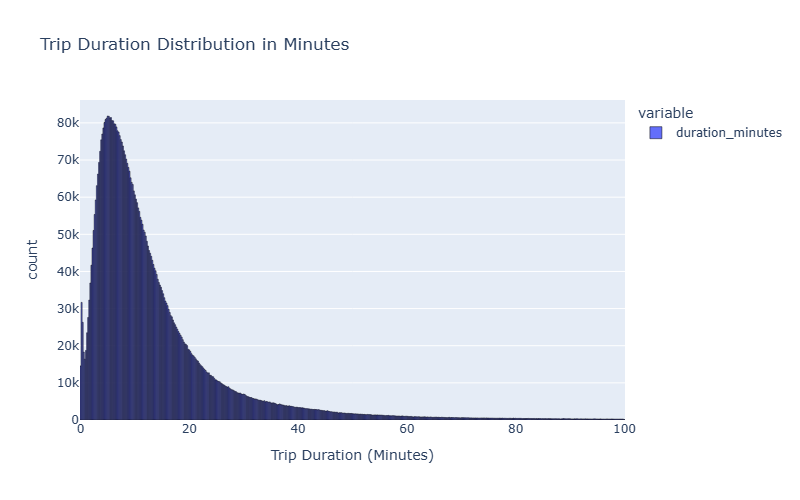

In [10]:
# Your existing code to create the figure
fig = px.histogram(
    durations,
    nbins=bin_count,
    labels={'value': 'Trip Duration (Minutes)'},
    title='Trip Duration Distribution in Minutes'
)

# Your existing styling
fig.update_traces(marker=dict(line=dict(width=0.5, color='black')))
fig.update_layout(
    bargap=0.1,
    hovermode=False,
    dragmode=False
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))

# Optional: Save the image to file
# fig.write_image("trip_duration_distribution.png", scale=2)

#### ملاحظات
<div dir="rtl">

 - نلاحظ أن التوزع الطبيعي لمدة معظم الرحلات هو بين 5 دقائق
 - حيث نجد أن معظم الرحلات تتراوح مدتها بين ال5 دقائق إلى 12 دقائق مما يعني أن النطاق المعظم للرحلات هو هذا حيث يمثل شريحة كبيرة من الرحلات
 - ومع ازدياد الوقت نرى تراجع بعدد الرحلات بشكل مطرد وسريع على سبيل المثال عند ال 20 دقيقة نرى ان العدد قد انخفض إلى ال5000 وعند ال 40 دقيقة يصبح العدد قليلاً جدا ربما لا يتجاوز ال2000 وعند 60 دقيقة يصبح عدد الرحلات أقل وهكذا




 </div>

In [ ]:

bike_data_subset = bike_data_fin[['rideable_type', 'duration_minutes']].dropna()




# Your existing code to create the figure
fig1 = px.box(
    bike_data_subset,
    x='rideable_type',
    y='duration_minutes',
    # points = False,
    points=False,
    title='Distribution of Trip Duration by Bike Type',
    labels={
        'rideable_type': 'Bike Type',
        'duration_minutes': 'Duration (Minutes)'
    }
)

# Your existing styling
fig1.update_layout(
    hovermode=False,
    dragmode=False,
    font=dict(family="Arial, sans-serif", size=12),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='lightgray')
)

print('Box plot created')
# # Convert to static image and display
# png_bytes = fig1.to_image(format="png", width=500, height=350, engine="kaleido" , scale=1 )
# print('Image converted')
# display(Image(data=png_bytes))

fig1.show()

# fig1.write_image("duration_by_bike_type.png", scale=2)

Box plot created


### استنتاج المخطط
 - الدراجات العادية  تسجل رحلات بمدد أطول بكثير مقارنة بالدراجات الكهربائية. حيث وصل أقصى مدى لبعض رحلات الدراجات العادية إلى حوالي 1600 دقيقة (أكثر من 26 ساعة)، بينما لم تتجاوز أطول رحلات الدراجات الكهربائية حوالي 500 دقيقة (حوالي 8 ساعات).

 - أيضا نلاحظ أن في كلا النوعين أن الغالبية العظمى من الرحلات قصيرة

###### تفسير منطقي:
حسب رؤيتي ربما أن الدراجات الكلاسيكية قادرة على قطع رحلات طويلة جدا او استخدامها في مسارات محددة مثلا ذهاب والتنزه بها أو ربما البعض يأخذها كرياضة
أو حتى ربما لم يتم إعادة هذه الدراجات العادية إلى مكانها الصحيح أي لم يتم تثبيتها بشكل مناسب لفترة طويلة

أما بالنسبة للدراجات الكهربائية فربما بسبب أن بطارياتها لا تستطيع قطع رحلات طويلة

In [ ]:
# Your existing code to create the figure
fig2 = px.box(
    bike_data_fin,
    x='member_casual',
    y='duration_minutes',
    points='outliers',
    title='Distribution of Trip Duration by User Type',
    labels={
        'member_casual': 'Subscription Type',
        'duration_minutes': 'Duration (Minutes)'
    }
)

# Enhanced styling for better clarity
fig2.update_layout(
    hovermode=False,
    dragmode=False,
    font=dict(family="Arial, sans-serif", size=12),
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=False,
        title_font=dict(size=14)
    ),
    yaxis=dict(
        gridcolor='lightgray',
        title_font=dict(size=14)
    ),
    title_font=dict(size=16)
)

# Add annotations for better interpretation
fig2.add_annotation(
    x=0.5, y=0.95,
    xref="paper", yref="paper",
    text="Casual users typically take longer trips",
    showarrow=False,
    font=dict(size=12)
)

print('Box plot created')

fig2.show()
# Convert to static image and display
# png_bytes = fig2.to_image(format="png", width=600, height=400, engine="kaleido")
# display(Image(data=png_bytes))

# # Optional: Save the image to file
# fig2.write_image("duration_by_user_type.png", scale=2)

Box plot created


### استنتاج مخطط مدة الرحلات حسب نوع الاشتراك
 - نجد أن الأنماط الأكثر شيوعا للرحلات متماثلة عند كل من النوعين

 - وأن أيضاً الرحلات الطويلة (المتطرفة) تحدث لكلا النوعين بنفس المدة القصوى
 - يظهر المخطط أن كلاً من المستخدمين العاديين والأعضاء يقومون برحلات طويلة جداً وغير اعتيادية بنفس الشيء

 - وهذا ينفي فكرة انه إذا كان عضو فربما هو من يقوم بالرحلات الطويلة نظراً لاشتراكهم

In [6]:
df_long_rides = bike_data_fin[bike_data_fin['duration_minutes'] > 1440].copy()

In [7]:
df_long_rides  = bike_data_fin[bike_data_fin['duration_minutes'] > 1440]

In [8]:
start_stations_long_rides = df_long_rides.groupby(['start_station_id', 'start_station_name', 'start_lat', 'start_lng']).size().reset_index(name='long_rides_count_start')
end_stations_long_rides = df_long_rides.groupby(['end_station_id', 'end_station_name', 'end_lat', 'end_lng']).size().reset_index(name='long_rides_count_end')

In [9]:
start_stations_long_rides = start_stations_long_rides.rename(columns={
        'start_station_id': 'station_id',
        'start_station_name': 'station_name',
        'start_lat': 'latitude',
        'start_lng': 'longitude'
    })
end_stations_long_rides = end_stations_long_rides.rename(columns={
        'end_station_id': 'station_id',
        'end_station_name': 'station_name',
        'end_lat': 'latitude',
        'end_lng': 'longitude'
    })

In [10]:
all_stations_long_rides = pd.merge(
        start_stations_long_rides,
        end_stations_long_rides,
        on=['station_id', 'station_name', 'latitude', 'longitude'],
        how='outer'
    ).fillna(0)

In [11]:
all_stations_long_rides['total_long_rides'] = all_stations_long_rides['long_rides_count_start'] + all_stations_long_rides['long_rides_count_end']

In [12]:
geometry = [Point(xy) for xy in zip(all_stations_long_rides['longitude'], all_stations_long_rides['latitude'])]
gdf_stations = gpd.GeoDataFrame(all_stations_long_rides, geometry=geometry, crs="EPSG:4326")

In [13]:
dc_bounds = {
      'min_lat': 38.75,
      'max_lat': 39.00,
      'min_lng': -77.15,
      'max_lng': -76.85
  }

In [16]:
gdf_basemap = residential_zones

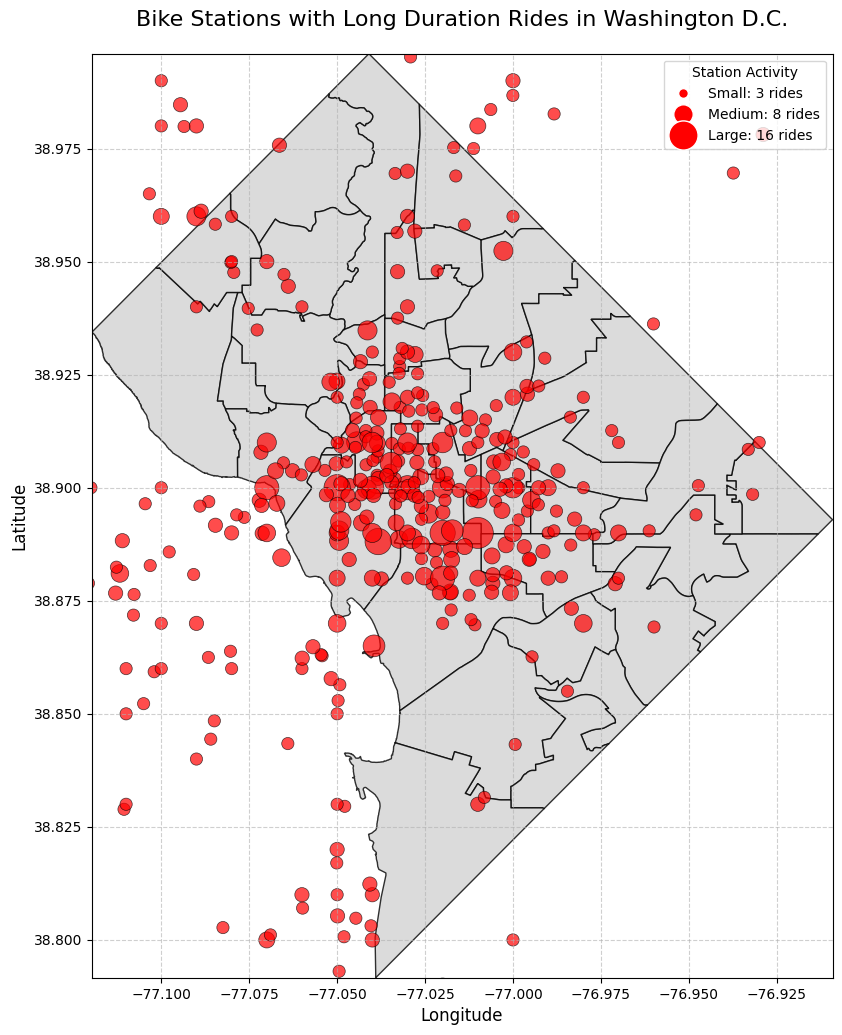

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import io
from IPython.display import Image

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Set up the basemap
if gdf_basemap is not None:
    # Plot basemap
    gdf_basemap.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.8)
    ax.set_xlim(gdf_basemap.total_bounds[0], gdf_basemap.total_bounds[2])
    ax.set_ylim(gdf_basemap.total_bounds[1], gdf_basemap.total_bounds[3])
else:
    # Use approximate DC bounds
    dc_bounds = {'min_lat': 38.75, 'max_lat': 39.00, 'min_lng': -77.15, 'max_lng': -76.85}
    ax.set_xlim(dc_bounds['min_lng'], dc_bounds['max_lng'])
    ax.set_ylim(dc_bounds['min_lat'], dc_bounds['max_lat'])

# Calculate normalized sizes for better visualization
max_rides = gdf_stations['total_long_rides'].max()
min_size = 50  # Minimum point size
max_size = 500  # Maximum point size
sizes = min_size + (max_size - min_size) * (gdf_stations['total_long_rides'] / max_rides)

# Plot stations with size based on long rides
gdf_stations.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=sizes,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Add title and labels
ax.set_title('Bike Stations with Long Duration Rides in Washington D.C.', fontsize=16, pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Create custom legend for point sizes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, 
           label=f'Small: {int(max_rides*0.2)} rides'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=14, 
           label=f'Medium: {int(max_rides*0.5)} rides'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=21, 
           label=f'Large: {int(max_rides)} rides')
]
ax.legend(handles=legend_elements, title='Station Activity', loc='upper right', fontsize=10)

# Save to buffer and display as static image
buf = io.BytesIO()
plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
buf.seek(0)
display(Image(data=buf.read()))
plt.close(fig)

# Optional: Save to file
# plt.savefig("long_rides_stations.png", dpi=300, bbox_inches='tight')

### استنتاج مخطط محطات التي فيها تمر الرحلات الطويلة
 - نلاحظ انه هناك كثافة في المنتصف حيث مكان ما يوجد منطقة المحطة التجارية وهذا يعني أن جزء جيد من الرحلات الطويلة قد يبدأ أو ينتهي بهذه المحطات وذلك بسبب مركزية المنطقة
 حيث ربما قد يقوم المستخدمون باستئجار الدراجات من المحطات البعيدة ويستخدمونها لمدة طويلة لغرض العمل أو السياحة مثلاً
 - يمكننا أن نلاحظ نقاط صغيرة على حدود مدينة واشنطن وهنا يمكننا أن نستنتج انه لا يوجد محطات كثيرة على ضواحي المدينة فربما يجب زيادة عدد المحطات ضمن الضوحي

 - أيضاً نجد انه هناك نقاط خارج حدود مدينة واشنطن على اختلاف حجمها وهذا يعني ربما انه يمكن ان يكون ضمن هذه المحطات كمنتزهات أو أنشطة اجتماعية تخص ركوب الدراجات أو ربما قد تكون نقاط وصل مهمة بين واشنطن والمدن المجاورة حيث يمكن للمستخدمين وضع الدراجو ومن ثم متابعة رحلتهم بوسيلة نقل آخرى

 - أيضا لاحظنا انه لدينا محطات خارج مدينة واشنطن ويمكننا إهمالها

## C

<div dir=rtl>

- سيتم حساب عدد الأشرطة bins وذلك حسب الطريقة التالية وهي نرى عدد القيم الفريدة ومن ثم نأخذ نسبة مثل 5 بالمئة أو 10 بالمئة

</div>

In [10]:
sampled_df = bike_data_fin.sample(n=20000, random_state=50)

In [11]:
valid_costs = sampled_df['total_cost']

In [12]:
unique_costs = valid_costs.nunique()
print(f"عدد القيم الفريدة = {unique_costs}")


عدد القيم الفريدة = 872


In [13]:
bin_count = int(unique_costs * 0.05)

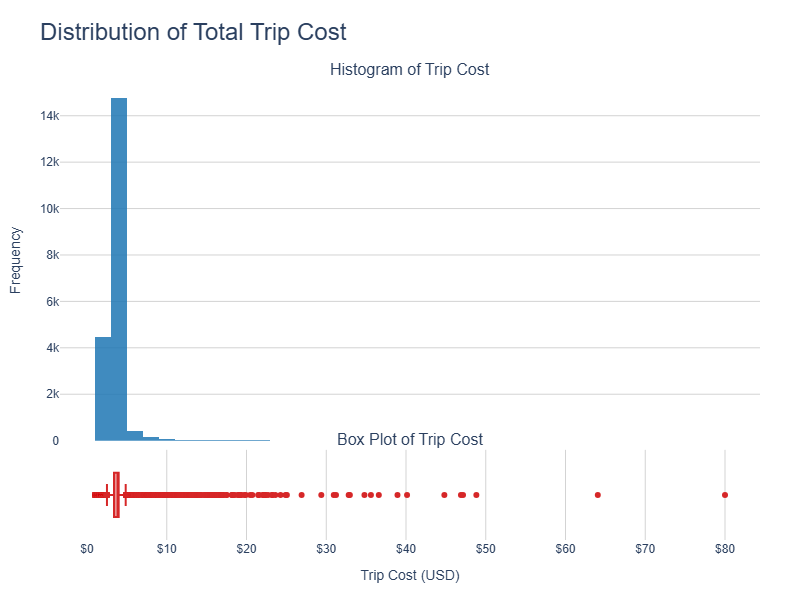

In [22]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from IPython.display import Image

# Create the subplot figure
fig = make_subplots(
    rows=2,
    cols=1,
    row_heights=[0.8, 0.2],
    shared_xaxes=True,
    vertical_spacing=0.02,
    subplot_titles=("Histogram of Trip Cost", "Box Plot of Trip Cost")
)

# Add histogram
fig.add_trace(
    go.Histogram(
        x=valid_costs,
        nbinsx=bin_count,
        name="Histogram",
        marker_color='#1f77b4',  # Professional blue
        opacity=0.85,
        hoverinfo='skip'
    ),
    row=1, col=1
)

# Add box plot
fig.add_trace(
    go.Box(
        x=valid_costs,
        name="Box Plot",
        marker_color='#d62728',  # Professional red
        boxpoints='outliers',
        orientation='h',
        hoverinfo='skip'
    ),
    row=2, col=1
)

# Update layout with professional styling
fig.update_layout(
    title_text="Distribution of Total Trip Cost",
    title_font=dict(size=24, family="Arial"),
    yaxis_title="Count",
    hovermode=False,
    dragmode=False,
    showlegend=False,
    height=600,
    width=800,
    font=dict(family="Arial", size=12),
    plot_bgcolor='white',
    margin=dict(t=80, b=60, l=60, r=40)
)

# Update axes
fig.update_xaxes(
    title_text="Trip Cost (USD)", 
    row=2, col=1,
    title_font=dict(size=14),
    tickprefix="$", 
    showgrid=True, 
    gridcolor='lightgray'
)
fig.update_yaxes(
    title_text="Frequency", 
    row=1, col=1,
    title_font=dict(size=14),
    showgrid=True, 
    gridcolor='lightgray'
)
fig.update_yaxes(
    title_text="", 
    row=2, col=1, 
    showticklabels=False
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=600, engine="kaleido")
display(Image(data=png_bytes))


### توزع تكلفة الرحلة مخطط الهيستو والبوكس
- نلاحظ أن معظم الرحلات تتراوح كلفتها بين 2 إلى 4 دولار
- وتتركز معظم القيم بين ال 3.4 إلى 4 دولار أيضا
- ونلاحظ وجود قيم متطرفة وهذا دليل على وجود الرحلات الطويلة مما سبب هذه الكلفة العالية مقارنة بالكلفة المنتشرة لمعظم رحلات الدراجات
- يؤكد المخطط أن الغالبية العظمى من رحلات الدراجات ذات تكلفة منخفضة جداً مما يؤكد أن معظم سمات الرحلات عم تكون قصيرة حوالي البضع دقائق
- نلاحظ أن القيم المتطرفة تمتد لنطاق واسع مما يدل على أن هناك تنوعاً كبيراً في التكاليف بعد تجاوز النطاق الأساسي

<div dir='rtl'>

### مخطط scatter لتكلفة الرحلة ضد المدة الزمنية

</div>

In [14]:
df_plot = sampled_df[['total_cost','duration_minutes']]

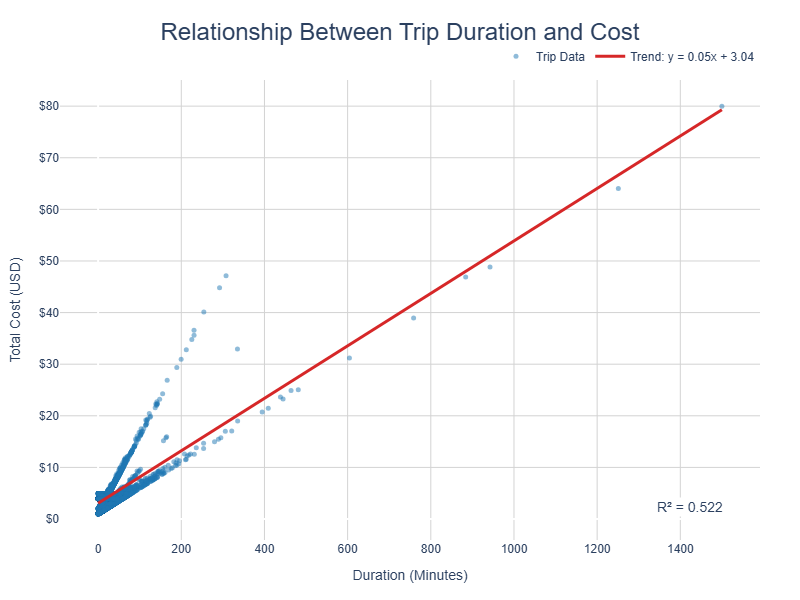

In [24]:
# Calculate the trend line (linear regression)
x_data = df_plot['duration_minutes']
y_data = df_plot['total_cost']

# Filter out inf values before fitting
finite_indices = np.isfinite(x_data) & np.isfinite(y_data)
x_finite = x_data[finite_indices]
y_finite = y_data[finite_indices]

m, c = np.polyfit(x_finite, y_finite, 1)  # m = slope, c = intercept
trend_line_x = np.array([x_finite.min(), x_finite.max()])
trend_line_y = m * trend_line_x + c

# Create the figure with professional styling
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter(
    x=df_plot['duration_minutes'],
    y=df_plot['total_cost'],
    mode='markers',
    name='Trip Data',
    marker=dict(
        color='#1f77b4',  # Professional blue
        size=5,
        opacity=0.5
    ),
    hoverinfo='skip'
))

# Add trend line
fig.add_trace(go.Scatter(
    x=trend_line_x,
    y=trend_line_y,
    mode='lines',
    name=f'Trend: y = {m:.2f}x + {c:.2f}',
    line=dict(
        color='#d62728',  # Professional red
        width=3
    ),
    hoverinfo='skip'
))

# Add professional styling
fig.update_layout(
    title=dict(
        text="Relationship Between Trip Duration and Cost",
        font=dict(size=24, family="Arial"),
        x=0.5,
        xanchor='center'
    ),
    xaxis_title="Duration (Minutes)",
    yaxis_title="Total Cost (USD)",
    hovermode=False,
    dragmode=False,
    showlegend=True,
    height=600,
    width=800,
    font=dict(family="Arial", size=12),
    plot_bgcolor='white',
    margin=dict(t=80, b=60, l=60, r=40),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Add professional axis styling
fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14)
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14),
    tickprefix="$"
)

# Add annotation with R-squared value
from sklearn.metrics import r2_score
y_pred = m * x_finite + c
r2 = r2_score(y_finite, y_pred)

fig.add_annotation(
    x=0.95, y=0.05,
    xref="paper", yref="paper",
    text=f"R² = {r2:.3f}",
    showarrow=False,
    font=dict(size=14),
    bgcolor="white"
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=600, engine="kaleido")
display(Image(data=png_bytes))



### Scatter conclude

- نلاحظ أن معظم النقاط تتركز بين ال 0-10 دولارات وهذا دليل أن جزء جيد من الرحلات هي قصيرة وكلفتها قليلة
- أما بالنسبة للاتجاه فنلاحظ أنه يزداد مع ازدياد مدة الرحل أي أنه يعني هناك تناسب بين مدة الرحل وزيادة الكلفة
- نلاحظ أنه يوجد نقاط لها نفس الإحداثيات على المحور الأفقي ولكن نجد قيمتها على محور الشاقولي مختلفة وهذا دليل أن تكلفة الرحل ليس فقط تعتمد على مدة الرحل وإنما هناك يوجد عوامل آخرى مثل نوع الدراجة المستخدمة وهل المستخدم هو عضو أم زائر فهذا هو تفسير وجود نقاط إسقاطها مختلف على محور ال Y


### تكلفة الرحلة ضد درجة الحرارة

In [25]:
df_weather = weather_df
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

In [26]:
sampled_df['ride_date'] = pd.to_datetime(sampled_df['started_at']).dt.date
print(len(sampled_df))

20000


In [27]:
df_merged = pd.merge(
    sampled_df.dropna(subset=['total_cost', 'rideable_type', 'ride_date']), # Drop NaNs before merge
    df_weather[['datetime', 'temp']],
    left_on='ride_date',
    right_on='datetime',
    how='inner'
)

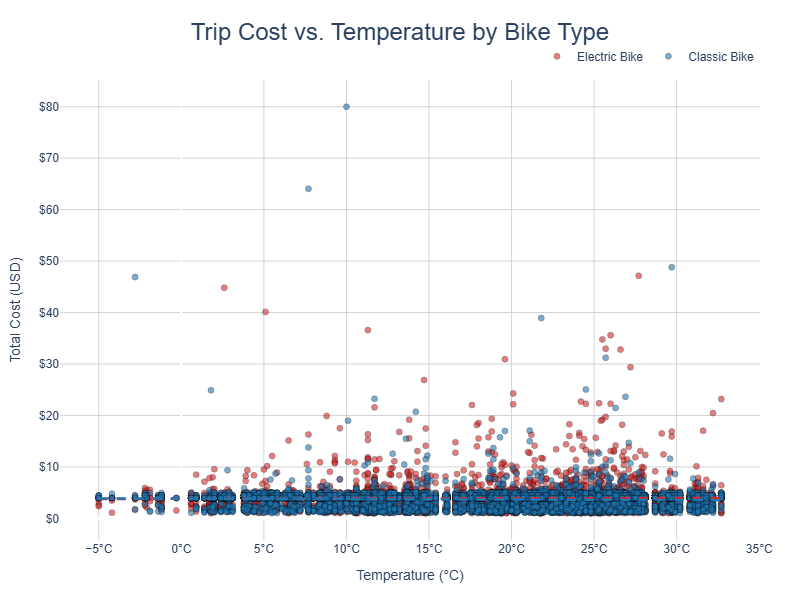

In [28]:
# Define bike types and colors
bike_types = df_merged['rideable_type'].unique()
type_colors = {
    'classic_bike': '#1f77b4',  # Professional blue
    'electric_bike': '#d62728'   # Professional red
}

# Create the figure with professional styling
fig = go.Figure()

# Add scatter plots for each bike type
for bike_type in bike_types:
    subset = df_merged[df_merged['rideable_type'] == bike_type]
    color = type_colors.get(bike_type, '#7f7f7f')  # Default to gray if not found
    
    fig.add_trace(go.Scatter(
        x=subset['temp'],
        y=subset['total_cost'],
        mode='markers',
        name=bike_type.replace('_', ' ').title(),
        marker=dict(
            color=color,
            size=6,
            opacity=0.6,
            line=dict(width=0.5, color='black')  # Add black outline for better visibility
        ),
        hoverinfo='skip'
    ))

# Add professional styling
fig.update_layout(
    title=dict(
        text="Trip Cost vs. Temperature by Bike Type",
        font=dict(size=24, family="Arial"),
        x=0.5,
        xanchor='center'
    ),
    xaxis_title="Temperature (°C)",
    yaxis_title="Total Cost (USD)",
    hovermode=False,
    dragmode=False,
    showlegend=True,
    height=600,
    width=800,
    font=dict(family="Arial", size=12),
    plot_bgcolor='white',
    margin=dict(t=80, b=60, l=60, r=40),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        title_font=dict(size=12)
    )
)

# Add professional axis styling
fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14),
    ticksuffix="°C"
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14),
    tickprefix="$"
)

# Add trend lines for each bike type
for bike_type in bike_types:
    subset = df_merged[df_merged['rideable_type'] == bike_type]
    color = type_colors.get(bike_type, '#7f7f7f')
    
    # Filter finite values
    finite_mask = np.isfinite(subset['temp']) & np.isfinite(subset['total_cost'])
    x_finite = subset['temp'][finite_mask]
    y_finite = subset['total_cost'][finite_mask]
    
    # Only add trend line if there's enough data
    if len(x_finite) > 1:
        m, c = np.polyfit(x_finite, y_finite, 1)
        trend_x = np.array([x_finite.min(), x_finite.max()])
        trend_y = m * trend_x + c
        
        fig.add_trace(go.Scatter(
            x=trend_x,
            y=trend_y,
            mode='lines',
            name=f'{bike_type.replace("_", " ").title()} Trend',
            line=dict(
                color=color,
                width=2.5,
                dash='dash'
            ),
            showlegend=False,
            hoverinfo='skip'
        ))

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=600, engine="kaleido")
display(Image(data=png_bytes))


### استنتاج كلفة مقارنة بدرجات الحرارة
 -  نلاحظ أن كثافة النقاط (سواء الزرقاء أو الحمراء) تقل بشكل ملحوظ عندما تنخفض درجة الحرارة إلى ما دون الصفر أو بضع درجات فوقه. هذا منطقي، فالطقس البارد غالبًا ما يثبط استخدام الدراجات.

 - نلاحظ انه عندما تكون درجات الحرارة منخفضة أي بين ال -5 إلى 5 درجة الحرارة فإن عدد الرحلات تقل بشكل ملحوظ حيث هذا دليل أن الطقس البارد غالباً ما يثبط استخدام الدرجات

- نرى أنه عندما يكون الجو معتدل يعني (10 -20) تزداد عدد الرحلات بشكل أكبر

- نلاحظ أنه هناك تكتل كبير للنقاط عند درجات الحرارة (20 - 28) وهذا قد يشير إلى أن المستخدمين يفضلون الطقس الدافئ إلى الحار قليلاً أو ربما الجو ضمن واشنطن بشكل عام هكذا متوسط درجات الحرارة

- نلاحظ هيمنة الدراجات الكهربائية بشكل واضح على الرحلات من الدراجت العادية

### السلسلة الزمنية للإيرادات اليومية والأسبوعية

In [29]:
daily_summary = pd.read_parquet('data/final_stage_results/daily_summary.parquet')

In [30]:
daily_summary['payment_day'] = pd.to_datetime(daily_summary['payment_day'])
revenue_by_day = daily_summary.set_index('payment_day').sort_index()
revenue_by_week = revenue_by_day['daily_total_revenue'].resample('W').sum().reset_index()
revenue_by_day['moving_avg_7d'] = revenue_by_day['daily_total_revenue'].rolling(window=7).mean()

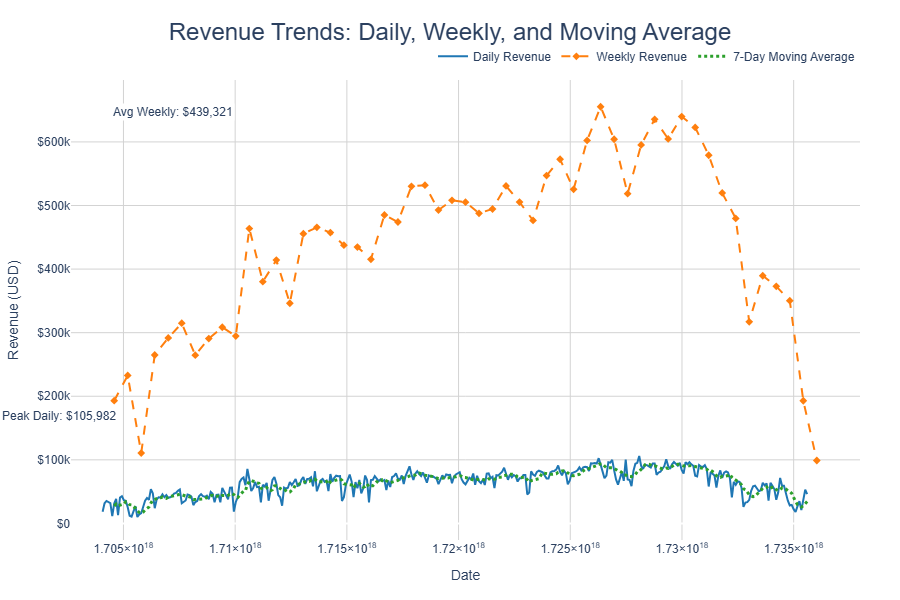

In [31]:
# Create the figure with professional styling
fig = go.Figure()

# ➊ Daily Revenue (blue line)
fig.add_trace(go.Scatter(
    x=revenue_by_day.index,
    y=revenue_by_day['daily_total_revenue'],
    mode='lines',
    name='Daily Revenue',
    line=dict(color='#1f77b4', width=2)  # Professional blue
))

# ➋ Weekly Revenue (orange dashed line with markers)
fig.add_trace(go.Scatter(
    x=revenue_by_week['payment_day'],
    y=revenue_by_week['daily_total_revenue'],
    mode='lines+markers',
    name='Weekly Revenue',
    line=dict(color='#ff7f0e', width=2, dash='dash'),  # Professional orange
    marker=dict(size=6, symbol='diamond')
))

# ➌ 7-Day Moving Average (green dotted line)
fig.add_trace(go.Scatter(
    x=revenue_by_day.index,
    y=revenue_by_day['moving_avg_7d'],
    mode='lines',
    name='7-Day Moving Average',
    line=dict(color='#2ca02c', width=3, dash='dot')  # Professional green
))

# Add professional styling
fig.update_layout(
    title=dict(
        text="Revenue Trends: Daily, Weekly, and Moving Average",
        font=dict(size=24, family="Arial"),
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Date',
    yaxis_title='Revenue (USD)',
    hovermode=False,
    dragmode=False,
    showlegend=True,
    height=600,
    width=900,
    font=dict(family="Arial", size=12),
    plot_bgcolor='white',
    margin=dict(t=80, b=60, l=60, r=40),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        bgcolor='rgba(255,255,255,0.8)'
    )
)

# Add professional axis styling
fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14),
    rangeslider=dict(visible=False)
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='lightgray',
    title_font=dict(size=14),
    tickprefix="$"
)

# Add annotations for key insights
max_daily = revenue_by_day['daily_total_revenue'].max()
max_daily_date = revenue_by_day['daily_total_revenue'].idxmax()
fig.add_annotation(
    x=max_daily_date,
    y=max_daily,
    text=f"Peak Daily: ${max_daily:,.0f}",
    showarrow=True,
    arrowhead=2,
    ax=-50,
    ay=-40,
    bgcolor="white"
)

avg_weekly = revenue_by_week['daily_total_revenue'].mean()
fig.add_annotation(
    x=0.05,
    y=0.95,
    xref="paper",
    yref="paper",
    text=f"Avg Weekly: ${avg_weekly:,.0f}",
    showarrow=False,
    bgcolor="white"
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=900, height=600, engine="kaleido")
display(Image(data=png_bytes))

# # Optional: Save high-resolution version
# fig.write_image("revenue_trends.png", scale=2)


### تحليل الإيرادات اليومية والشهرية
- يمكننا أن نرى انه ببداية العام إلى تقريباً نصف الشهر الثاني أن الأرباح تكون أقل ما يكون مقارنة بغيرها من بقية العام وهذا يشير إلى أن الأشهر الشتوية الباردة تشهد أدنى مستويات الإيرادات وهذا يتوافق مع ما قلناه مسبقا على تأثير درجات الحرارة المنخفضة على الرحلات بالدراجات

- تزداد الإيرادات بشكل ملحوظ اعتباراً من الربيع شهر آذار ونيسان وتصل إلى ذروتها في أشهر الصيف والخربف حوالي أشهر تموز وإيلول إلى تشرين الأول مما يؤكد أن فصلي الصيف والخريف هما مواسم الذروة لإيرادات الرحلات ضمن الدراجات

- بالنسبة للإيرادات اليومية يصعب الاستخلاص منها وذلك بسبب أنها شديدة التقلب وربما يعود سبب هذه الضوضاء بسبب التقلبات اليومية مثل أيام الأسبوع مقابل عطلات نهاية الأسبوع والطقس المتقلب

- تتراجع الإيرادات بشكل حاد في نهاية العام شهري تشرين الثاني وكانون الأول مما يؤكد النمط الموسمي القوي حيث تتراجع الإيرادات مع عودة الطقس البارد في نهاية العام وبداية العام التالي


### الإيرادات الشهرية

In [32]:
daily_summary['month'] = daily_summary['payment_day'].dt.to_period('M').dt.to_timestamp()

In [33]:
monthly_avg_revenue = (
    daily_summary
    .groupby('month')['daily_total_revenue']
    .mean()
    .reset_index()
)

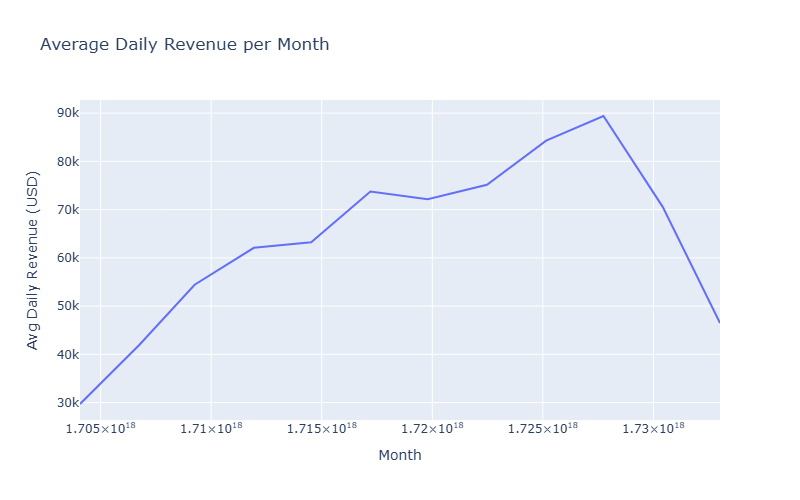

In [34]:

# Your original code unchanged
fig = px.line(
    monthly_avg_revenue,
    x='month',
    y='daily_total_revenue',
    title='Average Daily Revenue per Month',
    labels={
        'month': 'Month',
        'daily_total_revenue': 'Avg Daily Revenue (USD)'
    }
)

# Your original layout settings unchanged
fig.update_layout(
    hovermode=False,
    dragmode=False,
    height=500
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))

# Optional: Save the image if needed
# fig.write_image("monthly_revenue.png", scale=2)

### تحليل الإيرادات الشهرية
- كما قلنا سابقا أنه في بداية العام تكون الأرباح أقل ما يكون ومن ثم تزداد مع بدء انتهاء أشهر الشتاء
- ثم نلاحظ بشكل عام ازدياد الإيرادات ضمن فصل الربيع بشكل بسيط
- ومن ثم تبدأ ارتفاع الإيرادات وذلك بسبب ذروة الموسم وهو فصلي الصيف والخريف لتصل إلى قمتها في شهر 10 ومن ثم تبدأ الإيرادات بالانخفاض مع عودة انخفاض درجة الحرارة وعودة فصل الشتاء

## D

### D1

* we need to use here the `Residential_and_Visitor_Parking_Zones.geojson` 

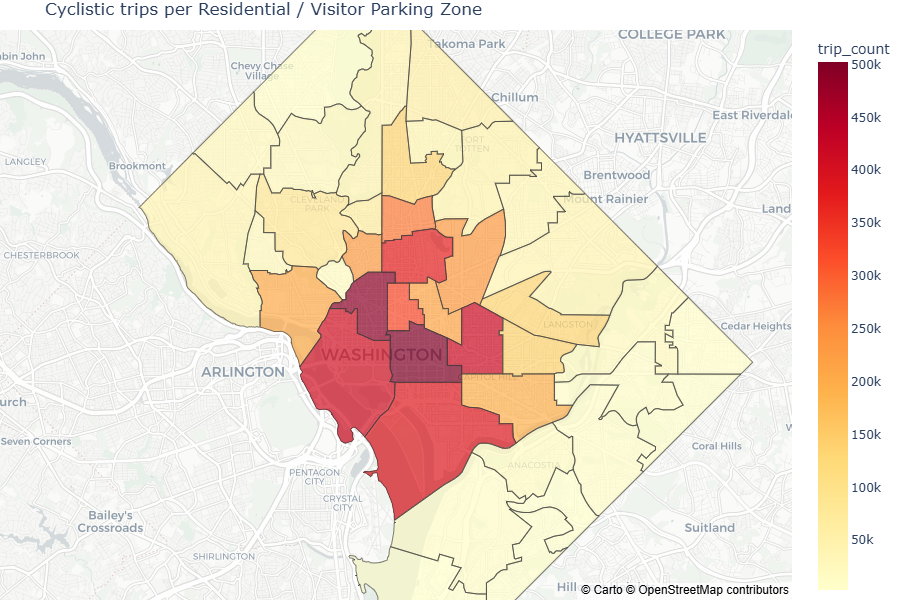

Trips outside any zone: 820,430


In [35]:
PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"       
ZONE_GJ       = "data/raw/Residential_and_Visitor_Parking_Zones.geojson"


# 2. Load trips → GeoDataFrame (read only the needed cols)
trips = pd.read_parquet(
    PARQUET_PATH,
    columns=["ride_id", "start_point"]  # minimise memory
)
trips["geometry"] = trips["start_point"].apply(wkt.loads)
trips_gdf = gpd.GeoDataFrame(trips, geometry="geometry", crs="EPSG:4326")

# 3. Load residential / visitor polygons
zones_gdf = (
    gpd.read_file(ZONE_GJ)[["GIS_ID", "NAME", "geometry"]]
      .to_crs("EPSG:4326")
)

# 4. Spatial join  (point within polygon)
joined = gpd.sjoin(trips_gdf, zones_gdf, how="left", predicate="within")
joined["zone_id"] = joined["GIS_ID"].fillna("Outside")

# 5. Aggregate trip counts
counts = (
    joined["zone_id"]
          .value_counts(dropna=False)
          .rename_axis("zone_id")
          .reset_index(name="trip_count")
)

# 6. Merge counts back to polygons (exclude “Outside” for map layer)
zones_counts = zones_gdf.merge(
    counts.query("zone_id != 'Outside'"), left_on="GIS_ID", right_on="zone_id"
)

# 7. Build Plotly choropleth  (static renderer='png')
fig = px.choropleth_mapbox(
    zones_counts,
    geojson=zones_counts.__geo_interface__,
    locations="GIS_ID",
    color="trip_count",
    featureidkey="properties.GIS_ID",   # <= tell Plotly where the key is
    hover_name="NAME",
    mapbox_style="carto-positron",
    opacity=0.7,
    zoom=11,
    center=dict(
        lat=trips_gdf.geometry.y.mean(),
        lon=trips_gdf.geometry.x.mean()
    ),
    color_continuous_scale="YlOrRd",
)
fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
    title_text="Cyclistic trips per Residential / Visitor Parking Zone"
)

# 8. Show as static PNG (no interactivity, no external file)
png_bytes = fig.to_image(format="png", width=900, height=600, engine="kaleido")
display(Image(data=png_bytes))

# 9. Report trips that fell outside all zones
outside_cnt = int(counts.loc[counts["zone_id"] == "Outside", "trip_count"])
print(f"Trips outside any zone: {outside_cnt:,}")


**My Note on the HEATMAP:**
* from the heatmap we see the most of trips are in the center of the residential zones 
* around the 25% of whole Trips are outside of the residential zones 
* so we need focus on the residential zones more.  

### D2

**Bar chart of trip_demand_level**

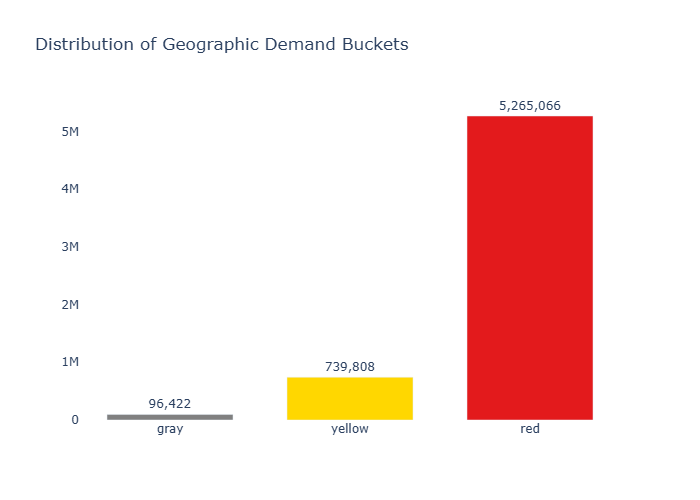

In [36]:


PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"     # ← adjust if needed

# Load just the demand column
df = pd.read_parquet(PARQUET_PATH, columns=["trip_demand_level"])

# counts
counts = (
    df["trip_demand_level"]
      .value_counts()
      .rename_axis("demand_level")
      .reset_index(name="trip_count")
      .sort_values("demand_level")  
)

# Bar chart 
fig = px.bar(
    counts,
    x="demand_level",
    y="trip_count",
    text="trip_count",
    color="demand_level",
    category_orders={"demand_level": ["gray", "yellow", "red"]},
    color_discrete_map={
        "gray":   "#808080",   
        "yellow": "#FFD700",   
        "red":    "#E31A1C"    
    },
    labels=dict(demand_level="Demand bucket", trip_count="Number of trips"),
    title="Distribution of Geographic Demand Buckets"
)

fig.update_traces(texttemplate="%{text:,}", textposition="outside")
fig.update_layout(
    yaxis_title=None, xaxis_title=None,
    uniformtext_minsize=8, uniformtext_mode="hide",
    bargap=0.3, plot_bgcolor="white", showlegend=False
)

# Render as static PNG
png_bytes = fig.to_image(format="png", width=700, height=500, engine="kaleido")
display(Image(data=png_bytes))


* as we said before the les number of stations id the red stations around `10%` of the stations but here is the most frequency one  

### D3

**Histogram: CBD, Metro, Bus distances**

In [15]:

cols = ["distance_to_cbd", "dist_metro_start", "dist_bus_start"]
df = pd.read_parquet("data/final_stage_results/final_trips_ready.parquet", columns=cols)

summary = df.describe(percentiles=[.5, .75, .9, .95, .99])[cols].T
display(summary[["min", "50%", "75%", "95%", "max"]])

min          50%          75%          95%  \
distance_to_cbd   5.018761  1392.943715  2922.069599  7610.866050   
dist_metro_start  0.091389    74.206596   155.954971   336.783997   
dist_bus_start    0.033565   534.270416   996.477051  4994.637695   

                           max  
distance_to_cbd   1.506611e+07  
dist_metro_start  1.426570e+07  
dist_bus_start    1.428599e+07

In [ ]:
# import pandas as pd, numpy as np, plotly.express as px
# from IPython.display import Image, display

PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"
cols = ["distance_to_cbd", "dist_metro_start", "dist_bus_start"]

# 1) Load & clip to the 99th percentile of the combined data
df = pd.read_parquet(PARQUET_PATH, columns=cols).dropna()
clip = np.percentile(df.values, 99)        # ≈ 8 km from your table
df = df.clip(upper=clip)

# 2) Reshape to long form
long_df = (
    df.rename(columns={
        "distance_to_cbd":   "CBD",
        "dist_metro_start":  "Metro",
        "dist_bus_start":    "Bus"
    })
    .melt(var_name="Category", value_name="Distance_m")
)

# Fixed 100-m bins
bin_edges = np.arange(0, clip + 100, 100)

fig = px.histogram(
    long_df,
    x="Distance_m",
    color="Category",
    barmode="overlay",
    opacity=0.55,
    histfunc="count",
    nbins=len(bin_edges) - 1,
    category_orders={"Category": ["CBD", "Metro", "Bus"]},
    labels=dict(Distance_m="Distance (m)", Category=""),
    title=f"Distance distribution by facility type (0 – {clip/1000:.1f} km)"
)

fig.update_traces(marker_line_width=0.2, marker_line_color="#555")
fig.update_layout(
    xaxis_range=[0, clip],
    yaxis_title="Trip count",
    bargap=0.05,
    plot_bgcolor="white",
    legend=dict(x=0.8, y=0.95)
)
print('Box plot created')
fig.show(validate = False)

# png = fig.to_image(format="png", width=850, height=500, engine="kaleido")
# display(Image(data=png))


Box plot created


* I choose the 100 m bins: That gives ~80 bins across 0–8 km: narrow enough to show shape, wide enough to be visible.
* because around 95% of data is far around 8_000 m 
* and Here we use 99% in draw Keeps virtually all genuine trips while dropping GPS errors that stretch the axis.

### D4

 **Bar chart: trips entirely INSIDE CBD vs. OUTSIDE/CROSSING**

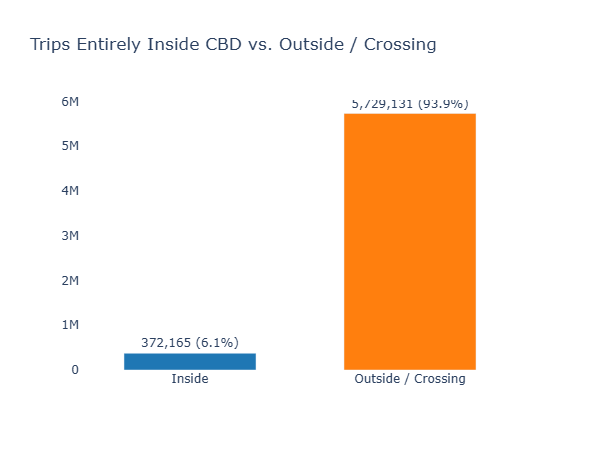

In [18]:
PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"


df = pd.read_parquet(
    PARQUET_PATH,
    columns=["start_in_cbd", "end_in_cbd"]
).dropna()

# Derive trip scope
df["trip_scope"] = np.select(
    [df["start_in_cbd"] & df["end_in_cbd"]],
    ["Inside"],
    default="Outside / Crossing"
)

# Counts + percentages
counts = (
    df["trip_scope"]
      .value_counts()
      .loc[["Inside", "Outside / Crossing"]]          # fixed order
      .rename_axis("scope")
      .reset_index(name="trip_count")
)
total = counts["trip_count"].sum()
counts["pct"] = (counts["trip_count"] / total * 100).round(1)

# Plotly bar chart
fig = px.bar(
    counts,
    x="scope",
    y="trip_count",
    color="scope",
    text=counts.apply(lambda r: f"{r.trip_count:,}\n({r.pct}%)", axis=1),
    color_discrete_map={
        "Inside": "#1f77b4",           # blue
        "Outside / Crossing": "#ff7f0e"   # orange
    },
    category_orders={"scope": ["Inside", "Outside / Crossing"]},
    labels=dict(scope="", trip_count="Number of trips"),
    title="Trips Entirely Inside CBD vs. Outside / Crossing"
)

fig.update_traces(textposition="outside")
fig.update_layout(
    showlegend=False,
    yaxis_title=None,
    uniformtext_minsize=8,
    bargap=0.4,
    plot_bgcolor="white"
)

# static PNG
png_bytes = fig.to_image(format="png", width=600, height=450, engine="kaleido")
display(Image(data=png_bytes))


* there is around `6.1%` of the Trips is start and end in the CBD the most of the trips out of CBD or just Crossing in it.
* we need to focus on residential zones more. 

### D5

**Bar chart: CBD-touching trips by bike type & membership**

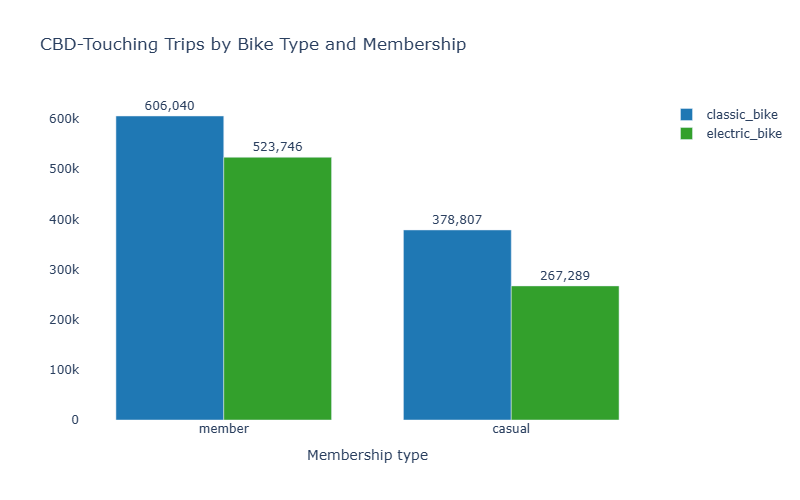

In [19]:
PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"


#  Load only the relevant columns
cols = ["passed_through_cbd", "member_casual", "rideable_type"]
df = pd.read_parquet(PARQUET_PATH, columns=cols).dropna()

# Keep trips that passed through the CBD
df_cbd = df[df["passed_through_cbd"] == 1]

#  Aggregate trip counts
counts = (
    df_cbd.groupby(["member_casual", "rideable_type"])
          .size()
          .rename("trip_count")
          .reset_index()
          .sort_values(["member_casual", "rideable_type"])
)

# Plotly grouped bar chart
fig = px.bar(
    counts,
    x="member_casual",
    y="trip_count",
    color="rideable_type",
    text="trip_count",
    barmode="group",
    category_orders={
        "member_casual": ["member", "casual"],
        "rideable_type": ["classic_bike", "electric_bike", "docked_bike"]
    },
    color_discrete_map={
        "classic_bike":  "#1f78b4",  
        "electric_bike": "#33a02c",  
        "docked_bike":   "#e31a1c"   
    },
    labels=dict(
        member_casual="Membership type",
        trip_count="Number of CBD-touching trips",
        rideable_type="Bike type"
    ),
    title="CBD-Touching Trips by Bike Type and Membership"
)

# Tidy up the layout
fig.update_traces(texttemplate="%{text:,}", textposition="outside")
fig.update_layout(
    yaxis_title=None,
    bargap=0.25,
    uniformtext_minsize=8,
    plot_bgcolor="white",
    legend_title=""
)

# 6. Render as static PNG to keep notebook non-interactive
png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))


* we see the members are crossing the CBD more. 

### D6

**Chi-square test: CBD-proximity bucket vs membership**

In [20]:
cols = ["near_cbd", "member_casual"]
tmp = pd.read_parquet(PARQUET_PATH, columns=cols)

print("Unique near_cbd values:", tmp["near_cbd"].dropna().unique()[:10])
print("Unique member_casual values:", tmp["member_casual"].unique())
print("Counts per near_cbd bucket:")
display(tmp["near_cbd"].value_counts(dropna=False))


Unique near_cbd values: [1. 0.]
Unique member_casual values: ['member' 'casual']
Counts per near_cbd bucket:


near_cbd
1.0    3141184
0.0    1858649
NaN    1101463
Name: count, dtype: int64

In [21]:


PARQUET_PATH = "data/final_stage_results/final_trips_ready.parquet"

# near_cbd flag (1/0) + membership
df = pd.read_parquet(PARQUET_PATH, columns=["near_cbd", "member_casual"]).dropna()

# numeric flag to string categories
df["near_cbd_bin"] = df["near_cbd"].map({1.0: "close", 0.0: "far"})

#  Contingency table
table = pd.crosstab(df["near_cbd_bin"], df["member_casual"])

print("Observed counts:")
display(table)

# Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(table)

# 5. Cramer’s V (effect size)
N = table.values.sum()
cramers_v = np.sqrt(chi2 / (N * (min(table.shape) - 1)))

# 6. Output neatly
print("\nExpected counts under H₀ (independence):")
display(pd.DataFrame(expected, index=table.index, columns=table.columns).round(1))

print(f"\nChi-square results:")
print(f"  χ² = {chi2:,.2f},  df = {dof},  p = {p:.4g}")
print(f"Cramer’s V = {cramers_v:.3f}", end=" ")
if   cramers_v < 0.1:  print("(negligible)")
elif cramers_v < 0.3:  print("(small)")
elif cramers_v < 0.5:  print("(moderate)")
else:                  print("(large)")


Observed counts:


member_casual   casual   member
near_cbd_bin                   
close          1028198  2112986
far             609603  1249046


Expected counts under H₀ (independence):


member_casual     casual     member
near_cbd_bin                       
close          1028961.2  2112222.8
far             608839.8  1249809.2


Chi-square results:
  χ² = 2.26,  df = 1,  p = 0.1326
Cramer’s V = 0.001 (negligible)


* Cyclist riders who start `“close”` to the CBD and those who start `“far”` have essentially the same member-vs-casual split.
* Membership status is independent of CBD proximity.

## E

### E1

**Daily averages line chart from raw weather CSV**

In [26]:
weather_df.head()

name    datetime  tempmax  tempmin  temp  humidity  windspeed  \
0  Washington,DC,USA  2024-01-01      6.1      3.8   4.9      74.7       21.9   
1  Washington,DC,USA  2024-01-02      7.7      2.0   4.7      57.3       29.2   
2  Washington,DC,USA  2024-01-03      8.8      0.9   4.4      59.5       14.2   
3  Washington,DC,USA  2024-01-04      8.1      0.7   4.7      55.2       35.0   
4  Washington,DC,USA  2024-01-05      4.4     -2.4   0.9      55.0       21.3   

   windspeedmax  windspeedmean  windspeedmin  cloudcover              sunrise  \
0          21.9           11.9           0.0        90.3  2024-01-01T07:26:50   
1          29.2           18.6           6.7        47.5  2024-01-02T07:26:58   
2          14.2            8.9           0.7        68.7  2024-01-03T07:27:04   
3          35.0           17.0           0.0        68.5  2024-01-04T07:27:07   
4          21.3           10.6           5.1        44.5  2024-01-05T07:27:09   

                sunset  moonphase        conditions  \
0  2024-01-01T16:56:30       0.68    Rain, Overcast   
1  2024-01-02T16:57:20       0.72  Partially cloudy   
2  2024-01-03T16:58:10       0.75  Partially cloudy   
3  2024-01-04T16:59:02       0.78  Partially cloudy   
4  2024-01-05T16:59:55       0.81  Partially cloudy   

                                         description               icon  
0  Cloudy skies throughout the day with early mor...               rain  
1                  Partly cloudy throughout the day.  partly-cloudy-day  
2                  Partly cloudy throughout the day.  partly-cloudy-day  
3                  Partly cloudy throughout the day.  partly-cloudy-day  
4                  Partly cloudy throughout the day.  partly-cloudy-day

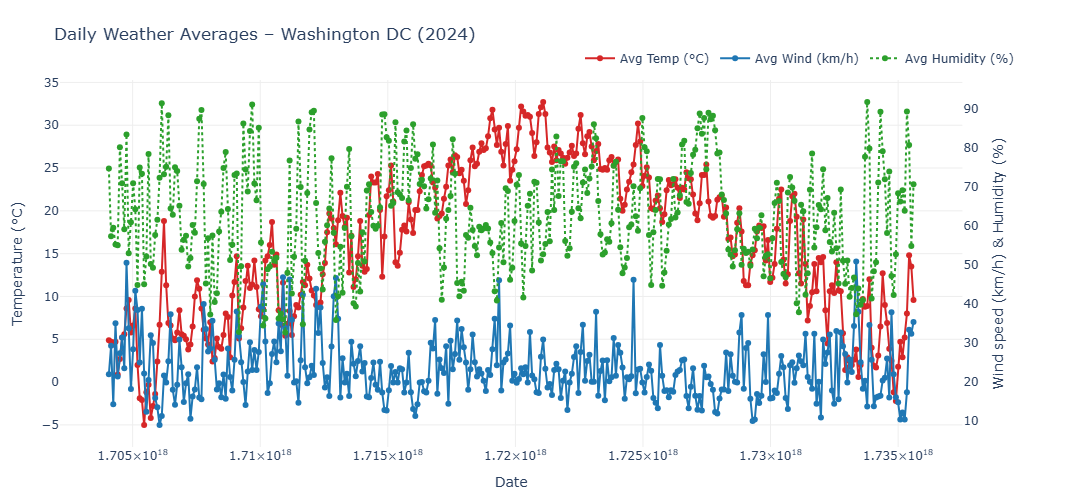

In [27]:
# =============================================================
# Section 2-e-1 (revised) – Daily averages line chart from raw weather CSV
# =============================================================
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from IPython.display import Image, display

# ---------- 1. path + column names (EDIT if necessary) -------
WEATHER_CSV = "data/raw/Washington,DC,USA 2024-01-01 to 2024-12-31.csv"

COL_DATE     = "datetime"          # sometimes "datetime" or "time"
COL_TEMP     = "temp"          # or "tempavg", "temperature"
COL_WIND     = "windspeed"     # or "wind_mean_kph"
COL_HUMIDITY = "humidity"      # or "humidity_avg"
# -------------------------------------------------------------

# 2. Load & tidy
weather = (
    pd.read_csv(WEATHER_CSV, parse_dates=[COL_DATE])
      [[COL_DATE, COL_TEMP, COL_WIND, COL_HUMIDITY]]
      .rename(columns={
          COL_DATE: "date",
          COL_TEMP: "avg_temp",
          COL_WIND: "avg_wind_speed",
          COL_HUMIDITY: "avg_humidity"
      })
)


# 3. Ensure one row per day (safety); otherwise take mean
daily = (weather
         .groupby("date", as_index=False)
         .mean()
         .sort_values("date"))

# 4. Build multi-axis line figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=daily["date"], y=daily["avg_temp"],
               mode="lines+markers", name="Avg Temp (°C)",
               line=dict(color="#d62728")),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x=daily["date"], y=daily["avg_wind_speed"],
               mode="lines+markers", name="Avg Wind (km/h)",
               line=dict(color="#1f77b4")),
    secondary_y=True)

fig.add_trace(
    go.Scatter(x=daily["date"], y=daily["avg_humidity"],
               mode="lines+markers", name="Avg Humidity (%)",
               line=dict(color="#2ca02c", dash="dot")),
    secondary_y=True)

fig.update_layout(
    title="Daily Weather Averages – Washington DC (2024)",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    yaxis2_title="Wind speed (km/h) & Humidity (%)",
    legend=dict(orientation="h", yanchor="bottom", y=1.02,
                xanchor="right", x=1),
    plot_bgcolor="white",
    margin=dict(l=60, r=60, t=80, b=40)
)

fig.update_xaxes(showgrid=True, gridcolor="#eeeeee")
fig.update_yaxes(showgrid=True, gridcolor="#eeeeee", secondary_y=False)

fig.update_yaxes(showgrid=False, secondary_y=True)

# 5. Static PNG render (non-interactive)
png = fig.to_image(format="png", width=1080, height=500, engine="kaleido")
display(Image(data=png))


* we see the wind an humidity are still at same range but the Temp has peak in the middle of year

### E2

**Box-plot of daily revenue by weather condition**

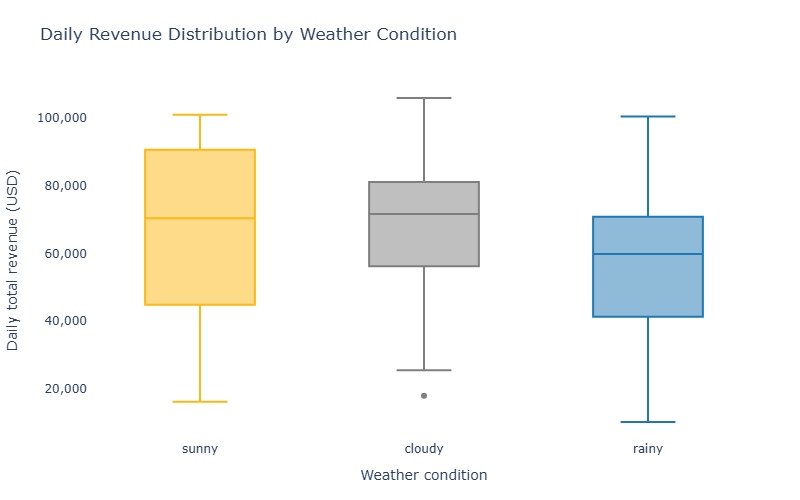

In [29]:

DAILY_SUMMARY = "data/final_stage_results/daily_summary.parquet"
COL_DATE          = "payment_day"         
COL_REVENUE       = "daily_total_revenue"
COL_WEATHER_BIN   = "weather_bin"         



daily = pd.read_parquet(DAILY_SUMMARY,
                        columns=[COL_DATE, COL_REVENUE, COL_WEATHER_BIN])


#  here i just make max value to make the plot correct 
# upper = 600_000 

daily[COL_WEATHER_BIN] = pd.Categorical(
    daily[COL_WEATHER_BIN],
    categories=["sunny", "cloudy", "rainy"], ordered=True
)

# daily = daily[daily[COL_REVENUE] <= upper]

fig = px.box(
    daily,
    x=COL_WEATHER_BIN,
    y=COL_REVENUE,
    color=COL_WEATHER_BIN,
    category_orders={COL_WEATHER_BIN: ["sunny", "cloudy", "rainy"]},
    color_discrete_map={"sunny": "#FDB813", 
                        "cloudy": "#7F7F7F", 
                        "rainy": "#1F77B4"},
    labels={COL_WEATHER_BIN: "Weather condition",
            COL_REVENUE:    "Daily total revenue (USD)"},
    title="Daily Revenue Distribution by Weather Condition"
)

fig.update_layout(
    showlegend=False,
    plot_bgcolor="white",
    yaxis_tickformat=",",  
    margin=dict(l=80, r=40, t=80, b=60)
)


png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))


* we see higher income in the sunny days and the sunny days have the wider box that show how many trips made in that weather.
* and the cloudy days are in the mid with smaller box.
* rainy days have lowest income. 

Cyclist earns about 35 % more on a typical sunny day than on a rainy one, and revenues are more volatile when it’s sunny. Cloudy weather yields moderate but steadier earnings.

### E3

Correlation between temperature and revenue: 0.6826
Correlation between humidity and revenue: -0.1573


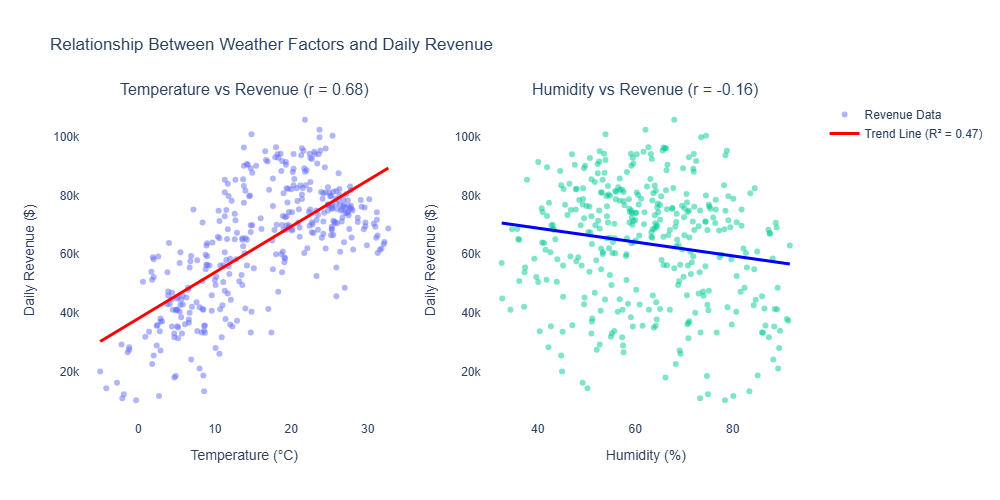


Statistical Report:
Temperature - Correlation: 0.6826
Temperature - p-value: 0.0000
Temperature - R²: 0.4660
Humidity - Correlation: -0.1573
Humidity - p-value: 0.0025
Humidity - R²: 0.0247


In [30]:
# 1. Read daily revenue data
DAILY_SUMMARY = "data/final_stage_results/daily_summary.parquet"
daily_revenue = pd.read_parquet(
    DAILY_SUMMARY,
    columns=["payment_day", "daily_total_revenue"]
)

daily_revenue['payment_day'] = pd.to_datetime(daily_revenue['payment_day'], errors='coerce')

# 2. Read weather data
WEATHER_FILE = "data/raw/Washington,DC,USA 2024-01-01 to 2024-12-31.csv"
weather = pd.read_csv(WEATHER_FILE, parse_dates=["datetime"])

# 3. Process weather data
# - Extract only the date (without time)
weather["date"] = weather["datetime"].dt.date

# - Select required columns
weather = weather[["date", "temp", "humidity"]]

# 4. Merge revenue data with weather data
# - Convert revenue date to same format as weather date
daily_revenue["date"] = daily_revenue["payment_day"].dt.date

# - Merge
merged = pd.merge(
    daily_revenue,
    weather,
    on="date",
    how="left"
)

# 5. Calculate correlation coefficients
corr_temp = merged["daily_total_revenue"].corr(merged["temp"])
corr_humid = merged["daily_total_revenue"].corr(merged["humidity"])

print(f"Correlation between temperature and revenue: {corr_temp:.4f}")
print(f"Correlation between humidity and revenue: {corr_humid:.4f}")

# 6. Linear regression analysis
def linear_regression_analysis(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.dropna(), y.dropna())
    return slope, intercept, r_value**2, p_value

# Temperature
slope_temp, intercept_temp, r2_temp, p_temp = linear_regression_analysis(
    merged["temp"],
    merged["daily_total_revenue"]
)

# Humidity
slope_humid, intercept_humid, r2_humid, p_humid = linear_regression_analysis(
    merged["humidity"],
    merged["daily_total_revenue"]
)

# 7. Create plots
fig = make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=(
        f"Temperature vs Revenue (r = {corr_temp:.2f})",
        f"Humidity vs Revenue (r = {corr_humid:.2f})"
    )
)

# Temperature scatter plot
fig.add_trace(
    go.Scatter(
        x=merged["temp"],
        y=merged["daily_total_revenue"],
        mode='markers',
        name='Revenue Data',
        marker=dict(opacity=0.5)
    ),
    row=1, col=1
)

# Temperature regression line
x_range = np.linspace(merged["temp"].min(), merged["temp"].max(), 100)
y_pred_temp = slope_temp * x_range + intercept_temp
fig.add_trace(
    go.Scatter(
        x=x_range, 
        y=y_pred_temp,
        mode='lines',
        name=f'Trend Line (R² = {r2_temp:.2f})',
        line=dict(color='red', width=3)
    ),
    row=1, col=1
)

# Humidity scatter plot
fig.add_trace(
    go.Scatter(
        x=merged["humidity"],
        y=merged["daily_total_revenue"],
        mode='markers',
        name='Revenue Data',
        marker=dict(opacity=0.5),
        showlegend=False
    ),
    row=1, col=2
)

# Humidity regression line
x_range_humid = np.linspace(merged["humidity"].min(), merged["humidity"].max(), 100)
y_pred_humid = slope_humid * x_range_humid + intercept_humid
fig.add_trace(
    go.Scatter(
        x=x_range_humid, 
        y=y_pred_humid,
        mode='lines',
        name=f'Trend Line (R² = {r2_humid:.2f})',
        line=dict(color='blue', width=3),
        showlegend=False
    ),
    row=1, col=2
)

# 8. Update layout
fig.update_layout(
    title_text="Relationship Between Weather Factors and Daily Revenue",
    height=500,
    width=1000,
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=12)
)

fig.update_xaxes(title_text="Temperature (°C)", row=1, col=1)
fig.update_yaxes(title_text="Daily Revenue ($)", row=1, col=1)
fig.update_xaxes(title_text="Humidity (%)", row=1, col=2)
fig.update_yaxes(title_text="Daily Revenue ($)", row=1, col=2)

# 9. Display plot as a static image
png_bytes = fig.to_image(format="png", width=1000, height=500, engine="kaleido")
display(Image(data=png_bytes))

# 10. Statistical report
print("\nStatistical Report:")
print(f"Temperature - Correlation: {corr_temp:.4f}")
print(f"Temperature - p-value: {p_temp:.4f}")
print(f"Temperature - R²: {r2_temp:.4f}")
print(f"Humidity - Correlation: {corr_humid:.4f}")
print(f"Humidity - p-value: {p_humid:.4f}")
print(f"Humidity - R²: {r2_humid:.4f}")



*  Strong positive correlation between temperature and revenue: warmer days lead to higher revenue
*  Moderate negative correlation between humidity and revenue

### E4

Number of rows after merge: 6101296
Unique weather categories: ['rainy' 'sunny' 'cloudy']
Unique bike types: ['classic' 'electric']

Contingency Table:
bike_type         classic  electric
weather_category                   
sunny             1337347   1698306
cloudy             457912    560251
rainy              906082   1141398

Chi-Square Test Results:
Chi-Square value: 261.9359
p-value: 0.0000
Degrees of freedom: 2

Expected values under independence:
bike_type              classic      electric
weather_category                            
sunny             1.344031e+06  1.691622e+06
cloudy            4.507904e+05  5.673726e+05
rainy             9.065192e+05  1.140961e+06

Cramér's V: 0.0066


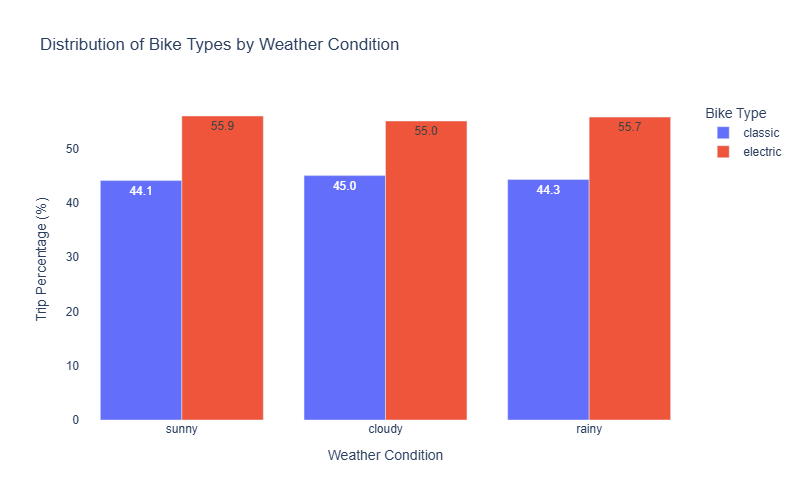

In [31]:
# 1. Read daily trip data
TRIPS_FILE = "data/final_stage_results/final_trips_ready.parquet"
trips = pd.read_parquet(
    TRIPS_FILE,
    columns=['started_at', 'rideable_type']
)

# 2. Read daily weather data
WEATHER_FILE = "data/raw/Washington,DC,USA 2024-01-01 to 2024-12-31.csv"
weather = pd.read_csv(WEATHER_FILE, parse_dates=["datetime"])

# 3. Process trip data
# - Convert timestamp to date only
trips['date'] = pd.to_datetime(trips['started_at']).dt.date

# - Map bike type to Arabic
trips['bike_type'] = trips['rideable_type'].map({
    'classic_bike': 'classic',
    'electric_bike': 'electric'
})

# 4. Process weather data
# - Extract date only
weather["date"] = weather["datetime"].dt.date

# - Classify weather condition based on specific rules
def classify_weather(row):
    # First check if required columns exist
    if 'conditions' in row and 'cloudcover' in row:
        if 'rain' in row['conditions'].lower():
            return 'rainy'  # Rainy
        elif row['cloudcover'] > 70:
            return 'cloudy'  # Cloudy
    return 'sunny'  # Sunny

weather['weather_category'] = weather.apply(classify_weather, axis=1)

# 5. Merge trip data with weather data
merged = pd.merge(
    trips,
    weather[['date', 'weather_category']],
    on='date',
    how='left'
)

# 6. Check merged data
print("Number of rows after merge:", len(merged))
print("Unique weather categories:", merged['weather_category'].unique())
print("Unique bike types:", merged['bike_type'].unique())

# 7. Create contingency table
contingency_table = pd.crosstab(
    merged['weather_category'],
    merged['bike_type']
)

# Reorder rows logically
if not contingency_table.empty:
    contingency_table = contingency_table.reindex(
        index=['sunny', 'cloudy', 'rainy'],
        columns=['classic', 'electric']
    )

    print("\nContingency Table:")
    print(contingency_table)

    # 8. Perform Chi-Square test of independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("\nChi-Square Test Results:")
    print(f"Chi-Square value: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected values under independence:")
    print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

    # 9. Calculate Cramér's V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))

    print(f"\nCramér's V: {cramers_v:.4f}")

    # 11. Plot bar chart
    # Calculate percentages
    percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Create plot
    fig = px.bar(
        percentages.reset_index(),
        x='weather_category',
        y=['classic', 'electric'],
        barmode='group',
        labels={
            'weather_category': 'Weather Condition',
            'value': 'Trip Percentage (%)',
            'variable': 'Bike Type'
        },
        title='Distribution of Bike Types by Weather Condition',
        text_auto='.1f'
    )

    # Improve layout
    fig.update_layout(
        plot_bgcolor='white',
        font=dict(family="Arial, sans-serif", size=12),
        legend_title_text='Bike Type',
        xaxis_title='Weather Condition',
        yaxis_title='Trip Percentage (%)'
    )

    # Save and display plot as a static image
    png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
    display(Image(data=png_bytes))
else:
    print("Warning: Contingency table is empty! No data available for analysis.")


 - There is sufficient evidence to reject the null hypothesis (no association)
 - The strength of association is very weak

# 3

## A

### A1

In [40]:
daily_summary = pd.read_parquet('data/final_stage_results/daily_summary.parquet')

In [41]:
df = daily_summary.copy()
df['payment_day'] = pd.to_datetime(df['payment_day'])  # تأكيد
df = df.set_index('payment_day').sort_index()

In [42]:
gaps = df.index.to_series().diff().value_counts()
print("الفواصل الزمنية المتكررة:\n", gaps)

الفواصل الزمنية المتكررة:
 payment_day
1 days    365
Name: count, dtype: int64


In [43]:
# توليد كل الأيام من أول يوم لآخر يوم
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# البحث عن الأيام الناقصة
missing_days = full_range.difference(df.index)
print(f"عدد الأيام المفقودة: {len(missing_days)}")


عدد الأيام المفقودة: 0


### A2

## Naive Base Model
 ناخذ آخر 10 أيام ونكررها كقيمة متوقعة

In [44]:
last_10_days = daily_summary.tail(10)['daily_total_revenue'].values

# توقع الأيام العشرة القادمة بنفس القيم (naive forecast)
baseline_forecast = pd.DataFrame({
    'predicted_day': pd.date_range(start=daily_summary['payment_day'].max() + pd.Timedelta(days=1), periods=10),
    'predicted_revenue': last_10_days
})


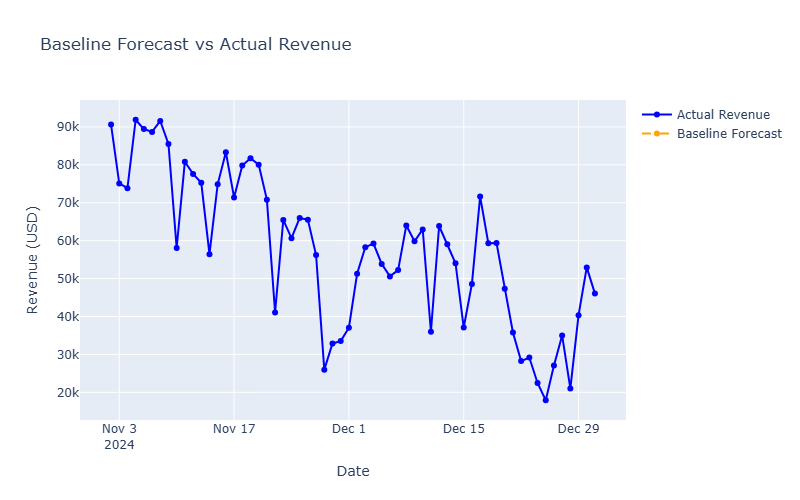

In [45]:
recent_data = daily_summary[daily_summary['payment_day'] > daily_summary['payment_day'].max() - pd.Timedelta(days=60)]

fig = go.Figure()

# ➊ الإيرادات الفعلية
fig.add_trace(go.Scatter(
    x=recent_data['payment_day'],
    y=recent_data['daily_total_revenue'],
    mode='lines+markers',
    name='Actual Revenue',
    line=dict(color='blue')
))

# ➋ التنبؤات (baseline)
fig.add_trace(go.Scatter(
    x=baseline_forecast['predicted_day'],
    y=baseline_forecast['predicted_revenue'],
    mode='lines+markers',
    name='Baseline Forecast',
    line=dict(color='orange', dash='dash')
))

# إعدادات الرسم
fig.update_layout(
    title="Baseline Forecast vs Actual Revenue",
    xaxis_title="Date",
    yaxis_title="Revenue (USD)",
    hovermode=False,
    dragmode=False,
    height=500
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))

# Optional: Save the image if needed
# fig.write_image("revenue_forecast_vs_actual.png", scale=2)

## Linear Regression Model
-  سنعطيه ميزات مثل الطقس واسم اليوم وهل اليوم عطلة أم لا لتوقع الإيرادات

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

df = daily_summary.copy()
df['payment_day'] = pd.to_datetime(df['payment_day'])

df['day_num'] = (df['payment_day'] - df['payment_day'].min()).dt.days
df['day_of_week'] = df['payment_day'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month'] = df['payment_day'].dt.month

df = pd.get_dummies(df, columns=['weather_bin'], drop_first=True)

feature_cols = ['day_num', 'day_of_week', 'is_weekend', 'month'] + \
               [col for col in df.columns if col.startswith('weather_bin_')]

X = df[feature_cols]
y = df['daily_total_revenue']

In [47]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [48]:
# آخر يوم نملكه
last_day = df['payment_day'].max()
next_days = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=10)

# إنشاء DataFrame للأيام الجديدة
future_df = pd.DataFrame({'payment_day': next_days})
future_df['day_num'] = (future_df['payment_day'] - df['payment_day'].min()).dt.days
future_df['day_of_week'] = future_df['payment_day'].dt.dayofweek
future_df['is_weekend'] = (future_df['day_of_week'] >= 5).astype(int)
future_df['month'] = future_df['payment_day'].dt.month

# لنفترض أن الطقس للأيام القادمة سيكون "Cloudy" مثلاً (يمكنك تغييره)
future_df['weather_bin_Cloudy'] = 1
future_df['weather_bin_Rainy'] = 0
# إذا كان هناك أعمدة أخرى من dummy encoding، يجب إضافتها بنفس القيم

# تعبئة الأعمدة الناقصة بالقيمة 0 (احتياطي)
for col in X.columns:
    if col not in future_df.columns:
        future_df[col] = 0

# ترتيب الأعمدة مثل X
future_X = future_df[X.columns]

In [49]:
future_df['predicted_revenue'] = model.predict(future_X)

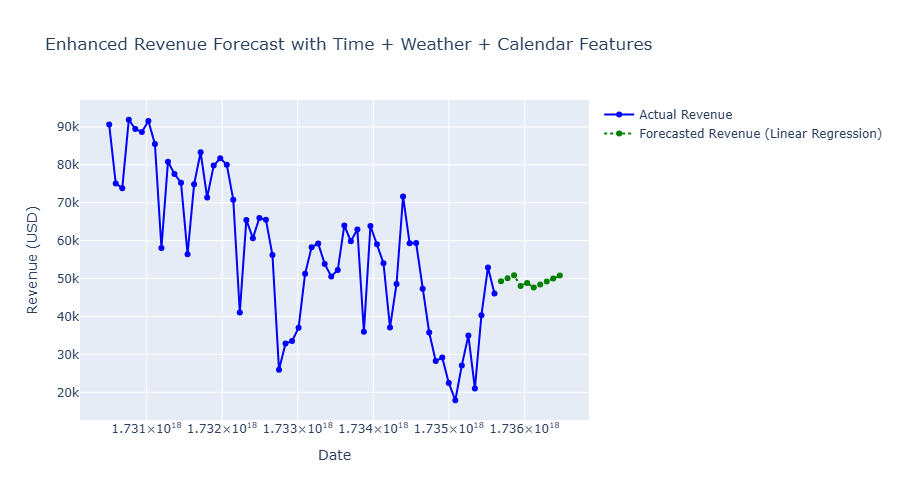

In [50]:
fig = go.Figure()

# الإيرادات الفعلية
recent_actual = df[df['payment_day'] > last_day - pd.Timedelta(days=60)]

fig.add_trace(go.Scatter(
    x=recent_actual['payment_day'],
    y=recent_actual['daily_total_revenue'],
    mode='lines+markers',
    name='Actual Revenue',
    line=dict(color='blue')
))

# الإيرادات المتوقعة
fig.add_trace(go.Scatter(
    x=future_df['payment_day'],
    y=future_df['predicted_revenue'],
    mode='lines+markers',
    name='Forecasted Revenue (Linear Regression)',
    line=dict(color='green', dash='dot')
))

fig.update_layout(
    title="Enhanced Revenue Forecast with Time + Weather + Calendar Features",
    xaxis_title="Date",
    yaxis_title="Revenue (USD)",
    hovermode=False,
    dragmode=False,
    height=500
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=900, height=500, engine="kaleido")
display(Image(data=png_bytes))


## Prophet

In [51]:

df_prophet = daily_summary[['payment_day', 'daily_total_revenue']].copy()
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [52]:
model = Prophet()
model.fit(df_prophet)

DEBUG	Task(Task-6) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-6) cmdstanpy:model.py:__init__()- Adding TBB (C:\Users\Rami\AppData\Roaming\Python\Python312\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO	Task(Task-6) prophet:forecaster.py:parse_seasonality_args()- Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO	Task(Task-6) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\3bvlz77p.json
DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\82txzs6q.json
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num

In [53]:
future = model.make_future_dataframe(periods=10)

forecast = model.predict(future)

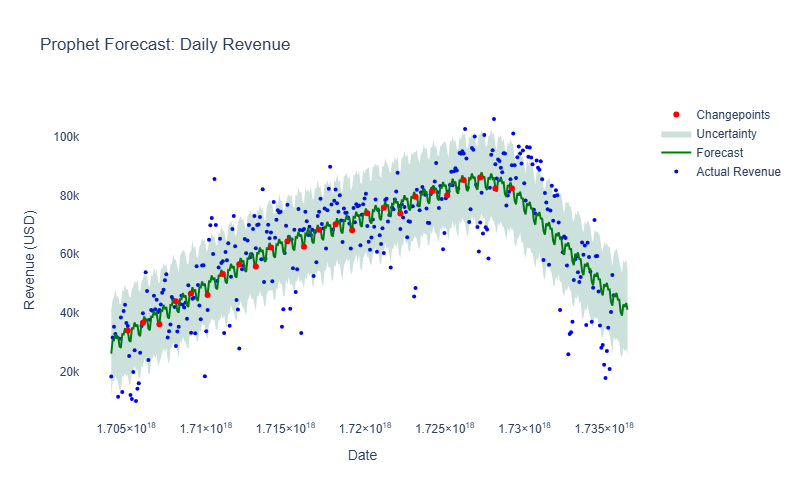

In [54]:
# Create the Prophet forecast plot manually
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(
    x=model.history['ds'],
    y=model.history['y'],
    mode='markers',
    name='Actual Revenue',
    marker=dict(color='blue', size=4)
))

# Add forecast
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Forecast',
    line=dict(color='green', width=2)
))

# Add uncertainty interval
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(width=0),
    name='Uncertainty'
))

# Add changepoints
if model.changepoints is not None:
    fig.add_trace(go.Scatter(
        x=model.changepoints,
        y=forecast.loc[forecast['ds'].isin(model.changepoints), 'yhat'],
        mode='markers',
        marker=dict(color='red', size=6),
        name='Changepoints'
    ))

# Update layout
fig.update_layout(
    title='Prophet Forecast: Daily Revenue',
    xaxis_title='Date',
    yaxis_title='Revenue (USD)',
    hovermode=False,
    dragmode=False,
    height=500,
    width=800,
    plot_bgcolor='white',
    font=dict(family="Arial", size=12)
)

# Convert to static image and display
png_bytes = fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(data=png_bytes))

# Optional: Save the image
fig.write_image("prophet_forecast.png", scale=2)

### تحليل المودل بدون أي تعديل على البارامترات
 - الاتجاه العام نجد أنه يزداد منذ بداية العام إلى أن يصل إلى ذروته في الشهر  العاشر من العام ثم يعاود الانخفاض إلى نهاية العام حيث يتوافق تماما مع فصول السنة الارتفاع في االربيع والصيف وانخفاض في الشتاء
 - نلاحظ أنه هناك نمط موسمي وهو أسبوعي نلاحظ تكرار هذا النمط كل أسبوع حيث نلاحظ أنه يرتفع في بداية الأسبوع ومن ثم يعود للانخفاض في نهايته حيث كأنه هذا يدل على انه ينخفض استعمال الرحلات بالدراجات أثناء العطلة وهذا يددل انه رحلات الدراجات يتم استخدامها للذهاب إلى العمل
 - نلاحظ أن المودل غير واثق من توقعاته وذلك بسبب الهالة الكبيرة حول الخط الأزرق وأيضا بعد النقاط السوداء ةالتي هي البيانات الفعلية عن الخط الأزرق

## Prohet Tune

In [55]:
model_tuned = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_range=0.8,
    changepoint_prior_scale=0.05
)

DEBUG	Task(Task-6) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-6) cmdstanpy:model.py:__init__()- TBB already found in load path


In [56]:
model_tuned.fit(df_prophet)

DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\cdqudqak.json
DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\vnjuuwaq.json
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\Rami\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98292', 'data', 'file=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmpepwopcgc\\cdqudqak.json', 'init=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmpepwopcgc\\vnjuuwaq.json', 'output', 'file=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmpepwopcgc\\prophet_model61zf415i\\prophet_model-20250706123301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:33:01 - cmdstanpy - INFO - Chain

In [57]:
future_tuned = model_tuned.make_future_dataframe(periods=10)
forecast_tuned = model_tuned.predict(future_tuned)

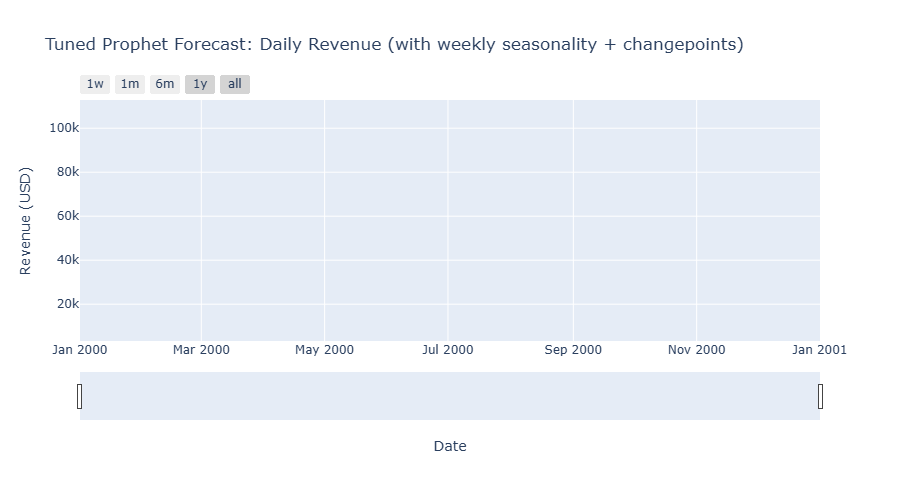

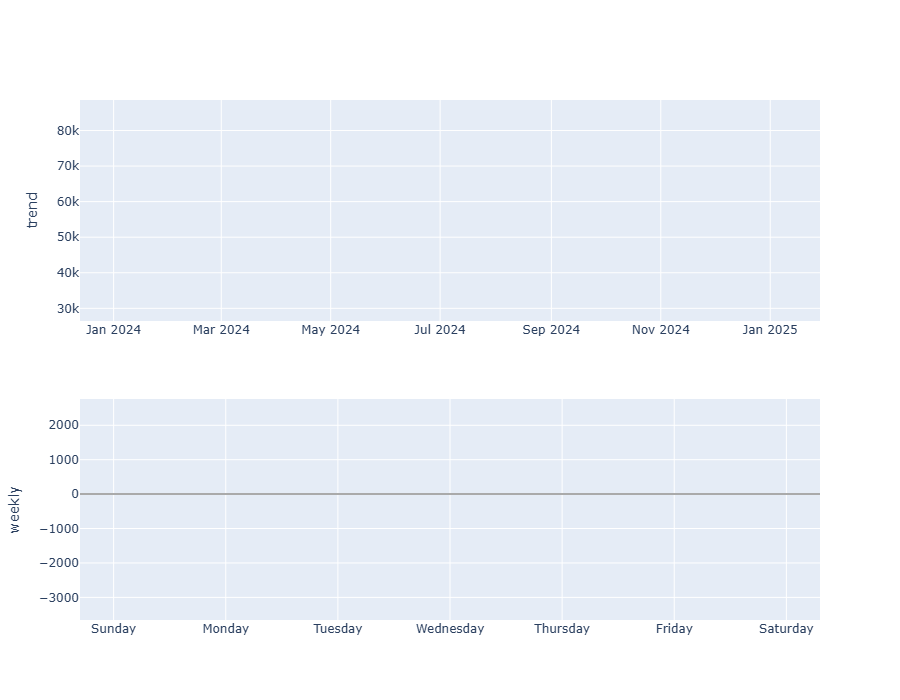

In [58]:
# Generate the main forecast plot using Prophet
fig_forecast = plot_plotly(model_tuned, forecast_tuned)
fig_forecast.update_layout(
    title='Tuned Prophet Forecast: Daily Revenue (with weekly seasonality + changepoints)',
    xaxis_title='Date',
    yaxis_title='Revenue (USD)',
    hovermode=False,
    dragmode=False,
    height=500
)

# Convert forecast plot to static image and display
png_forecast = fig_forecast.to_image(format="png", width=900, height=500, engine="kaleido")
display(Image(data=png_forecast))

# Generate components plot
fig_components = plot_components_plotly(model_tuned, forecast_tuned)

# Convert components plot to static image and display
png_components = fig_components.to_image(format="png", width=900, height=700, engine="kaleido")
display(Image(data=png_components))

### استنتاج
- نلاحظ لا يوجد الكثير من الاختلافات

In [59]:
model_holidays = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_range=0.9,
    changepoint_prior_scale=0.05
)

# إضافة العطل الرسمية الأمريكية
model_holidays.add_country_holidays(country_name='US')

DEBUG	Task(Task-6) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-6) cmdstanpy:model.py:__init__()- TBB already found in load path


In [60]:
# توليد جدول أيام عطلة نهاية الأسبوع من نفس المدى الزمني
weekend_days = df_prophet[df_prophet['ds'].dt.dayofweek >= 5][['ds']].copy()
weekend_days['holiday'] = 'weekend'
weekend_days['lower_window'] = 0
weekend_days['upper_window'] = 0

In [61]:
model_holidays = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_range=0.9,
    changepoint_prior_scale=0.05,
    holidays=weekend_days
)

model_holidays.add_country_holidays(country_name='US')

DEBUG	Task(Task-6) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-6) cmdstanpy:model.py:__init__()- TBB already found in load path


In [62]:
model_holidays.fit(df_prophet)

INFO	Task(Task-6) prophet:forecaster.py:parse_seasonality_args()- Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\b2ru8377.json
DEBUG	Task(Task-6) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Rami\AppData\Local\Temp\tmpepwopcgc\uz_9vt7w.json
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-6) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\Rami\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=53128', 'data', 'file=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmpepwopcgc\\b2ru8377.json', 'init=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmpepwopcgc\\uz_9vt7w.json', 'output', 'file=C:\\Users\\Rami\\AppData\\Local\\Temp\\tmp

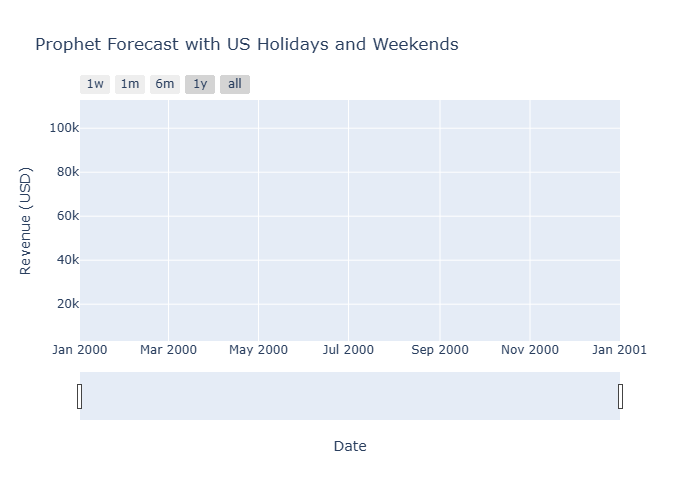

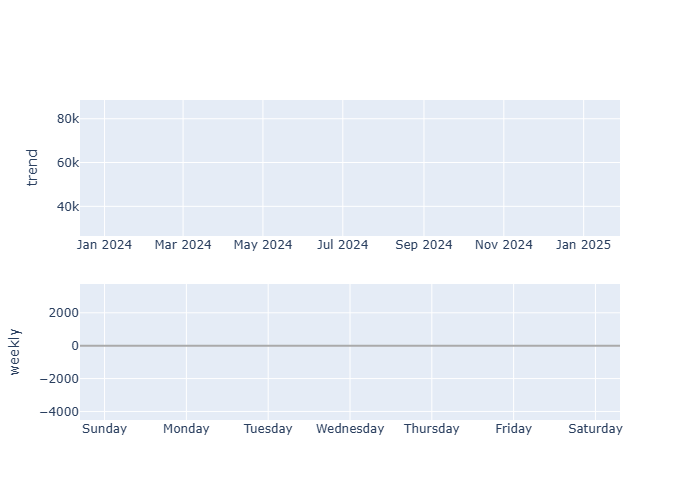

In [63]:
import plotly.io as pio
pio.renderers.default = "png"  # Set default to static PNG rendering

# Generate and display Prophet forecast plot
fig_forecast = plot_plotly(model_holidays, forecast)
fig_forecast.update_layout(
    title='Prophet Forecast with US Holidays and Weekends',
    xaxis_title='Date',
    yaxis_title='Revenue (USD)',
    hovermode=False,
    dragmode=False
)
fig_forecast.show()

# Generate and display components plot
comp_fig = plot_components_plotly(model_holidays, forecast)
comp_fig.show()

يمكننا رؤية تأثير العطل بشكل واضح على الرحلات والعائد المالي  
نلاحظ انه بعطل نهاية الأسبوع يوجد زيادة طفيفة بالعائد المالي ولكن في جميع الأعياد والمناسبات الآخرى نلاحظ انخفاض حاد في العائد المالي

## B

### B1

In [6]:
print(MAIN_DF.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'year', 'month', 'day', 'weekday', 'duration_minutes',
       'total_cost', 'start_point', 'end_point', 'start_in_cbd', 'end_in_cbd',
       'cbd_fee', 'passed_through_cbd', 'distance_to_cbd', 'near_cbd',
       'ride_date', 'datetime', 'icon', 'weather_bin', 'payment_day',
       'capacity_bucket_start', 'capacity_bucket_end', 'dist_bus_start',
       'dist_metro_start', 'dist_bus_end', 'dist_metro_end', 'gh_start_p7',
       'gh_end_p7', 'trip_demand_level', 'daily_total_revenue'],
      dtype='object')


In [6]:

# 2. Feature selection from your provided list
selected_features = [
    # Temporal features
    'month',                
    'weekday',              
    
    # Trip characteristics
    'duration_minutes',    
    'total_cost',          
    
    # Spatial features
    'start_in_cbd',     
    'end_in_cbd',           
    'passed_through_cbd',   
    'distance_to_cbd',      
    'near_cbd',             
    
    # Station characteristics
    'capacity_bucket_start',
    'capacity_bucket_end',  
    
    # Accessibility features
    'dist_bus_start',      
    'dist_metro_start',    
    'dist_bus_end',         
    'dist_metro_end',      
    
    # Weather features
    'weather_bin',         
    
    # Demand features
    'trip_demand_level'     
]

# 3. Create sampling strata
MAIN_DF['sampling_strata'] = (
    MAIN_DF['weather_bin'].astype(str) + '_' + 
    MAIN_DF['capacity_bucket_start'].astype(str) + '_' + 
    MAIN_DF['weekday'].astype(str)
)

# 4. Proportional stratified sampling
sample_size = 20000  # Target sample size
strata_counts = MAIN_DF['sampling_strata'].value_counts(normalize=True)
sample_counts = (strata_counts * sample_size).round().astype(int)

# Adjust for rounding differences
diff = sample_size - sample_counts.sum()
if diff != 0:
    # Distribute difference proportionally
    strata_to_adjust = sample_counts.index[:abs(diff)]
    adjustment = 1 if diff > 0 else -1
    for stratum in strata_to_adjust:
        sample_counts[stratum] += adjustment

# 5. Perform sampling
sampled_df = pd.DataFrame()
for stratum, count in sample_counts.items():
    if count <= 0:
        continue
        
    stratum_data = MAIN_DF[MAIN_DF['sampling_strata'] == stratum]
    if len(stratum_data) == 0:
        continue
        
    if len(stratum_data) > count:
        sampled_stratum = stratum_data.sample(count, random_state=42)
    else:
        sampled_stratum = stratum_data
    sampled_df = pd.concat([sampled_df, sampled_stratum])

# 6. Select only the specified features
final_sampled_df = sampled_df[selected_features].copy()

# 7. Save the sampled dataset with selected features
final_sampled_df.to_parquet("data/sampled_clustering_data.parquet", index=False)

print(f"Created stratified sample with {len(final_sampled_df)} records")
print(f"Selected {len(selected_features)} features for clustering")
print("First 3 rows of sampled data:")
final_sampled_df.head(3)

Created stratified sample with 20000 records
Selected 17 features for clustering
First 3 rows of sampled data:


month   weekday  duration_minutes  total_cost  start_in_cbd  \
5421319     11  Thursday             13.88        3.08         False   
1428425      4  Thursday              8.25        2.24         False   
3288422      8  Thursday             12.44        3.95         False   

         end_in_cbd  passed_through_cbd  distance_to_cbd  near_cbd  \
5421319       False                   0       579.087775       1.0   
1428425       False                   0      5444.517233       0.0   
3288422       False                   0       870.172874       1.0   

        capacity_bucket_start capacity_bucket_end  dist_bus_start  \
5421319                medium              medium     1873.686401   
1428425                medium              medium     2648.539551   
3288422                medium              medium      234.861801   

         dist_metro_start  dist_bus_end  dist_metro_end weather_bin  \
5421319         29.132784    161.529266       24.944466      cloudy   
1428425        182.544571   1756.414551       16.888756      cloudy   
3288422         60.926613    882.958252       13.238761      cloudy   

        trip_demand_level  
5421319            yellow  
1428425            yellow  
3288422               red

In [10]:
print(MAIN_DF.shape)

(6101316, 43)


In [9]:
print(final_sampled_df.shape)

(50000, 17)


In [7]:
# import pandas as pd
# import numpy as np

# 1. Load the dataset
df = MAIN_DF

# 2. Feature selection from your provided list (for sampling only)
sampling_features = [
    'weather_bin',          # Weather condition
    'capacity_bucket_start',# Station size at start
    'weekday'               # Day of week patterns
]

# 3. Create sampling strata
df['sampling_strata'] = (
    df['weather_bin'].astype(str) + '_' + 
    df['capacity_bucket_start'].astype(str) + '_' + 
    df['weekday'].astype(str)
)

# 4. Proportional stratified sampling
sample_size = 20000  # Target sample size
strata_counts = df['sampling_strata'].value_counts(normalize=True)
sample_counts = (strata_counts * sample_size).round().astype(int)

# Adjust for rounding differences
diff = sample_size - sample_counts.sum()
if diff != 0:
    # Distribute difference proportionally
    strata_to_adjust = sample_counts.index[:abs(diff)]
    adjustment = 1 if diff > 0 else -1
    for stratum in strata_to_adjust:
        sample_counts[stratum] += adjustment

# 5. Perform sampling while keeping all columns
sampled_df = pd.DataFrame()
for stratum, count in sample_counts.items():
    if count <= 0:
        continue
        
    stratum_data = df[df['sampling_strata'] == stratum]
    if len(stratum_data) == 0:
        continue
        
    if len(stratum_data) > count:
        sampled_stratum = stratum_data.sample(count, random_state=42)
    else:
        sampled_stratum = stratum_data
    sampled_df = pd.concat([sampled_df, sampled_stratum])

# 6. Save the sampled dataset with all original columns
sampled_df.to_parquet("data/sampled_clustering_data.parquet", index=False)

print(f"Created stratified sample with {len(sampled_df)} records")
print(f"Preserved all {len(df.columns)} original columns")
print("First 3 rows of sampled data:")
# print(sampled_df[['ride_id', 'started_at', 'ended_at', 'start_station_name', 'member_casual']].head(3))
sampled_df.head()

Created stratified sample with 20000 records
Preserved all 43 original columns
First 3 rows of sampled data:


ride_id  rideable_type              started_at  \
5421319  E5AE71AF8BC9D8CB  electric_bike 2024-11-07 08:09:52.096   
1428425  0E56ABFBB5EF87E8  electric_bike 2024-04-18 18:17:39.000   
3288422  681486088C8851DA   classic_bike 2024-08-22 17:37:04.336   
1136053  A0EB9B7DF0C7B6F2  electric_bike 2024-04-18 16:29:57.000   
5014081  D2A435028E8F634B  electric_bike 2024-10-10 07:54:13.360   

                        ended_at                    start_station_name  \
5421319  2024-11-07 08:23:45.180  South Dakota Ave & Bladensburg Rd NE   
1428425      2024-04-18 18:25:54            Carroll & Westmoreland Ave   
3288422  2024-08-22 17:49:30.926                         7th & K St NW   
1136053      2024-04-18 16:40:07       American University East Campus   
5014081  2024-10-10 08:03:27.488            Calvert St & Woodley Pl NW   

         start_station_id                        end_station_name  \
5421319             31538                           1st & K St NE   
1428425             32025                     5th & Kennedy St NW   
3288422             31653                           8th & F St NE   
1136053             31320  37th & O St NW / Georgetown University   
5014081             31121                          21st & E St NW   

         end_station_id  start_lat  start_lng  ...  capacity_bucket_end  \
5421319           31662  38.925200 -76.964896  ...               medium   
1428425           31403  38.975013 -77.011149  ...               medium   
3288422           31631  38.902674 -77.021392  ...               medium   
1136053           31236  38.936284 -77.087087  ...               medium   
5014081           31220  38.920000 -77.050000  ...               medium   

         dist_bus_start dist_metro_start  dist_bus_end  dist_metro_end  \
5421319     1873.686401        29.132784    161.529266       24.944466   
1428425     2648.539551       182.544571   1756.414551       16.888756   
3288422      234.861801        60.926613    882.958252       13.238761   
1136053      207.985352        69.795952    249.676102       49.159126   
5014081      430.986084       211.081390    258.199341       13.797384   

         gh_start_p7 gh_end_p7  trip_demand_level  daily_total_revenue  \
5421319      dqcm2w5   dqcjr9y             yellow                  NaN   
1428425      dqcjxx4   dqcjxk7             yellow                  NaN   
3288422      dqcjr64   dqcjrcn                red                  NaN   
1136053      dqcjtb4   dqcjq4y                red                  NaN   
5014081      dqcjqtj   dqcjqbb                red                  NaN   

                sampling_strata  
5421319  cloudy_medium_Thursday  
1428425  cloudy_medium_Thursday  
3288422  cloudy_medium_Thursday  
1136053  cloudy_medium_Thursday  
5014081  cloudy_medium_Thursday  

[5 rows x 43 columns]

In [13]:
print(MAIN_DF.shape)

(6101316, 43)


In [10]:
# 1. Load the dataset
df = sampled_df

# 2. List of columns to remove
columns_to_drop = [
    'year', 'day', 'weekday',  'start_point', 'end_point',
     'near_cbd',
    'ride_date', 'datetime', 'icon', 'weather_bin', 'payment_day',
    'gh_start_p7',
    'gh_end_p7', 'daily_total_revenue'
]

# 3. List of columns to keep (your original data columns)
columns_to_keep = [
    'ride_id', 'rideable_type', 'started_at', 'ended_at',
    'start_station_name', 'start_station_id', 'end_station_name',
    'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
    'member_casual' , 'month', 'duration_minutes',
    'total_cost', 'cbd_fee', 'passed_through_cbd',  'weather_bin',  'capacity_bucket_start', 'capacity_bucket_end', 'trip_demand_level',
    'distance_to_cbd',
    'dist_bus_start',
    'dist_metro_start',
    'dist_bus_end',
    'dist_metro_end',
    'start_in_cbd',
    'end_in_cbd'
]

# 4. Drop the specified columns
# First approach: Drop specific columns
cleaned_df = df.drop(columns=columns_to_drop)

# Alternative approach: Keep only the columns you want
# cleaned_df = df[columns_to_keep].copy()

# 5. Save the cleaned dataset
cleaned_df.to_parquet("data/cleaned_bike_data.parquet", index=False)

print("Data cleaning completed!")
print(f"Original columns: {len(df.columns)}")
print(f"Columns after cleaning: {len(cleaned_df.columns)}")
print("Columns kept:")
print(cleaned_df.columns)


Data cleaning completed!
Original columns: 43
Columns after cleaning: 29
Columns kept:
Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'month', 'duration_minutes', 'total_cost',
       'start_in_cbd', 'end_in_cbd', 'cbd_fee', 'passed_through_cbd',
       'distance_to_cbd', 'capacity_bucket_start', 'capacity_bucket_end',
       'dist_bus_start', 'dist_metro_start', 'dist_bus_end', 'dist_metro_end',
       'trip_demand_level', 'sampling_strata'],
      dtype='object')


In [11]:
print(cleaned_df.shape)

(20000, 29)


* i make it (50000, 30)

### B2

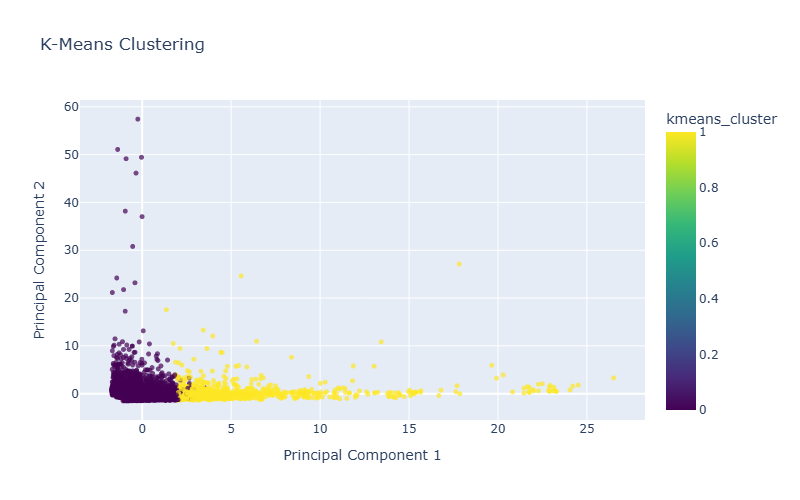

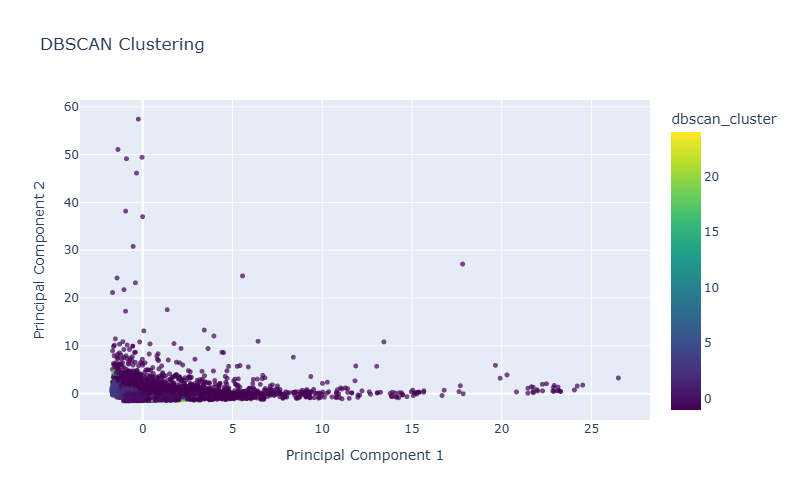

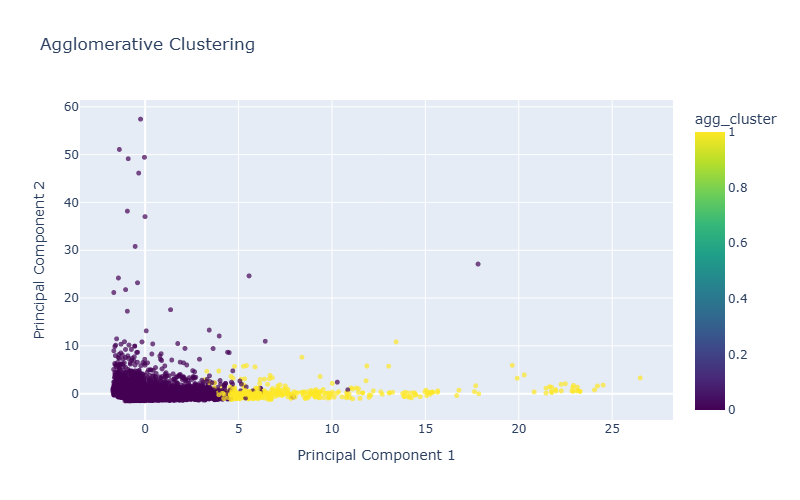

Clustering Algorithm Comparison:


Algorithm  Number of Clusters  Silhouette Score
0        K-Means                   2          0.529866
1         DBSCAN                  26          0.270363
2  Agglomerative                   2          0.664634


K-Means Cluster Statistics:


duration_minutes        total_cost        distance_to_cbd  \
                           mean median       mean median            mean   
kmeans_cluster                                                             
0                         14.97   9.73       3.79   3.95         1659.85   
1                         19.32   9.83       3.91   3.95         8983.82   

                        dist_bus_start              dist_metro_start  \
                 median           mean       median             mean   
kmeans_cluster                                                         
0               1160.87     715.080017   456.190002       107.879997   
1               7707.51    6862.259766  5691.399902       226.940002   

                           dist_bus_end              dist_metro_end  \
                    median         mean       median           mean   
kmeans_cluster                                                        
0                69.849998   679.679993   426.470001     107.419998   
1               124.809998  7180.930176  6009.879883     244.229996   

                           start_in_cbd        end_in_cbd         count  \
                    median         mean median       mean median          
kmeans_cluster                                                            
0                72.260002         0.19    0.0        0.2    0.0  18482   
1               134.699997         0.01    0.0        0.0    0.0   1518   

               percentage  
                           
kmeans_cluster             
0                   92.41  
1                    7.59


DBSCAN Cluster Statistics:


duration_minutes         total_cost        distance_to_cbd  \
                           mean  median       mean median            mean   
dbscan_cluster                                                              
-1                        32.88   19.18       4.47   3.95         5421.48   
 0                        10.15    8.08       3.47   3.95         1573.14   
 1                        13.56   11.67       3.96   4.45             NaN   
 2                        13.72   11.80       3.99   4.45          900.57   
 3                        12.54    7.53       4.31   4.95             NaN   
 4                         4.39    4.07       3.95   3.95         6758.25   
 5                         5.23    4.75       3.95   3.95         8806.82   
 6                        11.63    9.90       1.79   1.73          998.23   
 7                         5.00    3.31       1.28   1.22          528.82   
 8                         3.95    3.15       3.95   3.95         5499.23   
 9                        24.65   22.48       2.83   2.75             NaN   
 10                        8.96    6.78       3.92   3.95         4775.21   
 11                       17.03   16.06       1.99   1.94          508.51   
 12                       32.79   32.67       3.17   3.13          431.42   
 13                        4.28    3.72       3.95   3.95         3594.03   
 14                       15.90   16.43       4.44   4.45          543.82   
 15                       23.88   23.07       2.69   2.66             NaN   
 16                        6.49    6.57       1.76   1.83         8559.14   
 17                      114.61  114.82       7.73   7.74             NaN   
 18                       31.64   31.09       2.58   2.55          363.80   
 19                        7.39    6.63       3.95   3.95         6207.30   
 20                        4.91    5.08       3.95   3.95         7435.35   
 21                        4.52    4.12       1.30   1.27         5847.28   
 22                        6.55    5.58       1.98   1.84         6002.14   
 23                       27.22   25.30       2.86   2.77          759.43   
 24                        5.17    5.07       1.70   1.68         5333.69   

                        dist_bus_start              dist_metro_start  \
                 median           mean       median             mean   
dbscan_cluster                                                         
-1              4833.50    3515.659912  2404.750000       225.350006   
 0              1168.28     772.330017   593.510010        93.940002   
 1                  NaN     542.260010   499.010010        91.839996   
 2               695.47     191.350006   164.240005        73.900002   
 3                  NaN     194.770004   164.240005        74.309998   
 4              6905.33    2238.189941  2087.129883       149.199997   
 5              8677.45    3910.639893  3918.270020        81.800003   
 6               883.71     379.489990   502.549988       429.549988   
 7               400.19     370.320007   456.190002       418.760010   
 8              5480.99    5057.009766  5205.370117       139.460007   
 9                  NaN     298.799988   151.949997       420.459991   
 10             4833.50     601.909973   631.880005        70.040001   
 11              400.19     620.309998   421.440002        39.490002   
 12              384.78     200.059998   143.779999        52.040001   
 13             3534.86    3282.530029  3108.510010        47.799999   
 14              420.89     173.949997   144.070007        78.660004   
 15                 NaN     617.049988   613.409973       888.570007   
 16             8561.03    4115.779785  3925.750000        51.259998   
 17                 NaN     220.179993   160.559998        45.180000   
 18              394.33     275.369995   151.949997       415.119995   
 19             6248.04    6152.560059  6160.350098        56.220001   
 20             7443.82    7346.750000  7320.549805  


Agglomerative Cluster Statistics:


duration_minutes        total_cost        distance_to_cbd  \
                        mean median       mean median            mean   
agg_cluster                                                             
0                      15.23   9.75       3.81   3.95         1988.35   
1                      17.99   9.03       3.56   3.95        13330.86   

                      dist_bus_start              dist_metro_start  \
               median           mean       median             mean   
agg_cluster                                                          
0             1273.07     928.309998   509.600006       111.269997   
1            10454.74   10922.000000  9529.469727       333.869995   

                         dist_bus_end              dist_metro_end              \
                 median          mean       median           mean      median   
agg_cluster                                                                     
0             71.160004    910.969971   470.720001     110.889999   74.209999   
1            185.740005  11252.389648  9529.469727     383.690002  203.759995   

            start_in_cbd        end_in_cbd         count percentage  
                    mean median       mean median                    
agg_cluster                                                          
0                   0.18    0.0       0.19    0.0  19493      97.46  
1                   0.01    0.0       0.00    0.0    507       2.54

In [12]:


# 1. Load the sampled data
sampled_df = pd.read_parquet("data/cleaned_bike_data.parquet")

# 2. Select features for clustering
cluster_features = [
    'duration_minutes', 
    'total_cost',
    'distance_to_cbd',
    'dist_bus_start',
    'dist_metro_start',
    'dist_bus_end',
    'dist_metro_end',
    'start_in_cbd',
    'end_in_cbd'
]

# 3. Prepare data for clustering
X = sampled_df[cluster_features].copy()

# Convert boolean columns to int
for col in ['start_in_cbd', 'end_in_cbd']:
    X[col] = X[col].astype(int)

# Fill missing values with median
X = X.fillna(X.median())

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Apply K-Means clustering
# Determine optimal number of clusters using Silhouette Score
best_k = 3
best_silhouette = -1
silhouette_scores = []

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, kmeans_labels)
    silhouette_scores.append(silhouette)
    
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
sampled_df['kmeans_cluster'] = kmeans_labels

# 5. Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)
sampled_df['dbscan_cluster'] = dbscan_labels

# 6. Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg.fit_predict(X_scaled)
sampled_df['agg_cluster'] = agg_labels

# 7. Evaluate clustering results
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sampled_df['pca1'] = X_pca[:, 0]
sampled_df['pca2'] = X_pca[:, 1]

# Create static plots
def create_cluster_plot(df, cluster_col, title):
    fig = px.scatter(
        df, 
        x='pca1', 
        y='pca2', 
        color=cluster_col,
        title=title,
        labels={'pca1': 'Principal Component 1', 'pca2': 'Principal Component 2'},
        color_continuous_scale='Viridis'
    )
    fig.update_traces(marker=dict(size=5, opacity=0.7))
    fig.update_layout(autosize=False, width=800, height=500)
    return fig

# Create cluster comparison table
comparison_data = {
    'Algorithm': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Number of Clusters': [
        sampled_df['kmeans_cluster'].nunique(),
        sampled_df['dbscan_cluster'].nunique(),
        sampled_df['agg_cluster'].nunique()
    ],
    'Silhouette Score': [
        silhouette_score(X_scaled, kmeans_labels),
        silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if (dbscan_labels != -1).any() else np.nan,
        silhouette_score(X_scaled, agg_labels)
    ]
}
comparison_df = pd.DataFrame(comparison_data)

# Create cluster statistics
def create_cluster_stats(df, cluster_col):
    stats = df.groupby(cluster_col)[cluster_features].agg(['mean', 'median'])
    stats['count'] = df[cluster_col].value_counts().sort_index()
    stats['percentage'] = (stats['count'] / stats['count'].sum()) * 100
    return stats.round(2)

kmeans_stats = create_cluster_stats(sampled_df, 'kmeans_cluster')
dbscan_stats = create_cluster_stats(sampled_df, 'dbscan_cluster')
agg_stats = create_cluster_stats(sampled_df, 'agg_cluster')

# 8. Generate all visualizations as static images
# K-Means plot
kmeans_fig = create_cluster_plot(sampled_df, 'kmeans_cluster', 'K-Means Clustering')
kmeans_png = kmeans_fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(kmeans_png))

# DBSCAN plot
dbscan_fig = create_cluster_plot(sampled_df, 'dbscan_cluster', 'DBSCAN Clustering')
dbscan_png = dbscan_fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(dbscan_png))

# Agglomerative plot
agg_fig = create_cluster_plot(sampled_df, 'agg_cluster', 'Agglomerative Clustering')
agg_png = agg_fig.to_image(format="png", width=800, height=500, engine="kaleido")
display(Image(agg_png))

# Comparison table
print("Clustering Algorithm Comparison:")
display(comparison_df)

# K-Means statistics
print("\nK-Means Cluster Statistics:")
display(kmeans_stats)

# DBSCAN statistics
print("\nDBSCAN Cluster Statistics:")
display(dbscan_stats)

# Agglomerative statistics
print("\nAgglomerative Cluster Statistics:")
display(agg_stats)

# 9. Save results
sampled_df.to_parquet("data/clustered_bike_data.parquet", index=False)


Analysis for Kmeans Cluster

Cluster Descriptions:
- Cluster 0 (92.4%): short trips, low cost, non-CBD, near transit
- Cluster 1 (7.6%): medium trips, low cost, non-CBD, near transit

Top 5 Most Important Features:


Feature  Permutation_Importance  Decision_Tree_Importance  \
5      dist_bus_end                0.033945                  0.799394   
3    dist_bus_start                0.038740                  0.092234   
2   distance_to_cbd                0.055500                  0.066041   
4  dist_metro_start                0.004155                  0.018564   
6    dist_metro_end                0.003510                  0.017345   

   Random_Forest_Importance  Average_Importance  
5                  0.343383            0.392241  
3                  0.293555            0.141510  
2                  0.294003            0.138515  
4                  0.024558            0.015759  
6                  0.023536            0.014797

<Figure size 1000x600 with 0 Axes>

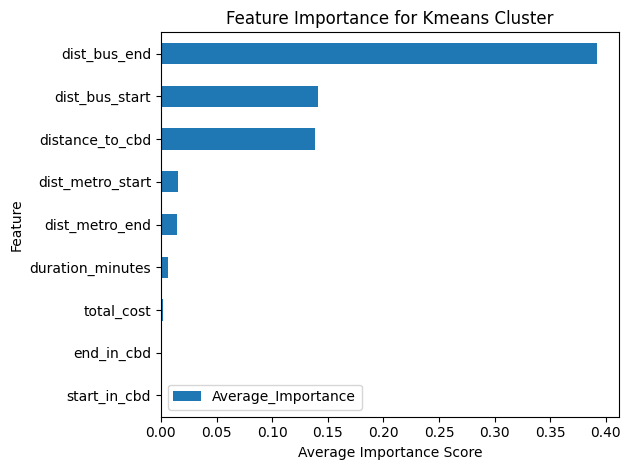


Analysis for Dbscan Cluster

Cluster Descriptions:
- Cluster -1 (18.4%): medium trips, medium cost, non-CBD, near transit
- Cluster 0 (53.3%): short trips, low cost, non-CBD, near transit
- Cluster 1 (10.9%): short trips, low cost, CBD-focused, near transit
- Cluster 2 (9.7%): short trips, low cost, CBD-focused, near transit
- Cluster 3 (5.7%): short trips, medium cost, CBD-focused, near transit
- Cluster 4 (0.1%): short trips, low cost, non-CBD, near transit
- Cluster 5 (0.1%): short trips, low cost, non-CBD, near transit
- Cluster 6 (0.2%): short trips, low cost, non-CBD, near transit
- Cluster 7 (0.1%): short trips, low cost, non-CBD, near transit
- Cluster 8 (0.0%): short trips, low cost, non-CBD, near transit
- Cluster 9 (0.2%): medium trips, low cost, CBD-focused, near transit
- Cluster 10 (0.2%): short trips, low cost, non-CBD, near transit
- Cluster 11 (0.1%): medium trips, low cost, non-CBD, near transit
- Cluster 12 (0.1%): medium trips, low cost, CBD-focused, near transit
-

Feature  Permutation_Importance  Decision_Tree_Importance  \
7     start_in_cbd                0.251220                  0.301393   
8       end_in_cbd                0.275390                  0.206226   
3   dist_bus_start                0.081565                  0.149785   
1       total_cost                0.073090                  0.064011   
2  distance_to_cbd                0.084620                  0.055278   

   Random_Forest_Importance  Average_Importance  
7                  0.183407            0.245340  
8                  0.188911            0.223509  
3                  0.093321            0.108224  
1                  0.177842            0.104981  
2                  0.095605            0.078501

<Figure size 1000x600 with 0 Axes>

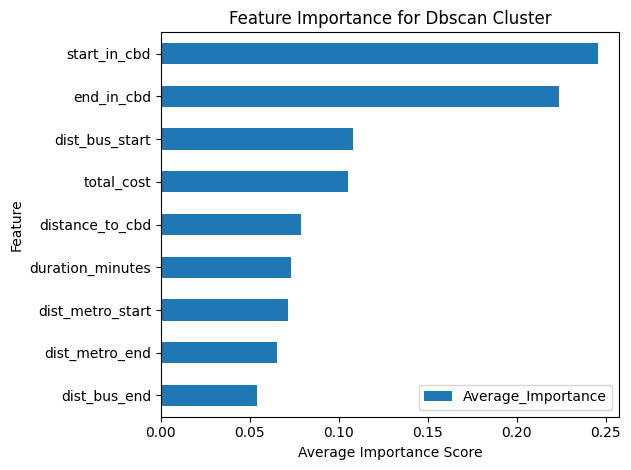


Analysis for Agg Cluster

Cluster Descriptions:
- Cluster 0 (97.5%): medium trips, low cost, non-CBD, near transit
- Cluster 1 (2.5%): medium trips, low cost, non-CBD, near transit

Top 5 Most Important Features:


Feature  Permutation_Importance  Decision_Tree_Importance  \
5      dist_bus_end                0.009440                  0.747094   
3    dist_bus_start                0.023520                  0.098686   
2   distance_to_cbd                0.006700                  0.021091   
6    dist_metro_end                0.003120                  0.065813   
4  dist_metro_start                0.002945                  0.048528   

   Random_Forest_Importance  Average_Importance  
5                  0.315265            0.357266  
3                  0.317647            0.146618  
2                  0.239761            0.089184  
6                  0.045297            0.038077  
4                  0.042470            0.031314

<Figure size 1000x600 with 0 Axes>

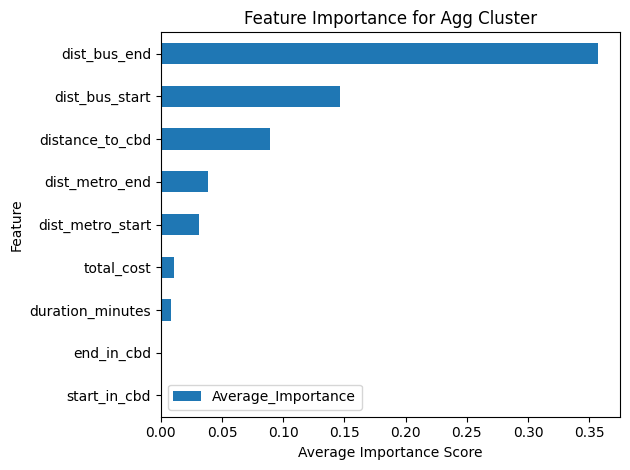


Final Model Comparison

Model Comparison Summary:


Algorithm  Silhouette Score   Top Feature  Feature Importance  \
0  Kmeans Cluster          0.529866  dist_bus_end            0.392241   
1  Dbscan Cluster          0.113941  start_in_cbd            0.245340   
2     Agg Cluster          0.664634  dist_bus_end            0.357266   

   Number of Clusters Interpretability  
0                   2             High  
1                  26           Medium  
2                   2             High


Recommendation: The best model is Agg Cluster with silhouette score 0.665
Key Insight: The most important feature is 'dist_bus_end' with importance score 0.357, suggesting this has the strongest influence on cluster formation


In [13]:

from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score

# 1. Load clustered data
clustered_df = pd.read_parquet("data/clustered_bike_data.parquet")

# 2. Feature selection
cluster_features = [
    'duration_minutes', 
    'total_cost',
    'distance_to_cbd',
    'dist_bus_start',
    'dist_metro_start',
    'dist_bus_end',
    'dist_metro_end',
    'start_in_cbd',
    'end_in_cbd'
]

# 3. Prepare data
X = clustered_df[cluster_features].copy()
for col in ['start_in_cbd', 'end_in_cbd']:
    X[col] = X[col].astype(int)
X = X.fillna(X.median())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Fixed cluster interpretation function
def interpret_clusters(cluster_col):
    # Calculate cluster statistics
    cluster_means = clustered_df.groupby(cluster_col)[cluster_features].mean()
    counts = clustered_df[cluster_col].value_counts().sort_index()
    percentages = (counts / len(clustered_df)) * 100
    
    # Create a clean stats DataFrame
    stats_df = cluster_means.copy()
    stats_df['count'] = counts.values
    stats_df['percentage'] = percentages.values
    
    # Generate cluster descriptions
    descriptions = []
    for cluster_id in stats_df.index:
        desc = f"Cluster {cluster_id} ({stats_df.loc[cluster_id, 'percentage']:.1f}%): "
        characteristics = []
        
        # Duration
        duration = stats_df.loc[cluster_id, 'duration_minutes']
        if duration < 15:
            characteristics.append("short trips")
        elif duration < 45:
            characteristics.append("medium trips")
        else:
            characteristics.append("long trips")
            
        # Cost
        cost = stats_df.loc[cluster_id, 'total_cost']
        if cost < 4:
            characteristics.append("low cost")
        elif cost < 8:
            characteristics.append("medium cost")
        else:
            characteristics.append("high cost")
            
        # CBD
        start_cbd = stats_df.loc[cluster_id, 'start_in_cbd']
        end_cbd = stats_df.loc[cluster_id, 'end_in_cbd']
        if start_cbd > 0.7 or end_cbd > 0.7:
            characteristics.append("CBD-focused")
        elif start_cbd < 0.3 and end_cbd < 0.3:
            characteristics.append("non-CBD")
            
        # Public transport
        bus_dist = stats_df.loc[cluster_id, 'dist_bus_start']
        metro_dist = stats_df.loc[cluster_id, 'dist_metro_start']
        if bus_dist < 500 or metro_dist < 500:
            characteristics.append("near transit")
        elif bus_dist > 1000 and metro_dist > 1000:
            characteristics.append("far from transit")
            
        descriptions.append(desc + ", ".join(characteristics))
    
    return stats_df, descriptions

# 5. Fixed feature importance analysis
def analyze_feature_importance(cluster_col):
    # Method 1: Permutation Importance
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_scaled, clustered_df[cluster_col])
    perm_importance = permutation_importance(
        dt, X_scaled, clustered_df[cluster_col],
        n_repeats=10, random_state=42
    )
    
    # Method 2: Decision Tree Feature Importance
    dt_importance = dt.feature_importances_
    
    # Method 3: Random Forest Feature Importance
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_scaled, clustered_df[cluster_col])
    rf_importance = rf.feature_importances_
    
    # Combine results
    importance_df = pd.DataFrame({
        'Feature': cluster_features,
        'Permutation_Importance': perm_importance.importances_mean,
        'Decision_Tree_Importance': dt_importance,
        'Random_Forest_Importance': rf_importance
    })
    
    # Calculate average importance of NUMERIC COLUMNS ONLY
    numeric_cols = ['Permutation_Importance', 'Decision_Tree_Importance', 'Random_Forest_Importance']
    importance_df['Average_Importance'] = importance_df[numeric_cols].mean(axis=1)
    importance_df = importance_df.sort_values('Average_Importance', ascending=False)
    
    return importance_df

# 6. Generate analysis for each algorithm
algorithms = ['kmeans_cluster', 'dbscan_cluster', 'agg_cluster']
results = {}

for algo in algorithms:
    print(f"\n{'='*50}")
    print(f"Analysis for {algo.replace('_', ' ').title()}")
    print(f"{'='*50}")
    
    # Cluster interpretation
    stats, descriptions = interpret_clusters(algo)
    print("\nCluster Descriptions:")
    for desc in descriptions:
        print(f"- {desc}")
    
    # Feature importance
    importance_df = analyze_feature_importance(algo)
    print("\nTop 5 Most Important Features:")
    display(importance_df.head(5))
    
    # Save results
    results[algo] = {
        'stats': stats,
        'descriptions': descriptions,
        'importance': importance_df
    }
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    importance_df.sort_values('Average_Importance').plot.barh(
        x='Feature', y='Average_Importance',
        title=f'Feature Importance for {algo.replace("_", " ").title()}'
    )
    plt.xlabel('Average Importance Score')
    plt.tight_layout()
    plt.savefig(f'{algo}_feature_importance.png', dpi=300)
    plt.show()

# 7. Compare best models
print("\n" + "="*50)
print("Final Model Comparison")
print("="*50)

# Determine best model for each algorithm
comparison = []
for algo in algorithms:
    # Calculate silhouette score
    labels = clustered_df[algo]
    if len(np.unique(labels)) > 1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = np.nan
    
    # Get feature importance insights
    top_feature = results[algo]['importance'].iloc[0]['Feature']
    top_importance = results[algo]['importance'].iloc[0]['Average_Importance']
    
    comparison.append({
        'Algorithm': algo.replace('_', ' ').title(),
        'Silhouette Score': score,
        'Top Feature': top_feature,
        'Feature Importance': top_importance,
        'Number of Clusters': len(np.unique(labels)),
        'Interpretability': "High" if score > 0.4 else "Medium"
    })

# Create comparison table
comparison_df = pd.DataFrame(comparison)
print("\nModel Comparison Summary:")
display(comparison_df)

# Recommendation
if not comparison_df['Silhouette Score'].isna().all():
    best_model = comparison_df.loc[comparison_df['Silhouette Score'].idxmax()]
    print(f"\nRecommendation: The best model is {best_model['Algorithm']} with silhouette score {best_model['Silhouette Score']:.3f}")
    print(f"Key Insight: The most important feature is '{best_model['Top Feature']}' with importance score {best_model['Feature Importance']:.3f}, suggesting this has the strongest influence on cluster formation")
else:
    print("\nRecommendation: No valid clustering found. All silhouette scores are NaN")